# Replication of Recommender Systems for Insurance Marketing

Done by Luke Strassburg

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from utils.pandas_utils import group_categoricals_tail
import utils.pimpmatplotlib as pm
from utils.xgbextras import stopping_at
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    average_precision_score,
    fbeta_score,
    jaccard_score
)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix


from xgboost.callback import EarlyStopping
from lightgbm.callback import early_stopping

from keras import backend as K
from keras.models import Sequential
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape, Concatenate, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.constraints import unit_norm
import tensorflow as tf
import plotly
import plotly.graph_objs as go




### Table 1: Insurance Product Possession: Period One

In [2]:
DATA_FOLDER = os.path.join("..", "sample_data")
DATA_FILE = "dataset.csv"
MODEL_TYPE = "model"
CONFIG_FOLDER = os.path.join("config")
CONFIG_FILE = "features.csv"

source_config = os.path.join(CONFIG_FOLDER, CONFIG_FILE)
features = pd.read_csv(source_config, keep_default_na=False, na_values=[""])
index = features.loc[features[MODEL_TYPE] == "index", "column"].tolist()
predictors = features.loc[features[MODEL_TYPE] == "predictor", "column"].tolist()
labels = features.loc[features[MODEL_TYPE] == "label", "column"].tolist()
categorical = features.loc[(features["categorical"] == 1) & (features["column"].isin(predictors)), "column"].tolist()

index = features.loc[features[MODEL_TYPE] == "index", "column"].tolist()
labels = features.loc[features[MODEL_TYPE] == "label", "column"].tolist()

source_file = os.path.join(DATA_FOLDER, DATA_FILE)
data = pd.read_csv(source_file, usecols=index+labels+["SET"],
        sep=";", decimal=".", encoding="latin1",
        keep_default_na = False, na_values = [""])

term1 = data[['HAS_A_1', 'HAS_B_1', 'HAS_C_1', 'HAS_D_1', 'HAS_E_1', 'HAS_F_1', 'HAS_G_1', 'HAS_H_1', 'HAS_I_1', 'HAS_L_1']]

col_means = term1.mean()

col_means

HAS_A_1    0.7810
HAS_B_1    0.2193
HAS_C_1    0.0110
HAS_D_1    0.2068
HAS_E_1    0.0193
HAS_F_1    0.0223
HAS_G_1    0.0243
HAS_H_1    0.0073
HAS_I_1    0.0204
HAS_L_1    0.0321
dtype: float64

### Table 2: Purchases Within Periods

In [3]:
sec_labels = features.loc[features[MODEL_TYPE] == "transition_label", "column"].tolist()

source_file = os.path.join(DATA_FOLDER, DATA_FILE)
data = pd.read_csv(source_file, usecols=index+labels+sec_labels+["SET"],
        sep=";", decimal=".", encoding="latin1",
        keep_default_na = False, na_values = [""])

term2 = data[['BUYED_A', 'BUYED_B', 'BUYED_C', 'BUYED_D', 'BUYED_E', 'BUYED_F', 'BUYED_G', 'BUYED_H', 'BUYED_I', 'BUYED_L']]

col_means = term2.mean()

col_means

BUYED_A    0.0366
BUYED_B    0.0265
BUYED_C    0.0017
BUYED_D    0.0192
BUYED_E    0.0019
BUYED_F    0.0028
BUYED_G    0.0032
BUYED_H    0.0012
BUYED_I    0.0026
BUYED_L    0.0036
dtype: float64

#### Table 3: ARules Associations Found

- Apriori Algorithm in ARules Library in R 
- Min Rule Length 2
- Min Support 1%
- Min Confidence 20%
- Looking for Lift, Count, Confidence, Support

In [ ]:
# Look at R File Arules.Rmd

# Classic Recommender Systems Approaches

#### Table 4: Item-Item Jacaard Similarity Matrix

In [4]:
n_items = len(term1.columns)
jaccard_matrix = np.zeros((n_items, n_items))

for i in range(n_items):
    for j in range(n_items):
        jaccard_matrix[i, j] = jaccard_score(term1.iloc[:, i], term1.iloc[:, j])

jaccard_matrix = np.round(jaccard_matrix, 2)

# Convert to DataFrame for labeling
jaccard_df = pd.DataFrame(jaccard_matrix, index=term1.columns, columns=term1.columns)
jaccard_df.to_csv("jacaard_df.csv")

jaccard_df.head(10)

HAS_A_1  HAS_B_1  HAS_C_1  HAS_D_1  HAS_E_1  HAS_F_1  HAS_G_1  \
HAS_A_1     1.00     0.22     0.01     0.11     0.01     0.01     0.02   
HAS_B_1     0.22     1.00     0.03     0.12     0.01     0.02     0.03   
HAS_C_1     0.01     0.03     1.00     0.02     0.01     0.02     0.06   
HAS_D_1     0.11     0.12     0.02     1.00     0.03     0.02     0.02   
HAS_E_1     0.01     0.01     0.01     0.03     1.00     0.06     0.02   
HAS_F_1     0.01     0.02     0.02     0.02     0.06     1.00     0.05   
HAS_G_1     0.02     0.03     0.06     0.02     0.02     0.05     1.00   
HAS_H_1     0.00     0.01     0.03     0.01     0.07     0.03     0.03   
HAS_I_1     0.02     0.03     0.02     0.03     0.08     0.03     0.04   
HAS_L_1     0.02     0.03     0.03     0.04     0.01     0.02     0.03   

         HAS_H_1  HAS_I_1  HAS_L_1  
HAS_A_1     0.00     0.02     0.02  
HAS_B_1     0.01     0.03     0.03  
HAS_C_1     0.03     0.02     0.03  
HAS_D_1     0.01     0.03     0.04  
HAS_E_1     0.07     0.08     0.01  
HAS_F_1     0.03     0.03     0.02  
HAS_G_1     0.03     0.04     0.03  
HAS_H_1     1.00     0.01     0.02  
HAS_I_1     0.01     1.00     0.03  
HAS_L_1     0.02     0.03     1.00

### Table 5: Item-Based Collaborative Filtering

In [ ]:
# See R File IBCF.Rmd Section Titled IBCF

# Matrix Factorization Methods

### Table 6: LIBFM

In [ ]:
# See R File MF.Rmd Section Titled LIBFM

### Table 7: GLRM

In [ ]:
# See R File MF.Rmd Section Titled GLRM

### Table 8: ALS

In [ ]:
# See implement_als.py in alsenv venv

# Issue with Implicit package operating locally on my laptop

### Table 9: SLIM

In [ ]:
# See R File MF.Rmd Section Titled SLIM

# Supervised Learning Models

### Table 10: Logistic GLMS

----------------------------
HAS_A_1
----------------------------

Creating the Dataset...
Done!

Creating pipeline and grid search...


c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


AUC HAS_A_1: 0.5910
Accuracy HAS_A_1: 0.7785
Precision HAS_A_1: 0.7785
Recall HAS_A_1: 1.0000
PR_AUC HAS_A_1: 0.8296
F2-Score HAS_A_1: 0.9462
Done!

Saving model...
Done!

----------------------------
HAS_B_1
----------------------------

Creating the Dataset...
Done!

Creating pipeline and grid search...


c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC HAS_B_1: 0.5257
Accuracy HAS_B_1: 0.7844
Precision HAS_B_1: 0.0000
Recall HAS_B_1: 0.0000
PR_AUC HAS_B_1: 0.2345
F2-Score HAS_B_1: 0.0000
Done!

Saving model...
Done!

----------------------------
HAS_C_1
----------------------------

Creating the Dataset...
Done!

Creating pipeline and grid search...


c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC HAS_C_1: 0.5217
Accuracy HAS_C_1: 0.9885
Precision HAS_C_1: 0.0000
Recall HAS_C_1: 0.0000
PR_AUC HAS_C_1: 0.0129
F2-Score HAS_C_1: 0.0000
Done!

Saving model...
Done!

----------------------------
HAS_D_1
----------------------------

Creating the Dataset...
Done!

Creating pipeline and grid search...


c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


AUC HAS_D_1: 0.6727
Accuracy HAS_D_1: 0.7854
Precision HAS_D_1: 0.1429
Recall HAS_D_1: 0.0015
PR_AUC HAS_D_1: 0.3235
F2-Score HAS_D_1: 0.0019
Done!

Saving model...
Done!

----------------------------
HAS_E_1
----------------------------

Creating the Dataset...
Done!

Creating pipeline and grid search...


c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC HAS_E_1: 0.6130
Accuracy HAS_E_1: 0.9839
Precision HAS_E_1: 0.0000
Recall HAS_E_1: 0.0000
PR_AUC HAS_E_1: 0.0209
F2-Score HAS_E_1: 0.0000
Done!

Saving model...
Done!

----------------------------
HAS_F_1
----------------------------

Creating the Dataset...
Done!

Creating pipeline and grid search...


c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lwstr\OneDrive\Documents\GitHub\recsysReplication\supervised\utils\pimpmatplotlib.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


AUC HAS_F_1: 0.5846
Accuracy HAS_F_1: 0.9780
Precision HAS_F_1: 0.0000
Recall HAS_F_1: 0.0000
PR_AUC HAS_F_1: 0.0282
F2-Score HAS_F_1: 0.0000
Done!

Saving model...
Done!

----------------------------
HAS_G_1
----------------------------

Creating the Dataset...
Done!

Creating pipeline and grid search...


c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC HAS_G_1: 0.6926
Accuracy HAS_G_1: 0.9787
Precision HAS_G_1: 0.0000
Recall HAS_G_1: 0.0000
PR_AUC HAS_G_1: 0.0462
F2-Score HAS_G_1: 0.0000
Done!

Saving model...
Done!

----------------------------
HAS_H_1
----------------------------

Creating the Dataset...
Done!

Creating pipeline and grid search...


c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC HAS_H_1: 0.6744
Accuracy HAS_H_1: 0.9944
Precision HAS_H_1: 0.0000
Recall HAS_H_1: 0.0000
PR_AUC HAS_H_1: 0.0107
F2-Score HAS_H_1: 0.0000
Done!

Saving model...
Done!

----------------------------
HAS_I_1
----------------------------

Creating the Dataset...
Done!

Creating pipeline and grid search...


c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC HAS_I_1: 0.6903
Accuracy HAS_I_1: 0.9774
Precision HAS_I_1: 0.0000
Recall HAS_I_1: 0.0000
PR_AUC HAS_I_1: 0.0471
F2-Score HAS_I_1: 0.0000
Done!

Saving model...
Done!

----------------------------
HAS_L_1
----------------------------

Creating the Dataset...
Done!

Creating pipeline and grid search...


c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC HAS_L_1: 0.5019
Accuracy HAS_L_1: 0.9721
Precision HAS_L_1: 0.0000
Recall HAS_L_1: 0.0000
PR_AUC HAS_L_1: 0.0363
F2-Score HAS_L_1: 0.0000
Done!

Saving model...
Done!



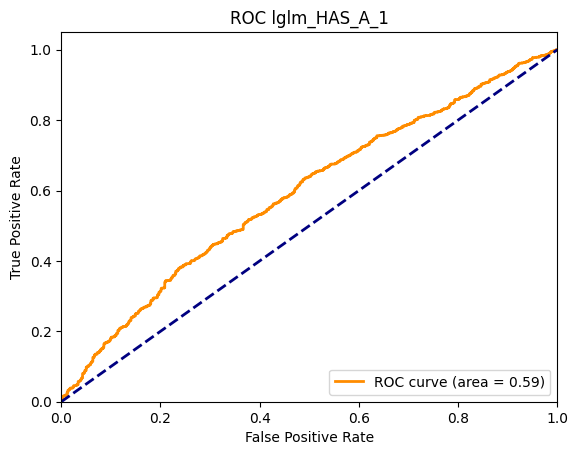

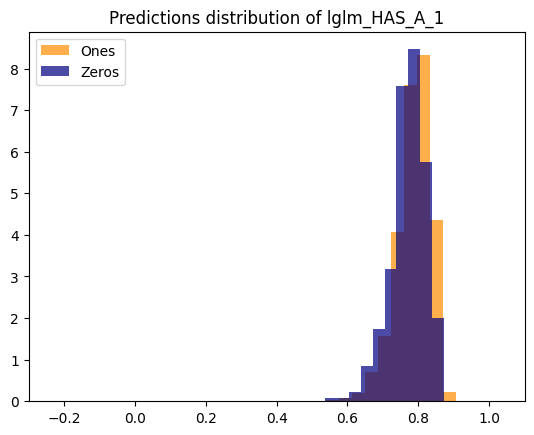

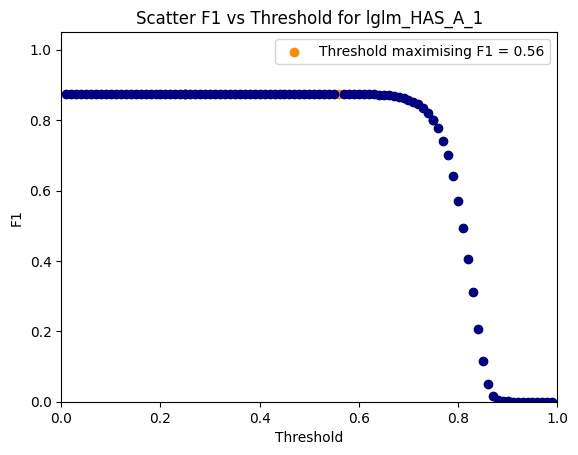

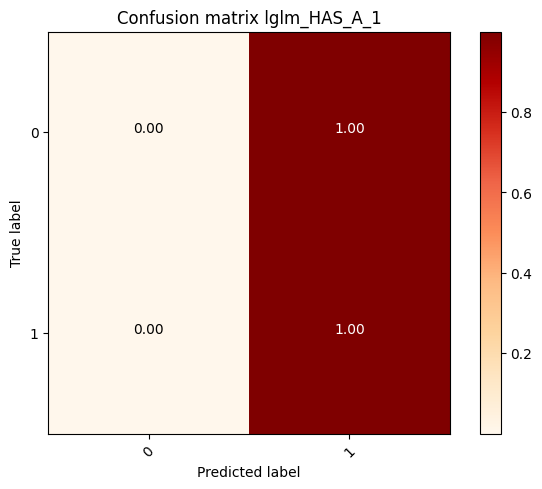

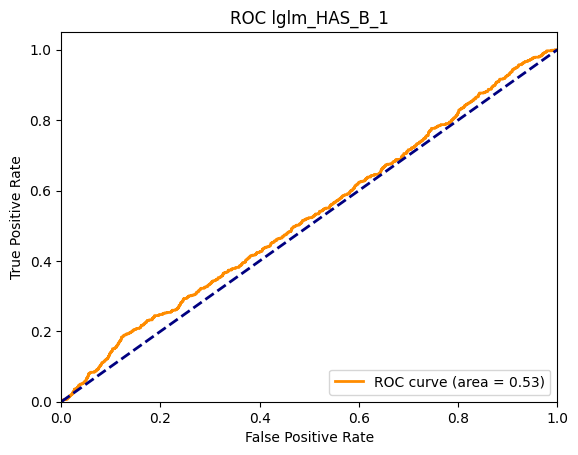

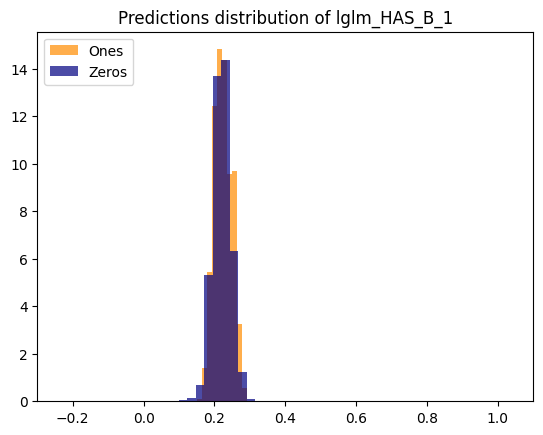

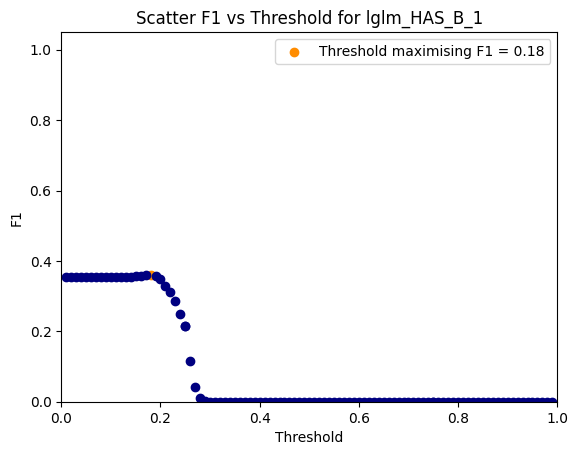

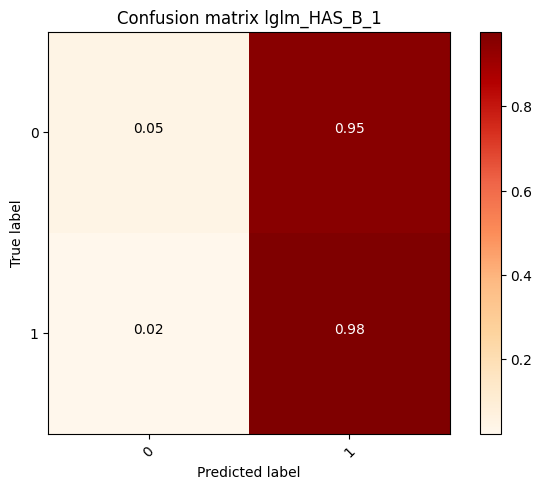

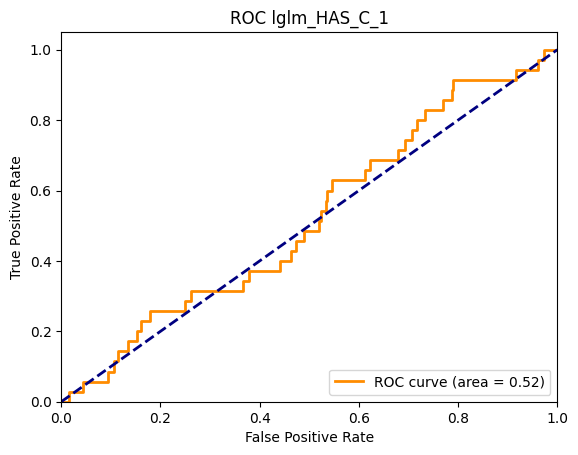

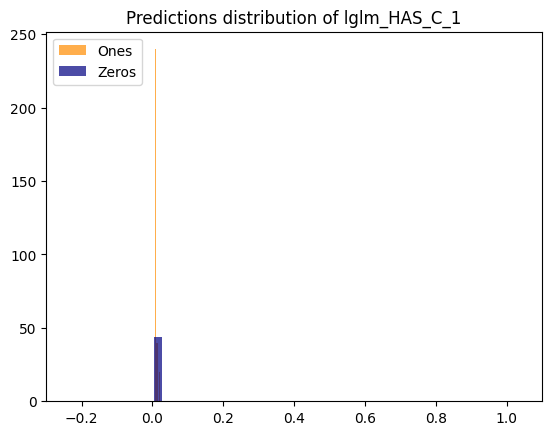

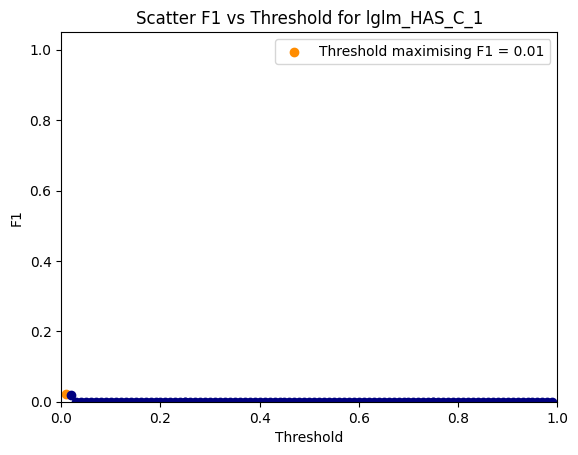

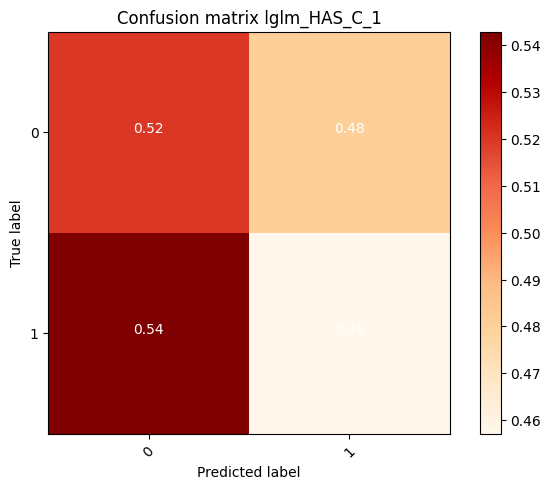

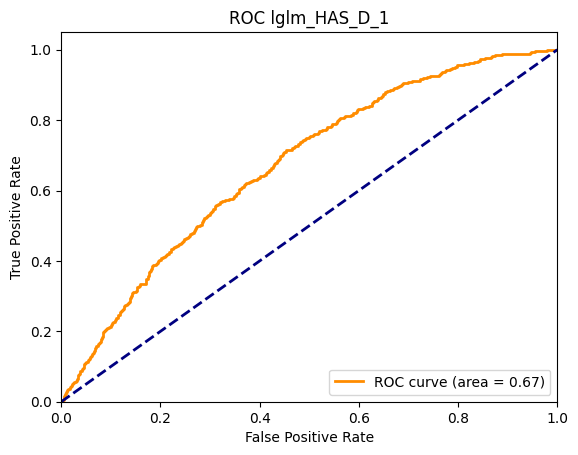

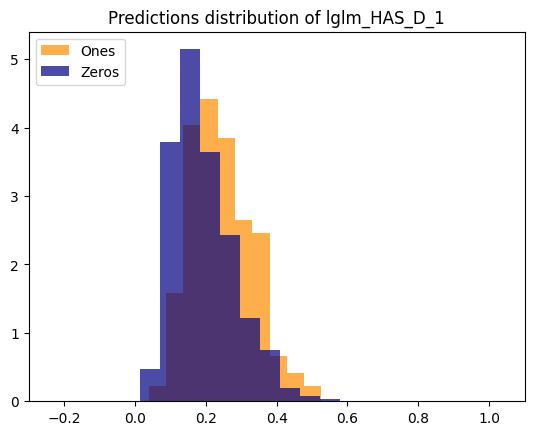

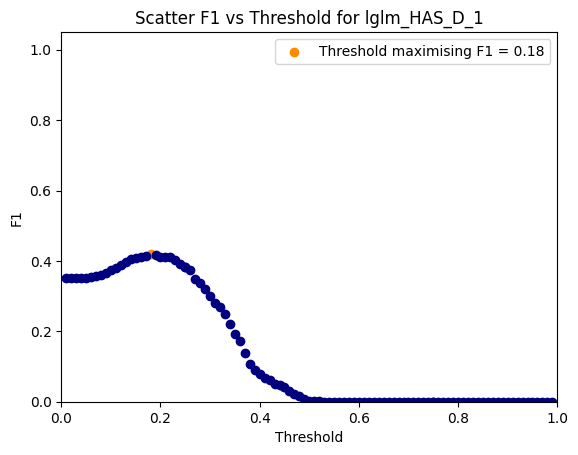

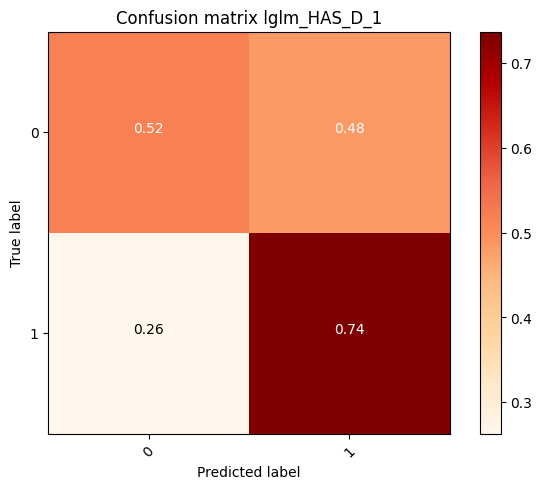

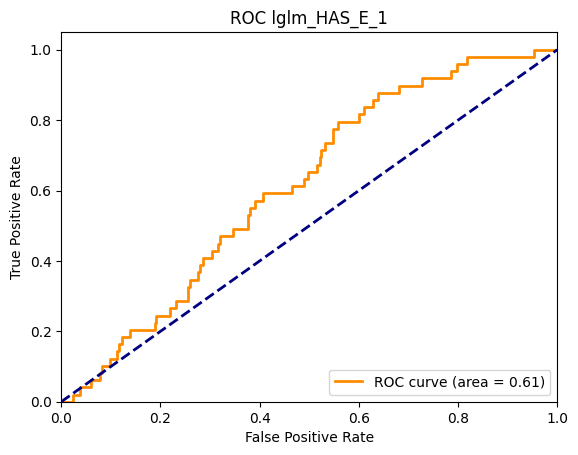

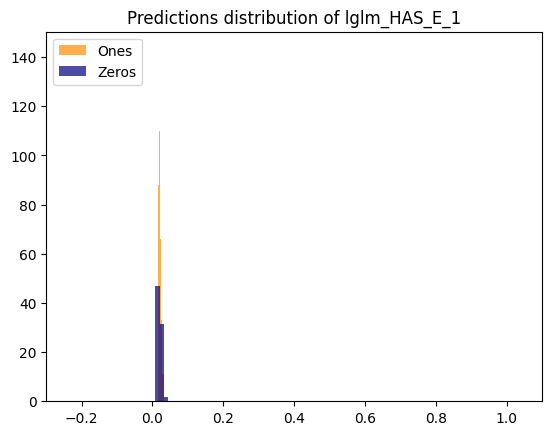

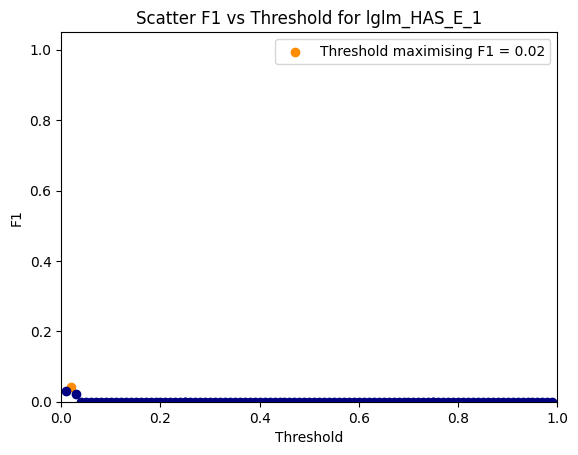

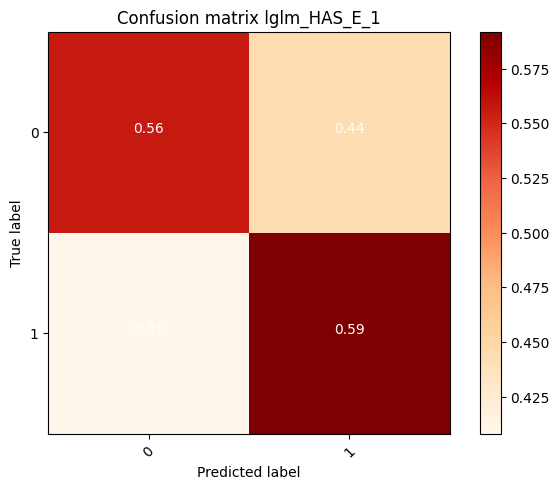

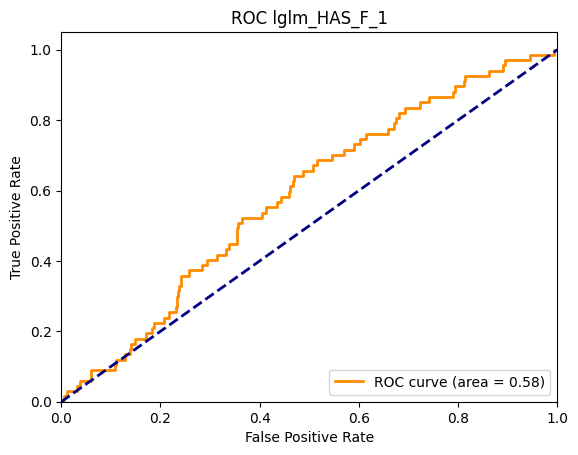

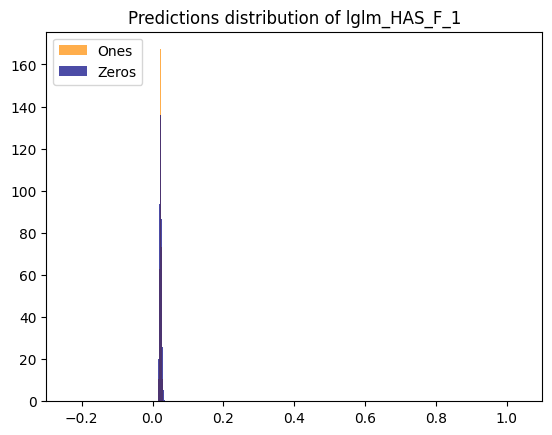

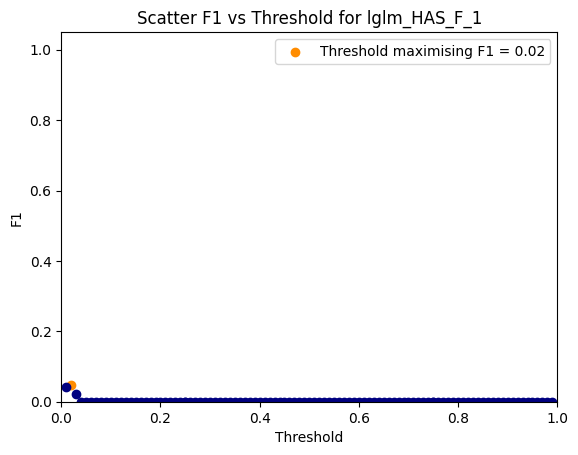

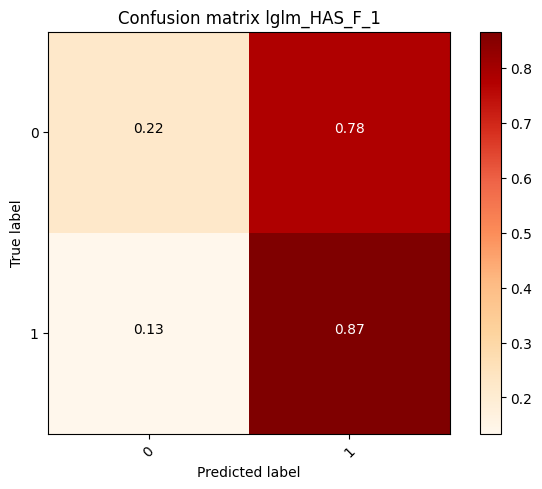

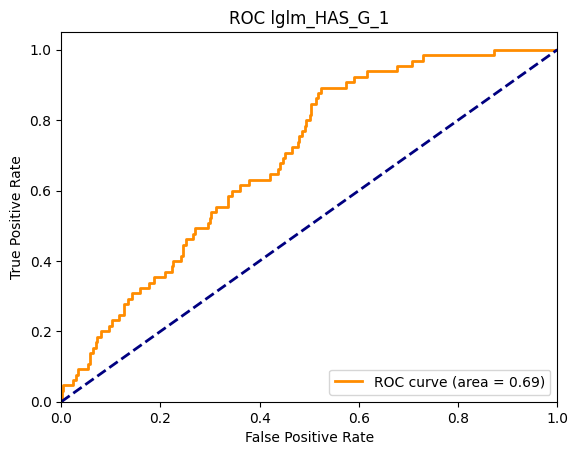

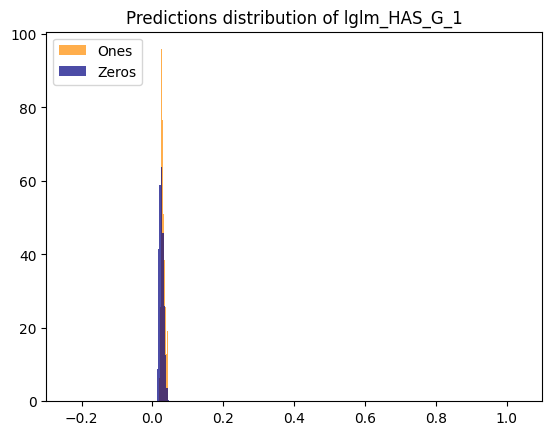

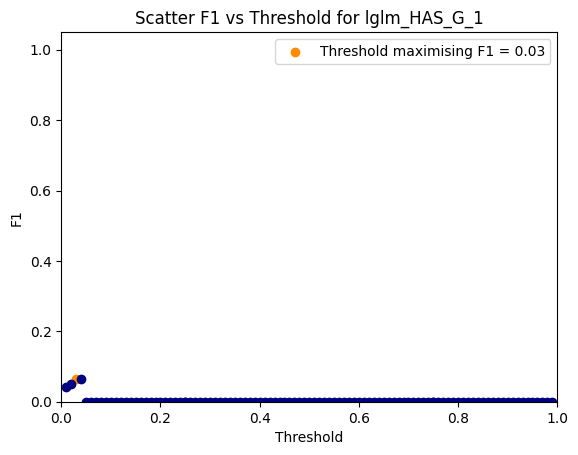

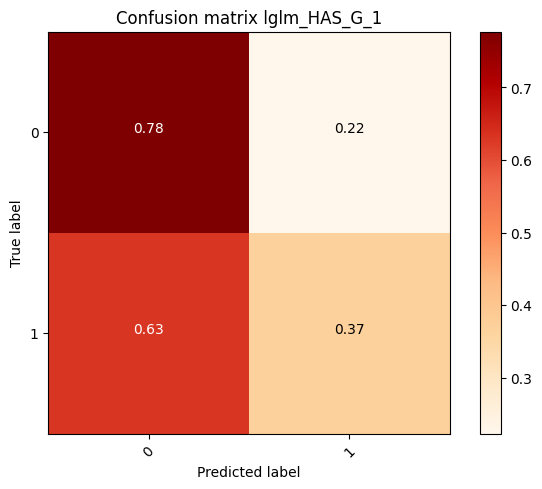

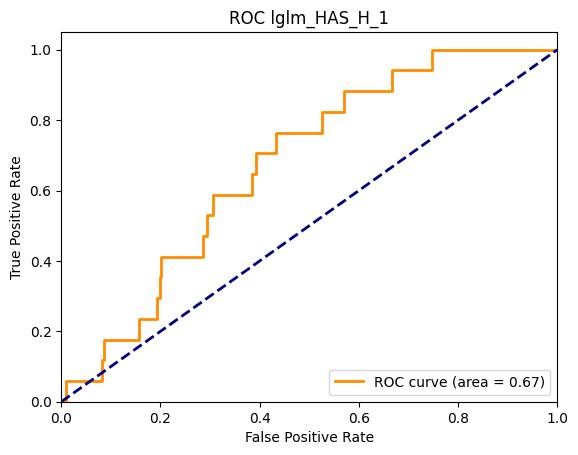

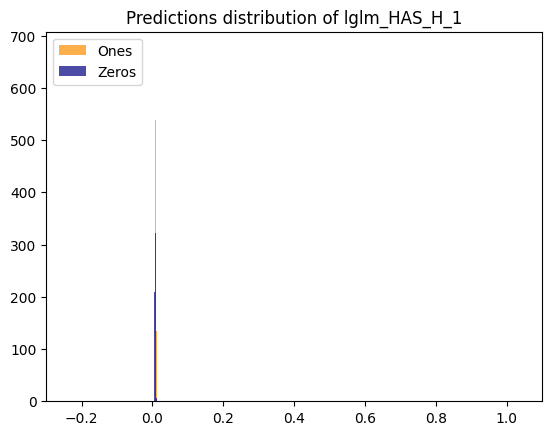

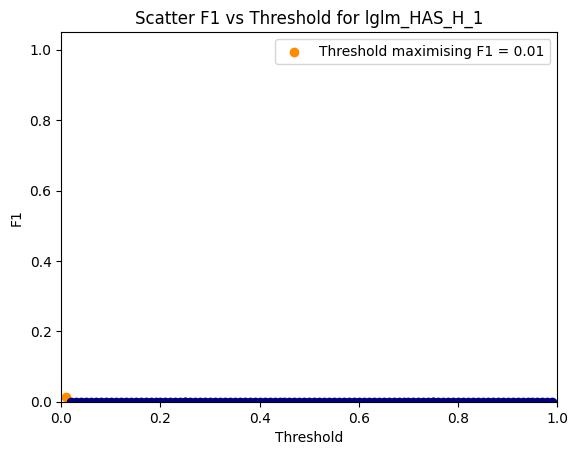

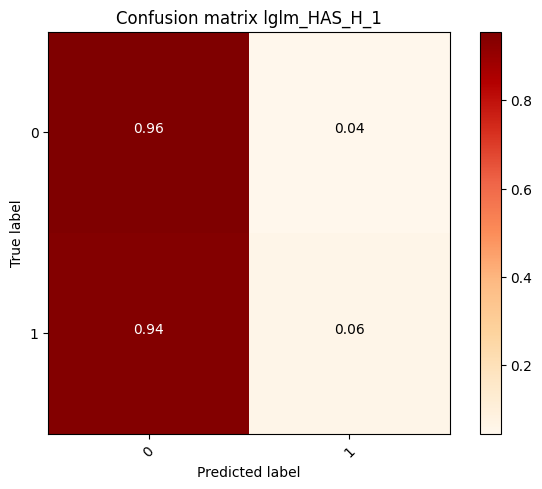

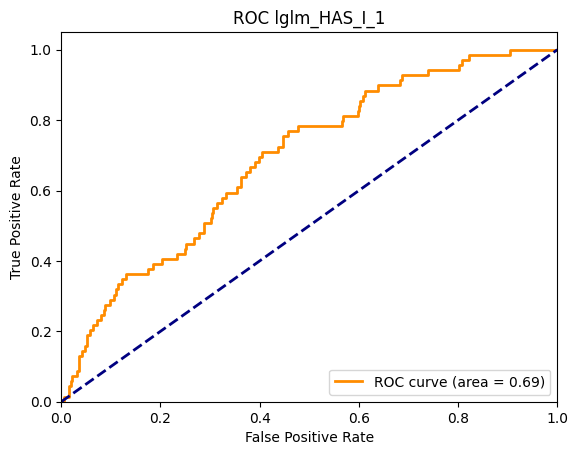

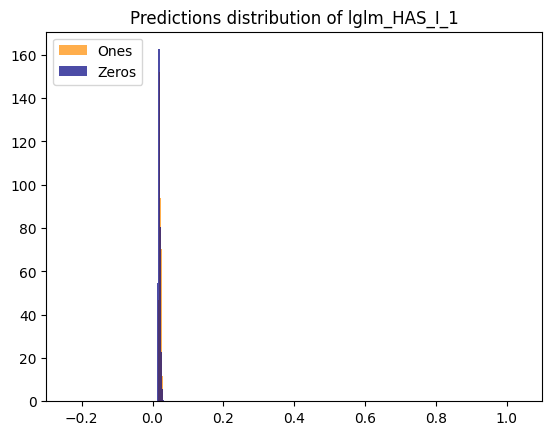

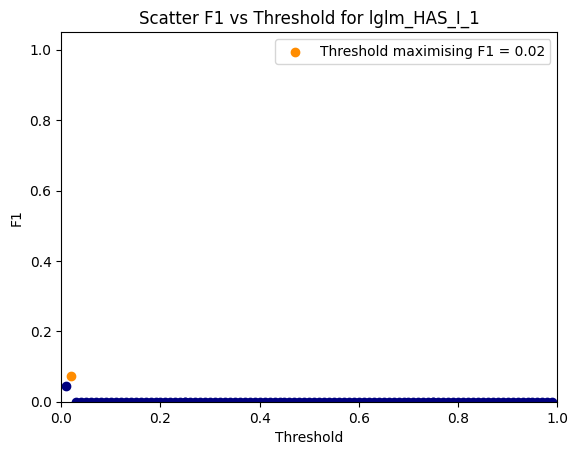

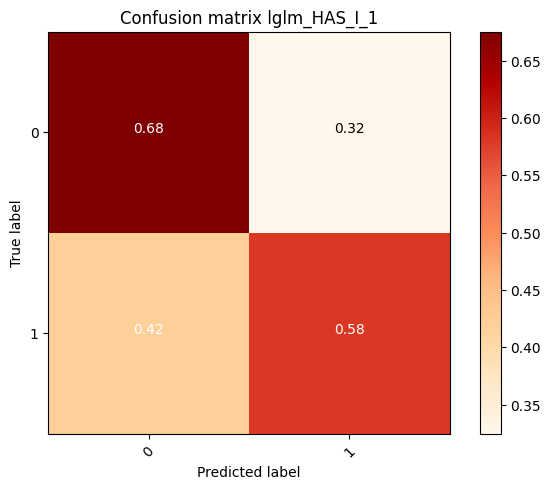

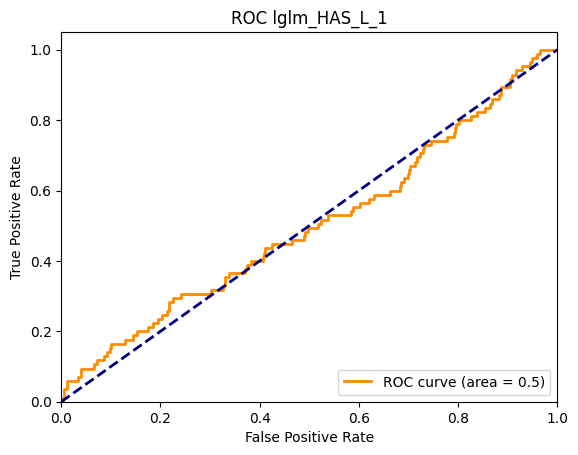

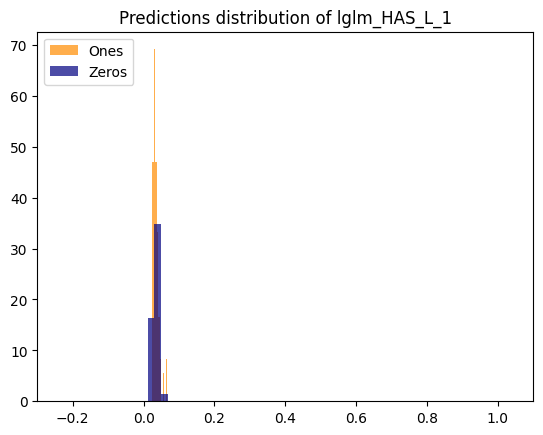

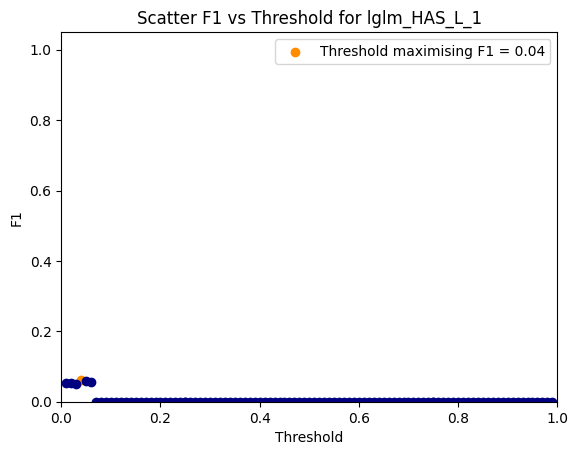

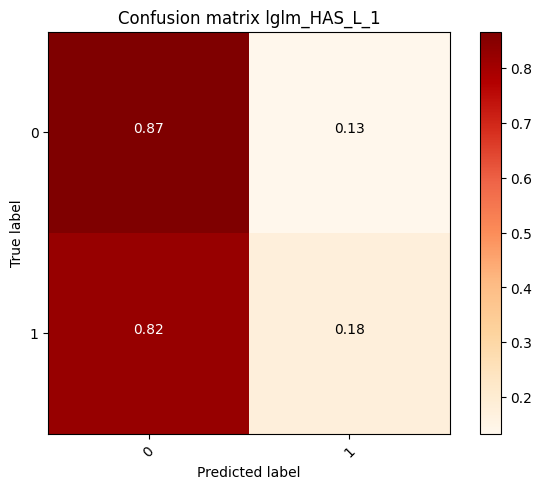

In [8]:
# Config
CONFIG_FOLDER = os.path.join("config")
CONFIG_FILE = "features.csv"
DATA_FOLDER = os.path.join("..", "sample_data")
DATA_FILE = "dataset.csv"
MODELS_FOLDER = os.path.join("models")
RESULTS_FOLDER = os.path.join("results")

MODEL_TYPE = "model"
TAG = "lglm"

PREDICTIONS_FILE = "_".join([MODEL_TYPE, TAG, "pred.csv"])

SAVE = True

# use an optimization method to find the best params
SEED = 17
param_grid = {
    'logreg__C': [0.1, 1, 10],  # Inverse of regularization strength
    'logreg__l1_ratio': [0.1, 0.5, 0.9],  # Elastic net mixing
}


if __name__ == "__main__":

    pmp = pm.PimpPlot(save=SAVE, folder=os.path.join(RESULTS_FOLDER, "plots"))

    # Load config
    source_config = os.path.join(CONFIG_FOLDER, CONFIG_FILE)
    features = pd.read_csv(source_config, keep_default_na=False, na_values=[""])
    index = features.loc[features[MODEL_TYPE] == "index", "column"].tolist()
    predictors = features.loc[features[MODEL_TYPE] == "predictor", "column"].tolist()
    labels = features.loc[features[MODEL_TYPE] == "label", "column"].tolist()
    categorical = features.loc[(features["categorical"] == 1) & (features["column"].isin(predictors)), "column"].tolist()
    numerical = features.loc[(features["numerical"] == 1) & (features["column"].isin(predictors)), "column"].tolist()

    # Load data
    source_file = os.path.join(DATA_FOLDER, DATA_FILE)
    data = pd.read_csv(source_file, usecols=index+labels+predictors+["SET"],
                    sep=";", decimal=".", encoding="latin1",
                    keep_default_na = False, na_values = [""])

    # Preprocessing catboost
    group_categoricals_tail(data, categorical)

    for col in numerical:
        data[col + '_tercile'] = pd.qcut(data[col], 3, labels=["low", "mid", "high"])

    all_categoricals = categorical + [col + '_tercile' for col in numerical]
    data = pd.get_dummies(data, columns=all_categoricals, drop_first=True)

    # Split the dataset
    indexes = {"train": None, "valid": None, "test": None}
    for set_name in indexes.keys():
        indexes[set_name] = np.where(data["SET"] == set_name)[0]

    # Get only relevant features
    lglm_features = [x for x in sorted(data.columns.tolist()) if x not in labels + index + ["SET"]]

    # catboost
    d = {}
    for set_name, set_indexes in indexes.items():
        d[set_name] = data.loc[set_indexes, lglm_features].values

    predictions = {}
    for label in labels:
        print("----------------------------", end="\n")
        print(label, end="\n")
        print("----------------------------", end="\n\n")
        
        print("Creating the Dataset...")
        y = {}
        for set_name, set_indexes in indexes.items():
            y[set_name] = data.loc[set_indexes, label].astype(int).values

        print("Done!", end="\n\n")
        print("Creating pipeline and grid search...")

        
        # Subset DataFrame for GLM input
        # Combine train and validation sets
        trainval_idx = np.concatenate([indexes["train"], indexes["valid"]])
        X_trainval = data.loc[trainval_idx, lglm_features]
        y_trainval = data.loc[trainval_idx, label]

        X_test = data.loc[indexes["test"], lglm_features]
        y_test = data.loc[indexes["test"], label]

        # Define pipeline
        pipe = Pipeline([
            ('logreg', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000))
        ])

        # Define your grid search parameters
        param_grid = {
            'logreg__C': [0.1, 1, 10],
            'logreg__l1_ratio': [0.1, 0.5, 0.9],
        }

        # Grid search
        grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
        grid.fit(X_trainval, y_trainval)

        # Best model
        best_model = grid.best_estimator_

        # Predict on test
        probs = best_model.predict_proba(X_test)[:, 1]
        threshold_preds = (probs > 0.5).astype(int)

        auc_score = roc_auc_score(y["test"], probs)
        accuracy = accuracy_score(y["test"], threshold_preds)
        precision = precision_score(y["test"], threshold_preds)
        recall = recall_score(y["test"], threshold_preds)
        pr_auc = average_precision_score(y["test"], probs)
        f2_score = fbeta_score(y["test"], threshold_preds, beta=2)
        
        print(f"AUC {label}: {auc_score:.4f}")
        print(f"Accuracy {label}: {accuracy:.4f}")
        print(f"Precision {label}: {precision:.4f}")
        print(f"Recall {label}: {recall:.4f}")
        print(f"PR_AUC {label}: {pr_auc:.4f}")
        print(f"F2-Score {label}: {f2_score:.4f}")
        
        # Plotting
        title = "_".join([TAG, label]) if TAG else label
        pmp.plot_roc(y["test"], probs, title)
        pmp.plot_distributions(y["test"], probs, title)
        threshold = pmp.find_threshold_max_f1(y["test"], probs, title, N=100)
        binary_predictions = np.where(probs >= threshold, 1, 0)
        pmp.plot_confusion_matrix(y["test"], binary_predictions, [0, 1], title)
        print("Done!\n")

        if SAVE:
            print("Saving model...")
            import joblib
            joblib.dump(pipe, os.path.join(MODELS_FOLDER, title + ".joblib"))
            print("Done!\n")

    # Save predictions
    predictions = pd.DataFrame(predictions)
    predictions.to_csv(os.path.join(RESULTS_FOLDER, PREDICTIONS_FILE), sep=";", index=False)

### Table 11: Machine Learning Models

#### Category Boost

----------------------------
HAS_A_1
----------------------------

Creating the Dataset...
Done!

Training catboost...
0:	learn: 0.6577833	test: 0.6584092	best: 0.6584092 (0)	total: 189ms	remaining: 9m 27s
1:	learn: 0.6239661	test: 0.6251338	best: 0.6251338 (1)	total: 222ms	remaining: 5m 32s
2:	learn: 0.6012833	test: 0.6018361	best: 0.6018361 (2)	total: 257ms	remaining: 4m 16s
3:	learn: 0.5844069	test: 0.5847496	best: 0.5847496 (3)	total: 267ms	remaining: 3m 19s
4:	learn: 0.5681141	test: 0.5686539	best: 0.5686539 (4)	total: 300ms	remaining: 2m 59s
5:	learn: 0.5558050	test: 0.5562980	best: 0.5562980 (5)	total: 331ms	remaining: 2m 45s
6:	learn: 0.5436501	test: 0.5453221	best: 0.5453221 (6)	total: 367ms	remaining: 2m 37s
7:	learn: 0.5364318	test: 0.5379440	best: 0.5379440 (7)	total: 378ms	remaining: 2m 21s
8:	learn: 0.5297076	test: 0.5320928	best: 0.5320928 (8)	total: 410ms	remaining: 2m 16s
9:	learn: 0.5254281	test: 0.5275590	best: 0.5275590 (9)	total: 422ms	remaining: 2m 6s
10:	learn: 0

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC HAS_B_1: 0.5798
Accuracy HAS_B_1: 0.7844
Precision HAS_B_1: 0.0000
Recall HAS_B_1: 0.0000
PR_AUC HAS_B_1: 0.2791
F2-Score HAS_B_1: 0.0000
Done!

Saving...
Done!

----------------------------
HAS_C_1
----------------------------

Creating the Dataset...
Done!

Training catboost...
0:	learn: 0.4948267	test: 0.4933500	best: 0.4933500 (0)	total: 29.2ms	remaining: 1m 27s
1:	learn: 0.3621443	test: 0.3594733	best: 0.3594733 (1)	total: 35ms	remaining: 52.4s
2:	learn: 0.2697144	test: 0.2661376	best: 0.2661376 (2)	total: 64.4ms	remaining: 1m 4s
3:	learn: 0.2083477	test: 0.2038696	best: 0.2038696 (3)	total: 93.3ms	remaining: 1m 9s
4:	learn: 0.1652236	test: 0.1598876	best: 0.1598876 (4)	total: 117ms	remaining: 1m 10s
5:	learn: 0.1358460	test: 0.1296841	best: 0.1296841 (5)	total: 125ms	remaining: 1m 2s
6:	learn: 0.1158194	test: 0.1090275	best: 0.1090275 (6)	total: 138ms	remaining: 58.8s
7:	learn: 0.1009168	test: 0.0936744	best: 0.0936744 (7)	total: 185ms	remaining: 1m 9s
8:	learn: 0.0907114	tes

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Done!

Saving...
Done!

----------------------------
HAS_D_1
----------------------------

Creating the Dataset...
Done!

Training catboost...
0:	learn: 0.6407016	test: 0.6457477	best: 0.6457477 (0)	total: 27.6ms	remaining: 1m 22s
1:	learn: 0.6109288	test: 0.6165465	best: 0.6165465 (1)	total: 38.5ms	remaining: 57.7s
2:	learn: 0.5781545	test: 0.5853410	best: 0.5853410 (2)	total: 72ms	remaining: 1m 11s
3:	learn: 0.5562955	test: 0.5651931	best: 0.5651931 (3)	total: 86.4ms	remaining: 1m 4s
4:	learn: 0.5327646	test: 0.5446465	best: 0.5446465 (4)	total: 120ms	remaining: 1m 11s
5:	learn: 0.5141062	test: 0.5285785	best: 0.5285785 (5)	total: 149ms	remaining: 1m 14s
6:	learn: 0.4998098	test: 0.5168060	best: 0.5168060 (6)	total: 204ms	remaining: 1m 27s
7:	learn: 0.4898921	test: 0.5079088	best: 0.5079088 (7)	total: 226ms	remaining: 1m 24s
8:	learn: 0.4826427	test: 0.5004915	best: 0.5004915 (8)	total: 240ms	remaining: 1m 19s
9:	learn: 0.4749726	test: 0.4942379	best: 0.4942379 (9)	total: 270ms	remai

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC HAS_E_1: 0.7227
Accuracy HAS_E_1: 0.9839
Precision HAS_E_1: 0.0000
Recall HAS_E_1: 0.0000
PR_AUC HAS_E_1: 0.0530
F2-Score HAS_E_1: 0.0000
Done!

Saving...
Done!

----------------------------
HAS_F_1
----------------------------

Creating the Dataset...
Done!

Training catboost...
0:	learn: 0.5332048	test: 0.5297609	best: 0.5297609 (0)	total: 31.5ms	remaining: 1m 34s
1:	learn: 0.4181456	test: 0.4110800	best: 0.4110800 (1)	total: 38.5ms	remaining: 57.6s
2:	learn: 0.3356049	test: 0.3247257	best: 0.3247257 (2)	total: 69ms	remaining: 1m 8s
3:	learn: 0.2760865	test: 0.2623640	best: 0.2623640 (3)	total: 84.1ms	remaining: 1m 2s
4:	learn: 0.2329505	test: 0.2169504	best: 0.2169504 (4)	total: 103ms	remaining: 1m 1s
5:	learn: 0.2023857	test: 0.1840856	best: 0.1840856 (5)	total: 111ms	remaining: 55.2s
6:	learn: 0.1801388	test: 0.1597611	best: 0.1597611 (6)	total: 130ms	remaining: 55.5s
7:	learn: 0.1625458	test: 0.1404149	best: 0.1404149 (7)	total: 142ms	remaining: 53.2s
8:	learn: 0.1504220	test

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lwstr\OneDrive\Documents\GitHub\recsysReplication\supervised\utils\pimpmatplotlib.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Done!

Saving...
Done!

----------------------------
HAS_G_1
----------------------------

Creating the Dataset...
Done!

Training catboost...
0:	learn: 0.5388388	test: 0.5354355	best: 0.5354355 (0)	total: 29.1ms	remaining: 1m 27s
1:	learn: 0.4275120	test: 0.4206376	best: 0.4206376 (1)	total: 34ms	remaining: 50.9s
2:	learn: 0.3401465	test: 0.3291411	best: 0.3291411 (2)	total: 64.3ms	remaining: 1m 4s
3:	learn: 0.2835137	test: 0.2698295	best: 0.2698295 (3)	total: 79.2ms	remaining: 59.3s
4:	learn: 0.2425557	test: 0.2261726	best: 0.2261726 (4)	total: 100ms	remaining: 59.9s
5:	learn: 0.2089685	test: 0.1901825	best: 0.1901825 (5)	total: 112ms	remaining: 55.8s
6:	learn: 0.1878355	test: 0.1671415	best: 0.1671415 (6)	total: 138ms	remaining: 58.9s
7:	learn: 0.1692655	test: 0.1467788	best: 0.1467788 (7)	total: 156ms	remaining: 58.5s
8:	learn: 0.1579785	test: 0.1339823	best: 0.1339823 (8)	total: 163ms	remaining: 54.2s
9:	learn: 0.1494391	test: 0.1240919	best: 0.1240919 (9)	total: 171ms	remaining: 

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Done!

Saving...
Done!

----------------------------
HAS_H_1
----------------------------

Creating the Dataset...
Done!

Training catboost...
0:	learn: 0.4869741	test: 0.4850494	best: 0.4850494 (0)	total: 29.6ms	remaining: 1m 28s
1:	learn: 0.3482289	test: 0.3442894	best: 0.3442894 (1)	total: 36ms	remaining: 53.9s
2:	learn: 0.2539802	test: 0.2479000	best: 0.2479000 (2)	total: 68.2ms	remaining: 1m 8s
3:	learn: 0.1920583	test: 0.1845392	best: 0.1845392 (3)	total: 85ms	remaining: 1m 3s
4:	learn: 0.1498200	test: 0.1408770	best: 0.1408770 (4)	total: 105ms	remaining: 1m 3s
5:	learn: 0.1209928	test: 0.1107110	best: 0.1107110 (5)	total: 117ms	remaining: 58.5s
6:	learn: 0.1012867	test: 0.0900164	best: 0.0900164 (6)	total: 151ms	remaining: 1m 4s
7:	learn: 0.0874978	test: 0.0752614	best: 0.0752614 (7)	total: 182ms	remaining: 1m 7s
8:	learn: 0.0776620	test: 0.0646164	best: 0.0646164 (8)	total: 191ms	remaining: 1m 3s
9:	learn: 0.0705931	test: 0.0568014	best: 0.0568014 (9)	total: 204ms	remaining: 1m

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Done!

Saving...
Done!

----------------------------
HAS_I_1
----------------------------

Creating the Dataset...
Done!

Training catboost...
0:	learn: 0.5249274	test: 0.5222744	best: 0.5222744 (0)	total: 28.8ms	remaining: 1m 26s
1:	learn: 0.4057042	test: 0.4005906	best: 0.4005906 (1)	total: 34.4ms	remaining: 51.6s
2:	learn: 0.3207735	test: 0.3137739	best: 0.3137739 (2)	total: 41.4ms	remaining: 41.4s
3:	learn: 0.2608605	test: 0.2518401	best: 0.2518401 (3)	total: 48.4ms	remaining: 36.2s
4:	learn: 0.2149433	test: 0.2049078	best: 0.2049078 (4)	total: 77.8ms	remaining: 46.6s
5:	learn: 0.1842435	test: 0.1728659	best: 0.1728659 (5)	total: 108ms	remaining: 53.7s
6:	learn: 0.1626057	test: 0.1498997	best: 0.1498997 (6)	total: 117ms	remaining: 50s
7:	learn: 0.1468374	test: 0.1328919	best: 0.1328919 (7)	total: 130ms	remaining: 48.7s
8:	learn: 0.1351419	test: 0.1200848	best: 0.1200848 (8)	total: 144ms	remaining: 47.7s
9:	learn: 0.1259539	test: 0.1101358	best: 0.1101358 (9)	total: 157ms	remaining:

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Done!

Saving...
Done!

----------------------------
HAS_L_1
----------------------------

Creating the Dataset...
Done!

Training catboost...
0:	learn: 0.5493730	test: 0.5502247	best: 0.5502247 (0)	total: 29.1ms	remaining: 1m 27s
1:	learn: 0.4444995	test: 0.4464304	best: 0.4464304 (1)	total: 34.8ms	remaining: 52.2s
2:	learn: 0.3674261	test: 0.3705436	best: 0.3705436 (2)	total: 42.4ms	remaining: 42.3s
3:	learn: 0.3114534	test: 0.3154560	best: 0.3154560 (3)	total: 51ms	remaining: 38.2s
4:	learn: 0.2651789	test: 0.2703742	best: 0.2703742 (4)	total: 82.2ms	remaining: 49.3s
5:	learn: 0.2317237	test: 0.2369078	best: 0.2369078 (5)	total: 100ms	remaining: 49.9s
6:	learn: 0.2103528	test: 0.2163204	best: 0.2163204 (6)	total: 111ms	remaining: 47.3s
7:	learn: 0.1924772	test: 0.1985867	best: 0.1985867 (7)	total: 118ms	remaining: 44.3s
8:	learn: 0.1777536	test: 0.1843095	best: 0.1843095 (8)	total: 149ms	remaining: 49.5s
9:	learn: 0.1691907	test: 0.1762611	best: 0.1762611 (9)	total: 154ms	remaining:

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Done!

Saving...
Done!



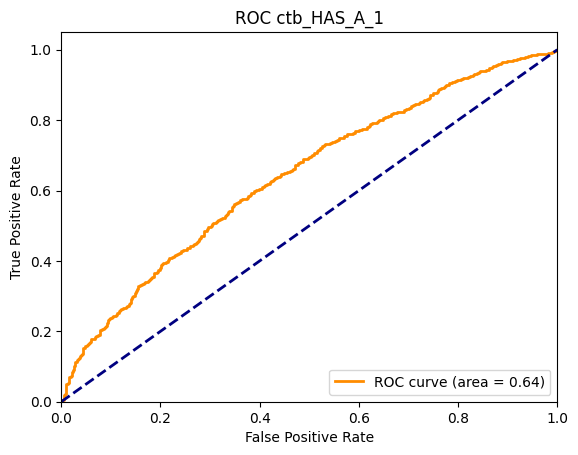

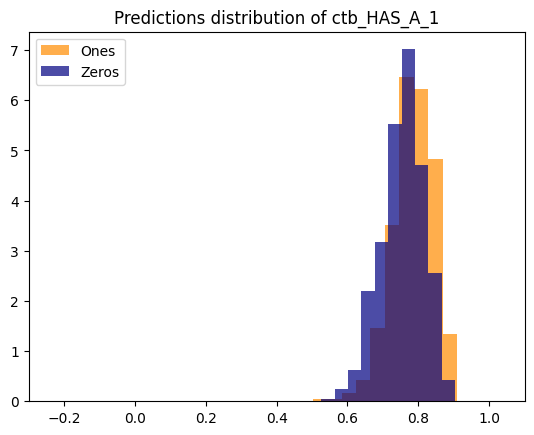

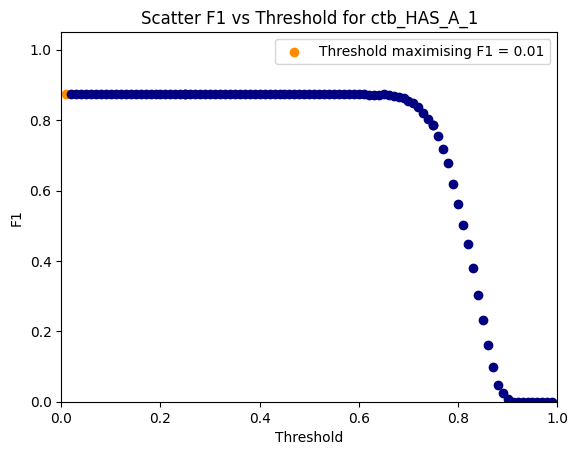

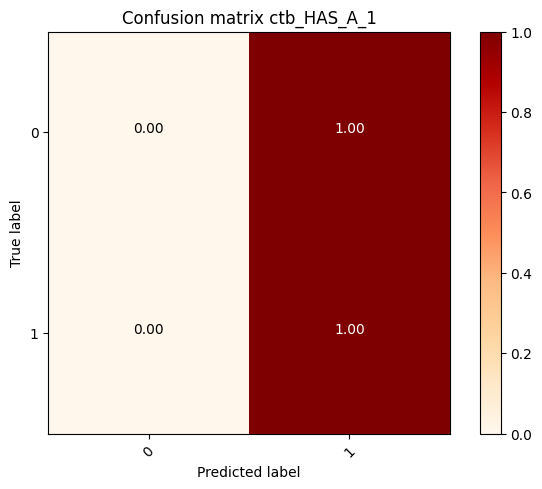

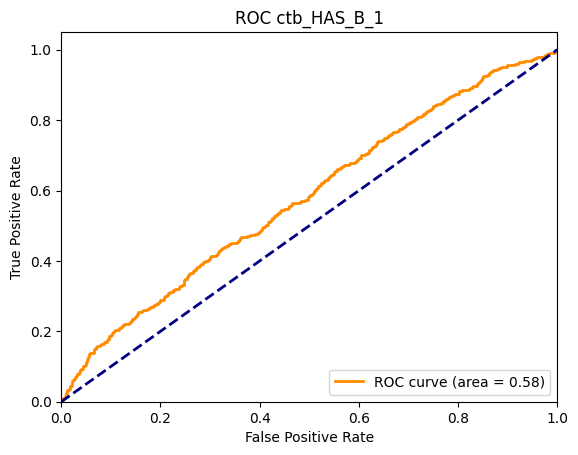

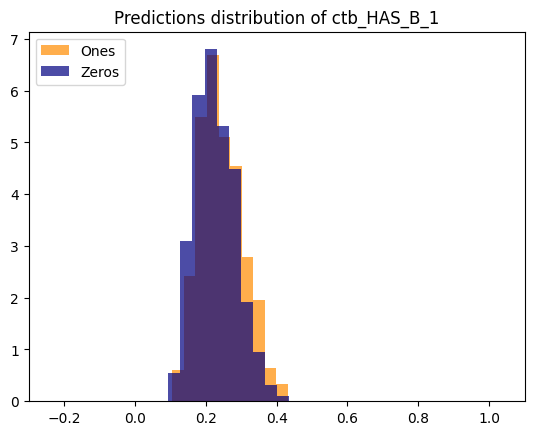

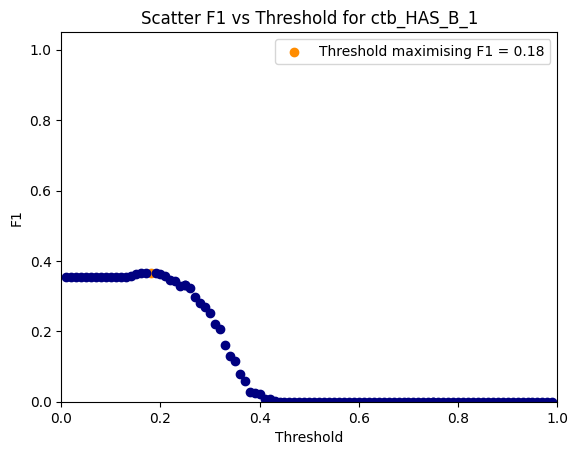

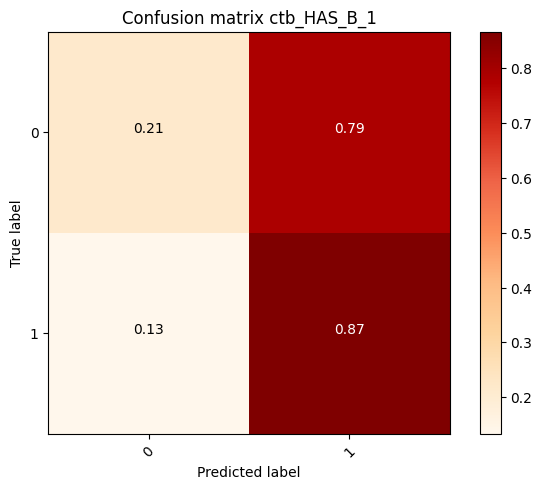

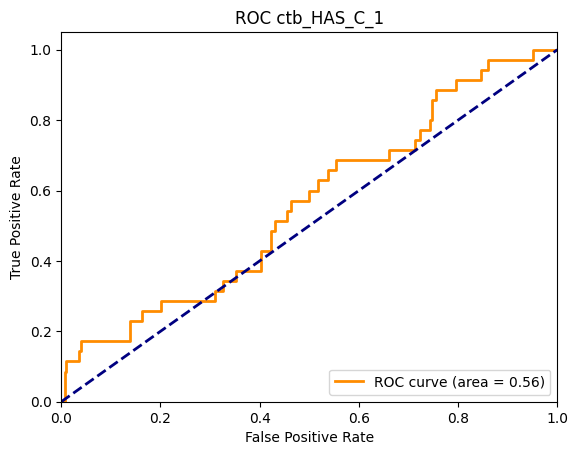

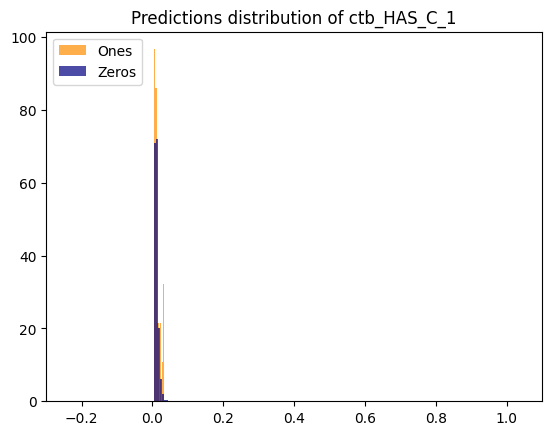

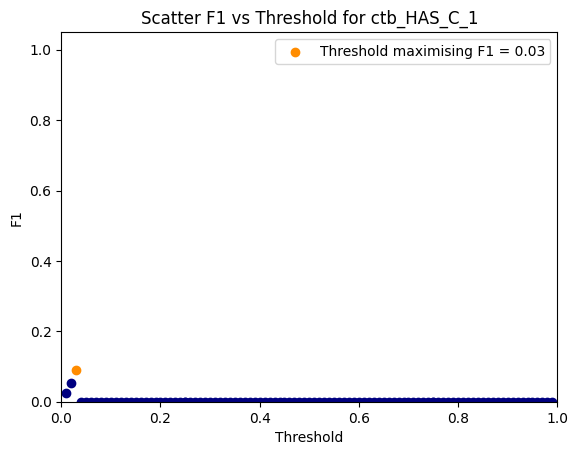

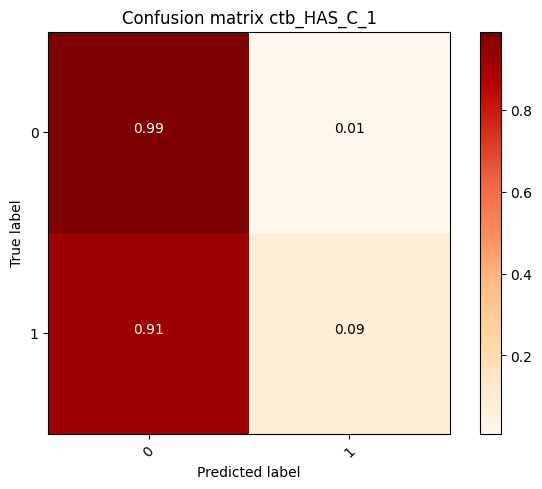

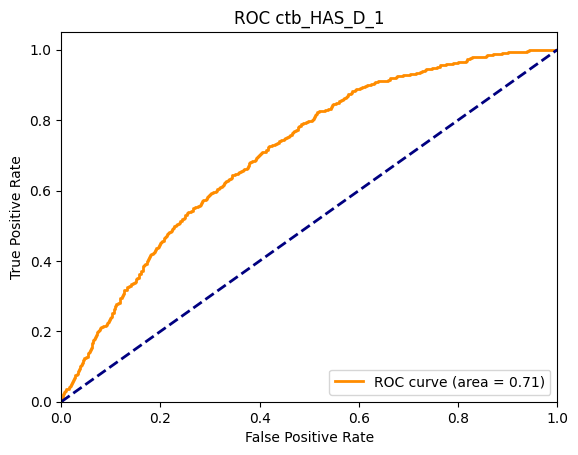

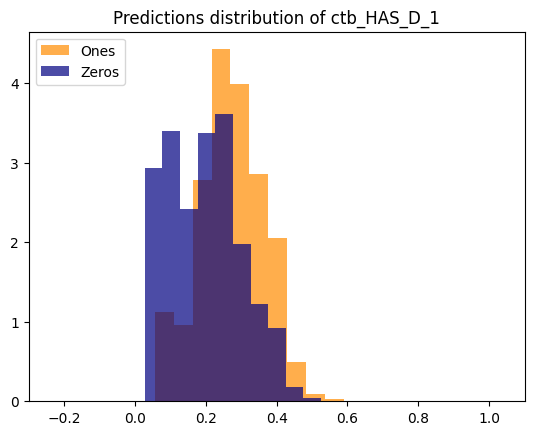

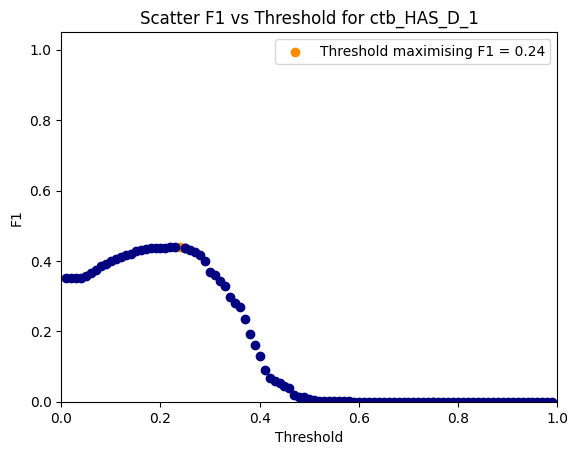

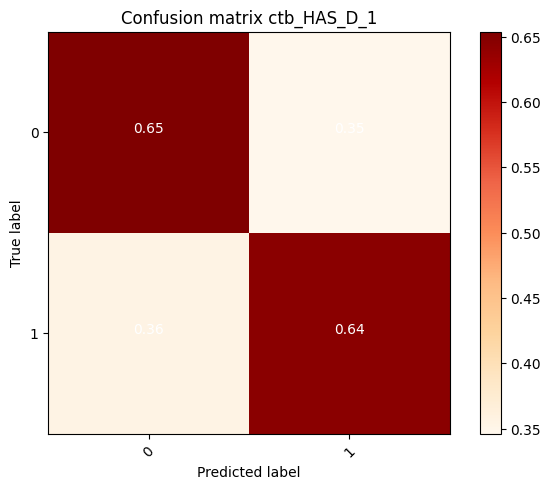

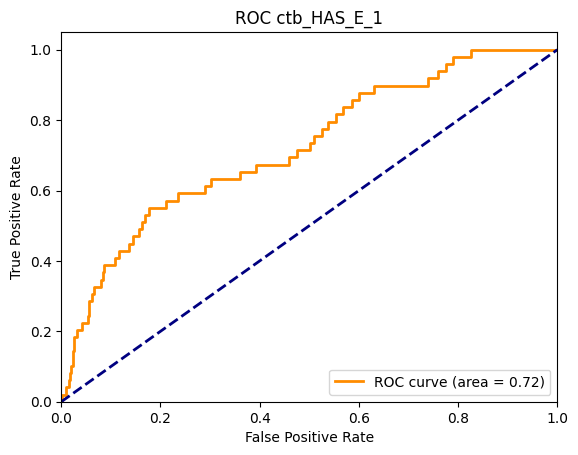

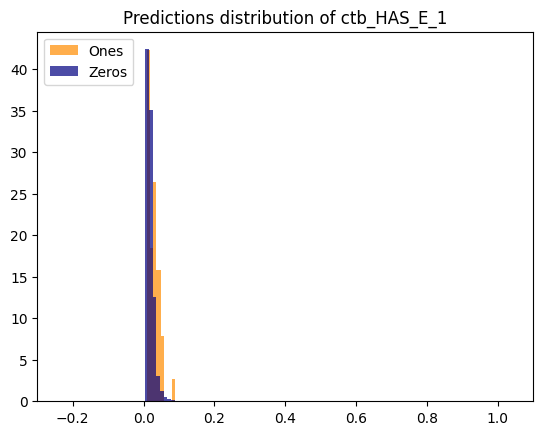

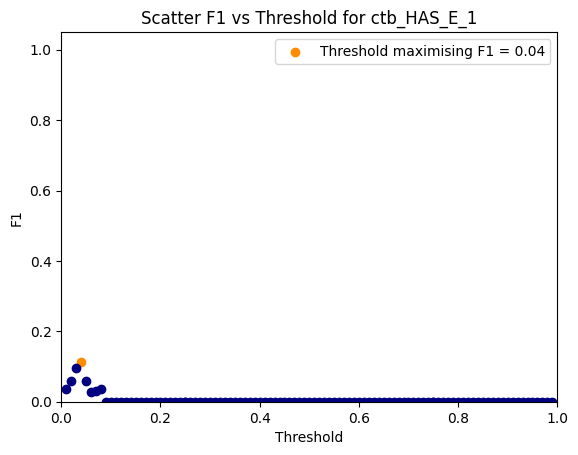

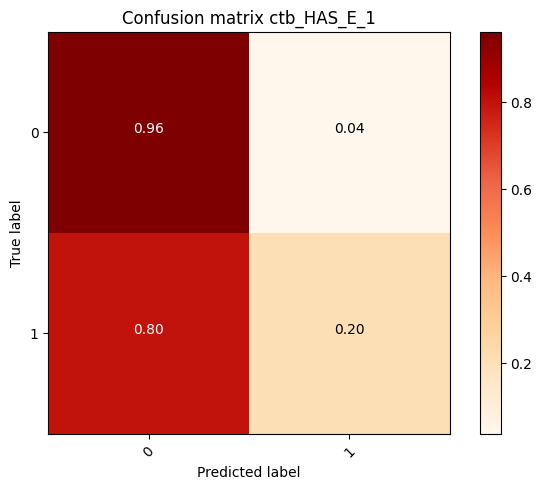

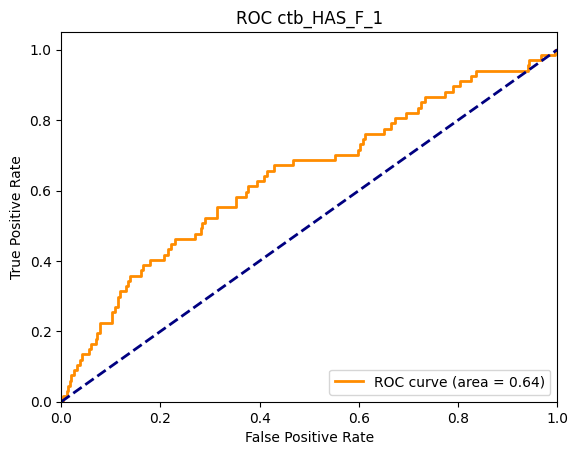

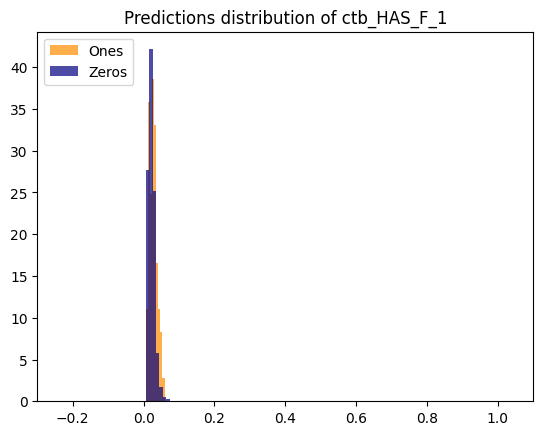

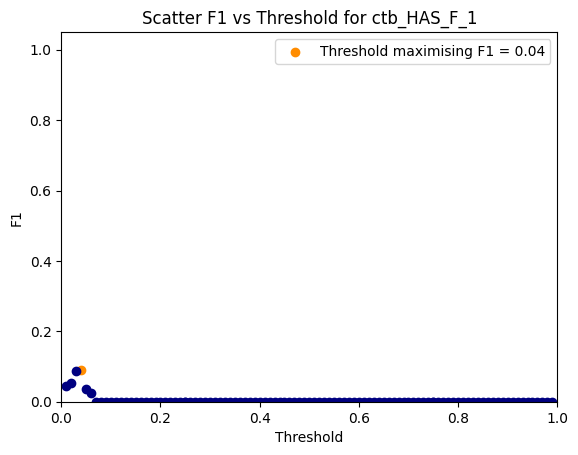

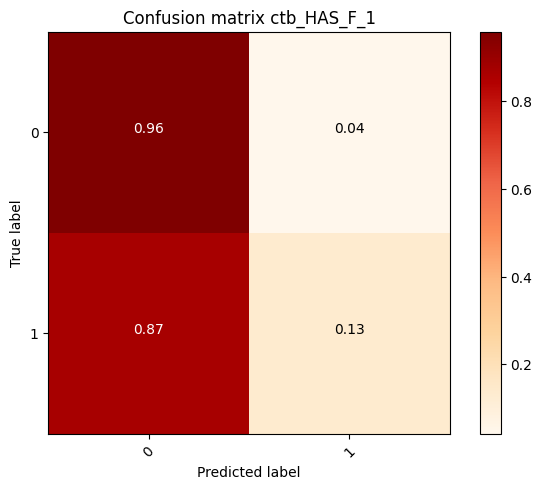

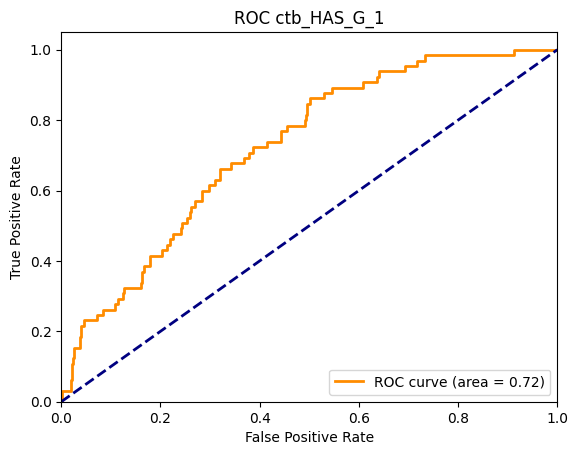

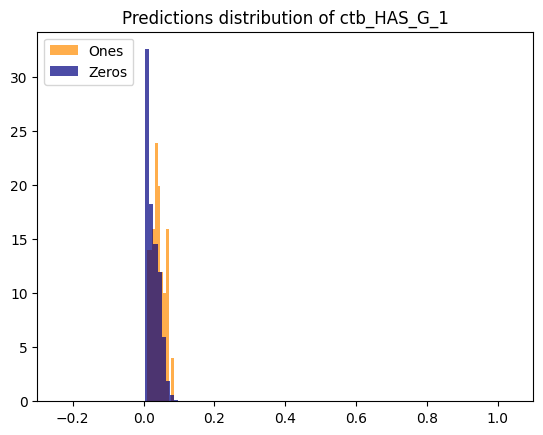

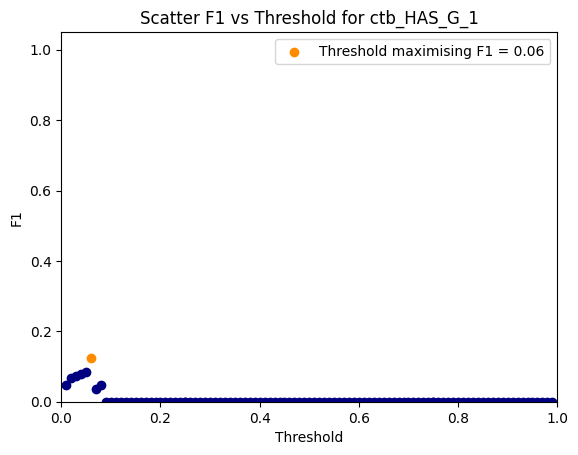

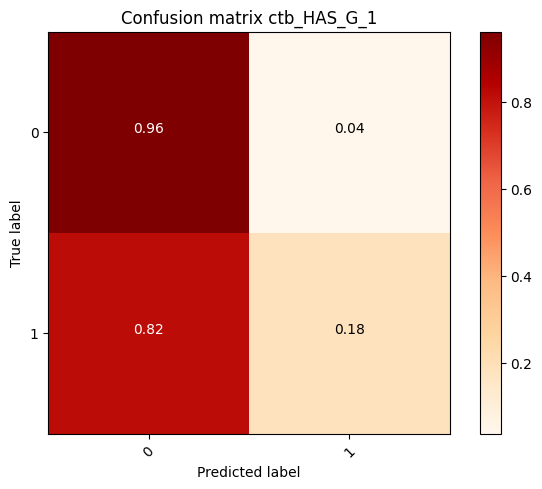

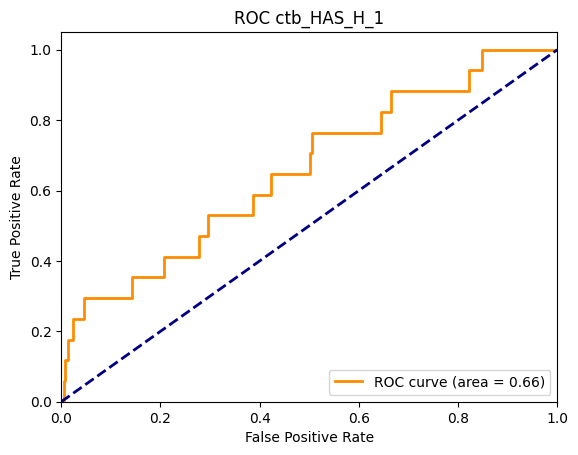

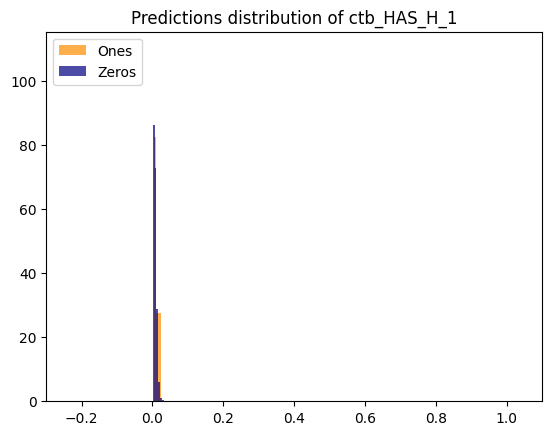

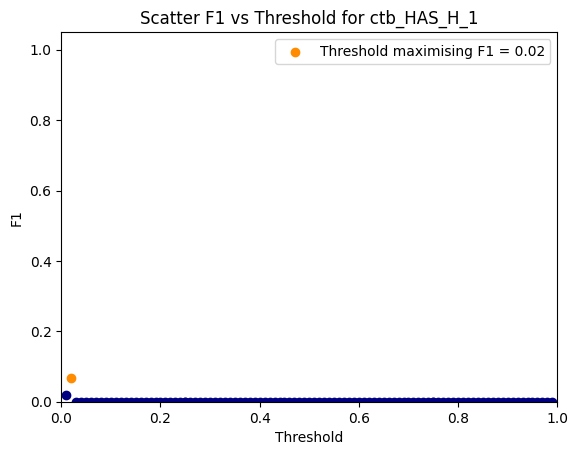

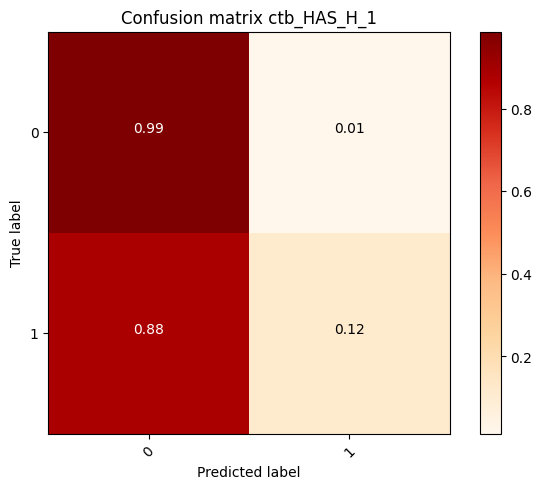

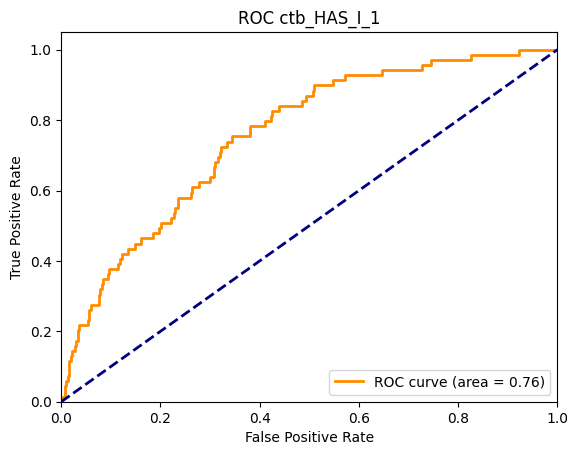

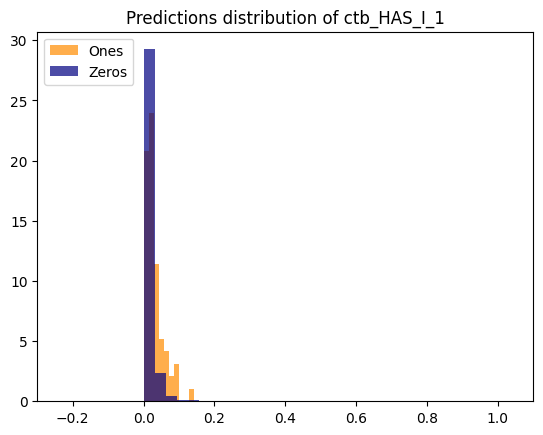

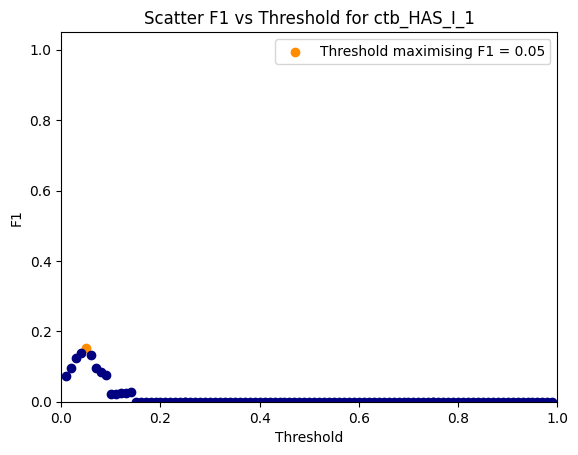

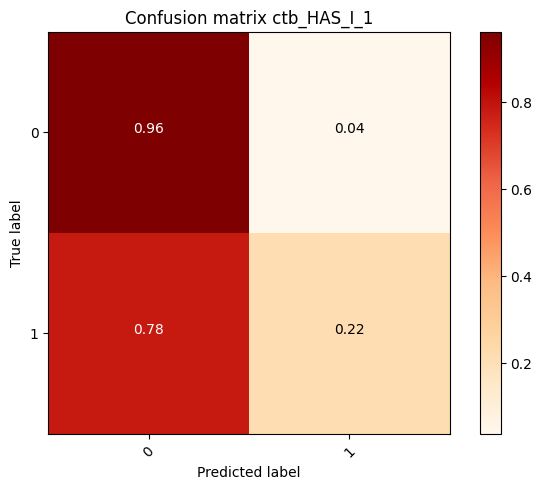

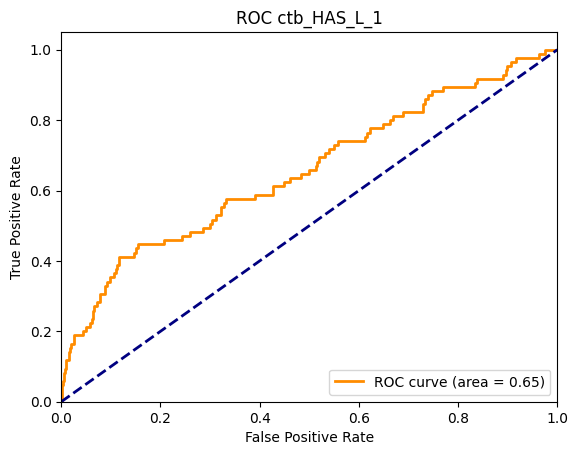

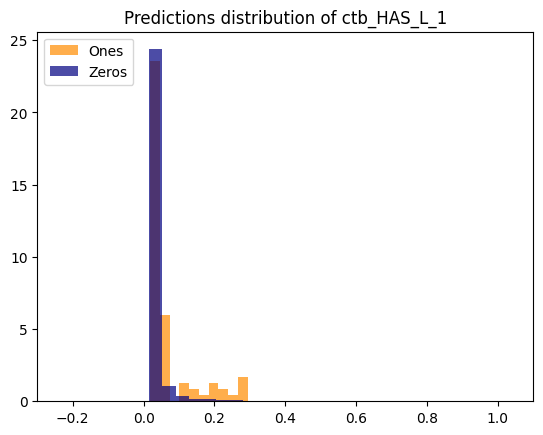

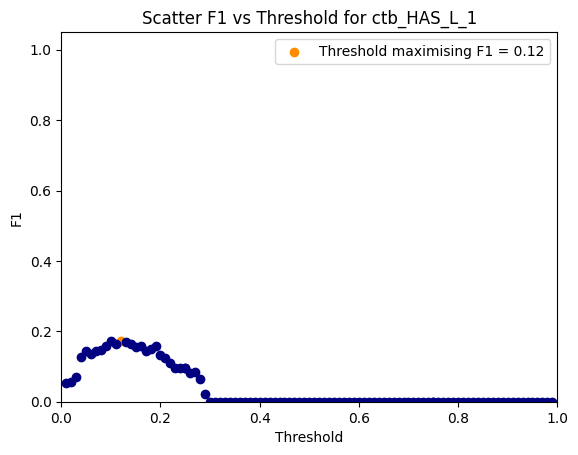

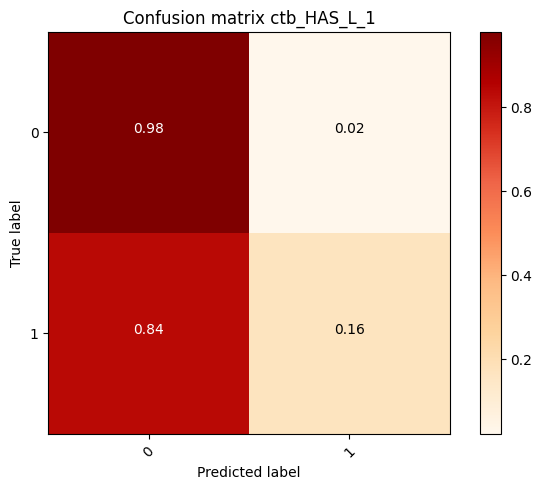

In [6]:
# Config
CONFIG_FOLDER = os.path.join("config")
CONFIG_FILE = "features.csv"
DATA_FOLDER = os.path.join("..", "sample_data")
DATA_FILE = "dataset.csv"
MODELS_FOLDER = os.path.join("models")
RESULTS_FOLDER = os.path.join("results")

MODEL_TYPE = "model"
TAG = "ctb"

PREDICTIONS_FILE = "_".join([MODEL_TYPE, TAG, "pred.csv"])

SAVE = True

# catboost params
# use an optimization method to find the best params
SEED = 17
CTB_PARAMS = {
    "random_seed": SEED,
    "num_boost_round": 3000, 
    "depth": 8, 
    "learning_rate": 0.1, 
    "loss_function": "Logloss",
    "logging_level": "Verbose",
    "early_stopping_rounds": 5,
}

if __name__ == "__main__":

    pmp = pm.PimpPlot(save=SAVE, folder=os.path.join(RESULTS_FOLDER, "plots"))

    # Load config
    source_config = os.path.join(CONFIG_FOLDER, CONFIG_FILE)
    features = pd.read_csv(source_config, keep_default_na=False, na_values=[""])
    index = features.loc[features[MODEL_TYPE] == "index", "column"].tolist()
    predictors = features.loc[features[MODEL_TYPE] == "predictor", "column"].tolist()
    labels = features.loc[features[MODEL_TYPE] == "label", "column"].tolist()
    categorical = features.loc[(features["categorical"] == 1) & (features["column"].isin(predictors)), "column"].tolist()

    # Load data
    source_file = os.path.join(DATA_FOLDER, DATA_FILE)
    data = pd.read_csv(source_file, usecols=index+labels+predictors+["SET"],
                    sep=";", decimal=".", encoding="latin1",
                    keep_default_na = False, na_values = [""])

    # Preprocessing catboost
    group_categoricals_tail(data, categorical)

    # Split the dataset
    indexes = {"train": None, "valid": None, "test": None}
    for set_name in indexes.keys():
        indexes[set_name] = np.where(data["SET"] == set_name)[0]

    # Get only relevant features
    ctb_features = [x for x in sorted(data.columns.tolist()) if x not in labels + index + ["SET"]]
    cat_features = [i for i, f in enumerate(ctb_features) if f in categorical]

    # catboost
    d = {}
    for set_name, set_indexes in indexes.items():
        d[set_name] = data.loc[set_indexes, ctb_features].values

    predictions = {}
    for label in labels:
        print("----------------------------", end="\n")
        print(label, end="\n")
        print("----------------------------", end="\n\n")
        
        print("Creating the Dataset...")
        y = {}
        for set_name, set_indexes in indexes.items():
            y[set_name] = data.loc[set_indexes, label].values

        print("Done!", end="\n\n")
        
        print("Training catboost...")
        model = CatBoostClassifier(**CTB_PARAMS)

        model.fit(d["train"], y["train"], 
                    cat_features=cat_features, 
                    eval_set=[(d["valid"], y["valid"])])
        print("Done!", end="\n\n")

        print("Predictions and plots CTB...")
        pred_label = "{0}_PRED_{1}".format(label, TAG.upper())
        predictions[pred_label] = model.predict_proba(d["test"])[:, 1]
        
        print("Logloss: {}".format(log_loss(y["test"], predictions[pred_label])), end="\n\n")

        threshold_preds = (predictions[pred_label] > 0.5).astype(int)

        auc_score = roc_auc_score(y["test"], predictions[pred_label])
        accuracy = accuracy_score(y["test"], threshold_preds)
        precision = precision_score(y["test"], threshold_preds)
        recall = recall_score(y["test"], threshold_preds)
        pr_auc = average_precision_score(y["test"], predictions[pred_label])
        f2_score = fbeta_score(y["test"], threshold_preds, beta=2)
        
        print(f"AUC {label}: {auc_score:.4f}")
        print(f"Accuracy {label}: {accuracy:.4f}")
        print(f"Precision {label}: {precision:.4f}")
        print(f"Recall {label}: {recall:.4f}")
        print(f"PR_AUC {label}: {pr_auc:.4f}")
        print(f"F2-Score {label}: {f2_score:.4f}")
        
        if TAG:
            title = "_".join([TAG, label])
        else:
            title = label
        pmp.plot_roc(y["test"], predictions[pred_label], title)
        pmp.plot_distributions(y["test"], predictions[pred_label], title)
        threshold = pmp.find_threshold_max_f1(y["test"], predictions[pred_label], title, N = 100)
        binary_predictions = np.where(predictions[pred_label] >= threshold, 1, 0)
        pmp.plot_confusion_matrix(y["test"], binary_predictions, [0, 1], title)
        print("Done!", end="\n\n")

        if SAVE:
            print("Saving...")
            model.save_model(os.path.join(MODELS_FOLDER, title + ".model"))
            print("Done!", end="\n\n")

    predictions = pd.DataFrame(predictions)
    predictions.to_csv(os.path.join(RESULTS_FOLDER, PREDICTIONS_FILE), sep=";", index=False)

#### Deep Learning (DL)

Using only CPU for computation.
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.6714 - val_loss: 0.6648 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5014 - val_loss: 0.5803 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2889 - val_loss: 0.4623 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2435 - val_loss: 0.4212 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2379 - val_loss: 0.4345 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2280 - val_loss: 0.4581 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2185 - val_loss: 0.4665 - learning_rate: 0.0010
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2128 - val_loss: 0.4625 - learning_rate: 1.0000e-04


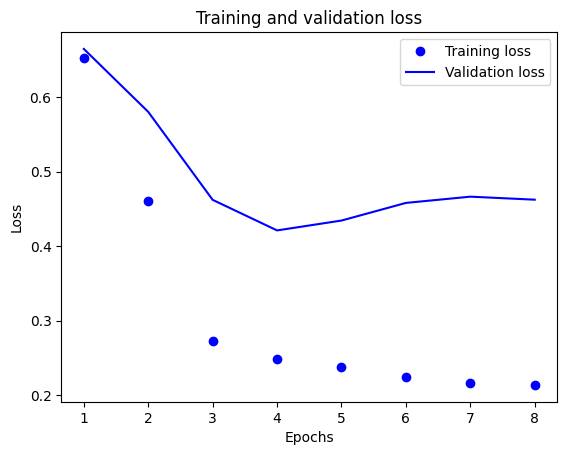

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC HAS_A_1: 0.6264
Accuracy HAS_A_1: 0.7785
Precision HAS_A_1: 0.7785
Recall HAS_A_1: 1.0000
PR_AUC HAS_A_1: 0.8480
F2-Score HAS_A_1: 0.9462
AUC HAS_B_1: 0.5487
Accuracy HAS_B_1: 0.2847
Precision HAS_B_1: 0.2226
Recall HAS_B_1: 0.9301
PR_AUC HAS_B_1: 0.2528
F2-Score HAS_B_1: 0.5687
AUC HAS_C_1: 0.6092
Accuracy HAS_C_1: 0.9613
Precision HAS_C_1: 0.0440
Recall HAS_C_1: 0.1143
PR_AUC HAS_C_1: 0.0234
F2-Score HAS_C_1: 0.0866
AUC HAS_D_1: 0.6684
Accuracy HAS_D_1: 0.4921
Precision HAS_D_1: 0.2796
Recall HAS_D_1: 0.8785
PR_AUC HAS_D_1: 0.3170
F2-Score HAS_D_1: 0.6150
AUC HAS_E_1: 0.6368
Accuracy HAS_E_1: 0.9194
Precision HAS_E_1: 0.0419
Recall HAS_E_1: 0.1837
PR_AUC HAS_E_1: 0.0332
F2-Score HAS_E_1: 0.1095


c:\Users\lwstr\OneDrive\Documents\GitHub\recsysReplication\supervised\utils\pimpmatplotlib.py:36: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



AUC HAS_F_1: 0.6012
Accuracy HAS_F_1: 0.7104
Precision HAS_F_1: 0.0342
Recall HAS_F_1: 0.4478
PR_AUC HAS_F_1: 0.0358
F2-Score HAS_F_1: 0.1310
AUC HAS_G_1: 0.5378
Accuracy HAS_G_1: 0.7212
Precision HAS_G_1: 0.0288
Recall HAS_G_1: 0.3692
PR_AUC HAS_G_1: 0.0303
F2-Score HAS_G_1: 0.1097
AUC HAS_H_1: 0.5964
Accuracy HAS_H_1: 0.9751
Precision HAS_H_1: 0.0317
Recall HAS_H_1: 0.1176
PR_AUC HAS_H_1: 0.0174
F2-Score HAS_H_1: 0.0763
AUC HAS_I_1: 0.6319
Accuracy HAS_I_1: 0.9099
Precision HAS_I_1: 0.0672
Recall HAS_I_1: 0.2319
PR_AUC HAS_I_1: 0.0447
F2-Score HAS_I_1: 0.1556
AUC HAS_L_1: 0.6817
Accuracy HAS_L_1: 0.9246
Precision HAS_L_1: 0.0994
Recall HAS_L_1: 0.2118
PR_AUC HAS_L_1: 0.0720
F2-Score HAS_L_1: 0.1727


In [ ]:
# Keras config
KERAS_BACKEND = "CPU"
NUM_CORES = 4

if KERAS_BACKEND == "CPU":
    num_CPU = 1
    num_GPU = 0
else:
    num_GPU = 1
    num_CPU = 1
    
# Restrict TensorFlow to only use CPU, not GPU
tf.config.set_visible_devices([], 'GPU')  # Hides the GPU if available

# Configuring the number of threads for CPU
tf.config.threading.set_intra_op_parallelism_threads(NUM_CORES)  # Set number of threads within an operation
tf.config.threading.set_inter_op_parallelism_threads(NUM_CORES)  # Set number of threads for operation parallelism

# Check if GPU is disabled
if not tf.config.list_physical_devices('GPU'):
    print("Using only CPU for computation.")
else:
    print("GPU is still available but will not be used.")

# Config
SEED = 17

CONFIG_FOLDER = os.path.join("config")
CONFIG_FILE = "features.csv"
DATA_FOLDER = os.path.join("..", "sample_data")
DATA_FILE = "dataset.csv"
MODELS_FOLDER = os.path.join("models")
RESULTS_FOLDER = os.path.join("results")

MODEL_TYPE = "model"
TAG = "ee"

PREDICTIONS_FILE = "_".join([MODEL_TYPE, TAG, "pred.csv"])

SAVE = True


if __name__ == "__main__":
    pmp = pm.PimpPlot(save=SAVE, folder=os.path.join(RESULTS_FOLDER, "plots"))

    # Load config
    source_config = os.path.join(CONFIG_FOLDER, CONFIG_FILE)
    features = pd.read_csv(source_config, keep_default_na=False, na_values=[""])
    index = features.loc[features[MODEL_TYPE] == "index", "column"].tolist()
    predictors = features.loc[features[MODEL_TYPE] == "predictor", "column"].tolist()
    labels = features.loc[features[MODEL_TYPE] == "label", "column"].tolist()
    binary = features.loc[(features["binary"] == 1) & (features["column"].isin(predictors)), "column"].tolist()
    numerical = features.loc[(features["numerical"] == 1) & (features["column"].isin(predictors)), "column"].tolist()
    categorical = features.loc[(features["categorical"] == 1) & (features["column"].isin(predictors)), "column"].tolist()

    # Load data
    source_file = os.path.join(DATA_FOLDER, DATA_FILE)
    data = pd.read_csv(source_file, usecols=index+labels+predictors+["SET"],
                    sep=";", decimal=".", encoding="latin1",
                    keep_default_na = False, na_values = [""])

    # Split the dataset
    indexes = {"train": None, "valid": None, "test": None}
    for set_name in indexes.keys():
        indexes[set_name] = np.where(data["SET"] == set_name)[0]

    # Create input datasets
    input_dict = {"train": {}, "valid": {}, "test": {}}

    # Preprocessing ann
    group_categoricals_tail(data, categorical)

    # Min Max scaling numerical variables
    columns = data.columns.tolist()
    for col in numerical:
        min_max_scaler = MinMaxScaler()
        data[col] = min_max_scaler.fit_transform(data[col].values.reshape(-1, 1))

    for set_name in input_dict.keys():
        input_dict[set_name]["numerical"] = data.loc[indexes[set_name], numerical].values

    # Label encoder categorical variables
    len_categorical = {}
    label_encoding = {}
    for col in categorical:
        unique_values = data[col].unique().tolist()
        len_categorical[col] = len(unique_values)
        label_encoding[col] = LabelEncoder()
        label_encoding[col].fit(sorted(unique_values))
        for set_name in input_dict.keys():
            input_dict[set_name][col] = label_encoding[col].transform(data.loc[indexes[set_name], col].values)

    # One-hot encoding over categoricals
    one_hot_data = pd.get_dummies(data[categorical], drop_first=True)

    for set_name in input_dict.keys():
        input_dict[set_name]["one_hot"] = one_hot_data.iloc[indexes[set_name], :]

    # Labels
    y = {
        "train": data.loc[indexes["train"], labels].values,
        "valid": data.loc[indexes["valid"], labels].values,
        "test": data.loc[indexes["test"], labels].values
    }

    # Keras model
    embedding_dim = {
        "DEMO_CAT_01": 3,
        "DEMO_CAT_02": 3,
        "DEMO_CAT_03": 3,
        "DEMO_CAT_04": 3,
        "DEMO_CAT_05": 3,
        "DEMO_CAT_06": 3,
        "DEMO_CAT_07": 3,
        "DEMO_CAT_08": 3,
        "DEMO_CAT_09": 3,
        "DEMO_CAT_10": 3,
        "DEMO_CAT_11": 3,
        "DEMO_CAT_12": 3,
        "DEMO_CAT_13": 3,
        "DEMO_CAT_14": 3,
        "DEMO_CAT_15": 3
    }

    # Embedding
    input_DEMO_CAT_01 = Input(shape=(1,), name="DEMO_CAT_01")
    output_DEMO_CAT_01 = Embedding(len_categorical["DEMO_CAT_01"], embedding_dim["DEMO_CAT_01"], name="DEMO_CAT_01_embedding", embeddings_constraint=unit_norm(axis=0))(input_DEMO_CAT_01)
    output_DEMO_CAT_01 = Reshape(target_shape=(embedding_dim["DEMO_CAT_01"],))(output_DEMO_CAT_01)

    input_DEMO_CAT_02 = Input(shape=(1,), name="DEMO_CAT_02")
    output_DEMO_CAT_02 = Embedding(len_categorical["DEMO_CAT_02"], embedding_dim["DEMO_CAT_02"], name="DEMO_CAT_02_embedding", embeddings_constraint=unit_norm(axis=0))(input_DEMO_CAT_02)
    output_DEMO_CAT_02 = Reshape(target_shape=(embedding_dim["DEMO_CAT_02"],))(output_DEMO_CAT_02)

    input_DEMO_CAT_03 = Input(shape=(1,), name="DEMO_CAT_03")
    output_DEMO_CAT_03 = Embedding(len_categorical["DEMO_CAT_03"], embedding_dim["DEMO_CAT_03"], name="DEMO_CAT_03_embedding", embeddings_constraint=unit_norm(axis=0))(input_DEMO_CAT_03)
    output_DEMO_CAT_03 = Reshape(target_shape=(embedding_dim["DEMO_CAT_03"],))(output_DEMO_CAT_03)

    input_DEMO_CAT_04 = Input(shape=(1,), name="DEMO_CAT_04")
    output_DEMO_CAT_04 = Embedding(len_categorical["DEMO_CAT_04"], embedding_dim["DEMO_CAT_04"], name="DEMO_CAT_04_embedding", embeddings_constraint=unit_norm(axis=0))(input_DEMO_CAT_04)
    output_DEMO_CAT_04 = Reshape(target_shape=(embedding_dim["DEMO_CAT_04"],))(output_DEMO_CAT_04)

    input_DEMO_CAT_05 = Input(shape=(1,), name="DEMO_CAT_05")
    output_DEMO_CAT_05 = Embedding(len_categorical["DEMO_CAT_05"], embedding_dim["DEMO_CAT_05"], name="DEMO_CAT_05_embedding", embeddings_constraint=unit_norm(axis=0))(input_DEMO_CAT_05)
    output_DEMO_CAT_05 = Reshape(target_shape=(embedding_dim["DEMO_CAT_05"],))(output_DEMO_CAT_05)

    input_DEMO_CAT_06 = Input(shape=(1,), name="DEMO_CAT_06")
    output_DEMO_CAT_06 = Embedding(len_categorical["DEMO_CAT_06"], embedding_dim["DEMO_CAT_06"], name="DEMO_CAT_06_embedding", embeddings_constraint=unit_norm(axis=0))(input_DEMO_CAT_06)
    output_DEMO_CAT_06 = Reshape(target_shape=(embedding_dim["DEMO_CAT_06"],))(output_DEMO_CAT_06)

    input_DEMO_CAT_07 = Input(shape=(1,), name="DEMO_CAT_07")
    output_DEMO_CAT_07 = Embedding(len_categorical["DEMO_CAT_07"], embedding_dim["DEMO_CAT_07"], name="DEMO_CAT_07_embedding", embeddings_constraint=unit_norm(axis=0))(input_DEMO_CAT_07)
    output_DEMO_CAT_07 = Reshape(target_shape=(embedding_dim["DEMO_CAT_07"],))(output_DEMO_CAT_07)

    input_DEMO_CAT_08 = Input(shape=(1,), name="DEMO_CAT_08")
    output_DEMO_CAT_08 = Embedding(len_categorical["DEMO_CAT_08"], embedding_dim["DEMO_CAT_08"], name="DEMO_CAT_08_embedding", embeddings_constraint=unit_norm(axis=0))(input_DEMO_CAT_08)
    output_DEMO_CAT_08 = Reshape(target_shape=(embedding_dim["DEMO_CAT_08"],))(output_DEMO_CAT_08)

    input_DEMO_CAT_09 = Input(shape=(1,), name="DEMO_CAT_09")
    output_DEMO_CAT_09 = Embedding(len_categorical["DEMO_CAT_09"], embedding_dim["DEMO_CAT_09"], name="DEMO_CAT_09_embedding", embeddings_constraint=unit_norm(axis=0))(input_DEMO_CAT_09)
    output_DEMO_CAT_09 = Reshape(target_shape=(embedding_dim["DEMO_CAT_09"],))(output_DEMO_CAT_09)

    input_DEMO_CAT_10 = Input(shape=(1,), name="DEMO_CAT_10")
    output_DEMO_CAT_10 = Embedding(len_categorical["DEMO_CAT_10"], embedding_dim["DEMO_CAT_10"], name="DEMO_CAT_10_embedding", embeddings_constraint=unit_norm(axis=0))(input_DEMO_CAT_10)
    output_DEMO_CAT_10 = Reshape(target_shape=(embedding_dim["DEMO_CAT_10"],))(output_DEMO_CAT_10)

    input_DEMO_CAT_11 = Input(shape=(1,), name="DEMO_CAT_11")
    output_DEMO_CAT_11 = Embedding(len_categorical["DEMO_CAT_11"], embedding_dim["DEMO_CAT_11"], name="DEMO_CAT_11_embedding", embeddings_constraint=unit_norm(axis=0))(input_DEMO_CAT_11)
    output_DEMO_CAT_11 = Reshape(target_shape=(embedding_dim["DEMO_CAT_11"],))(output_DEMO_CAT_11)

    input_DEMO_CAT_12 = Input(shape=(1,), name="DEMO_CAT_12")
    output_DEMO_CAT_12 = Embedding(len_categorical["DEMO_CAT_12"], embedding_dim["DEMO_CAT_12"], name="DEMO_CAT_12_embedding", embeddings_constraint=unit_norm(axis=0))(input_DEMO_CAT_12)
    output_DEMO_CAT_12 = Reshape(target_shape=(embedding_dim["DEMO_CAT_12"],))(output_DEMO_CAT_12)

    input_DEMO_CAT_13 = Input(shape=(1,), name="DEMO_CAT_13")
    output_DEMO_CAT_13 = Embedding(len_categorical["DEMO_CAT_13"], embedding_dim["DEMO_CAT_13"], name="DEMO_CAT_13_embedding", embeddings_constraint=unit_norm(axis=0))(input_DEMO_CAT_13)
    output_DEMO_CAT_13 = Reshape(target_shape=(embedding_dim["DEMO_CAT_13"],))(output_DEMO_CAT_13)

    input_DEMO_CAT_14 = Input(shape=(1,), name="DEMO_CAT_14")
    output_DEMO_CAT_14 = Embedding(len_categorical["DEMO_CAT_14"], embedding_dim["DEMO_CAT_14"], name="DEMO_CAT_14_embedding", embeddings_constraint=unit_norm(axis=0))(input_DEMO_CAT_14)
    output_DEMO_CAT_14 = Reshape(target_shape=(embedding_dim["DEMO_CAT_14"],))(output_DEMO_CAT_14)

    input_DEMO_CAT_15 = Input(shape=(1,), name="DEMO_CAT_15")
    output_DEMO_CAT_15 = Embedding(len_categorical["DEMO_CAT_15"], embedding_dim["DEMO_CAT_15"], name="DEMO_CAT_15_embedding", embeddings_constraint=unit_norm(axis=0))(input_DEMO_CAT_15)
    output_DEMO_CAT_15 = Reshape(target_shape=(embedding_dim["DEMO_CAT_15"],))(output_DEMO_CAT_15)

    input_numerical = Input(shape=(input_dict["train"]["numerical"].shape[1], ), name="numerical")
    input_one_hot = Input(shape=(input_dict["train"]["one_hot"].shape[1], ), name="one_hot")

    input_model = [
        input_DEMO_CAT_01,
        input_DEMO_CAT_02,
        input_DEMO_CAT_03,
        input_DEMO_CAT_04,
        input_DEMO_CAT_05,
        input_DEMO_CAT_06,
        input_DEMO_CAT_07,
        input_DEMO_CAT_08,
        input_DEMO_CAT_09,
        input_DEMO_CAT_10,
        input_DEMO_CAT_11,
        input_DEMO_CAT_12,
        input_DEMO_CAT_13,
        input_DEMO_CAT_14,
        input_DEMO_CAT_15,
        input_one_hot,
        input_numerical
    ]

    output_embeddings = [
        output_DEMO_CAT_01,
        output_DEMO_CAT_02,
        output_DEMO_CAT_03,
        output_DEMO_CAT_04,
        output_DEMO_CAT_05,
        output_DEMO_CAT_06,
        output_DEMO_CAT_07,
        output_DEMO_CAT_08,
        output_DEMO_CAT_09,
        output_DEMO_CAT_10,
        output_DEMO_CAT_11,
        output_DEMO_CAT_12,
        output_DEMO_CAT_13,
        output_DEMO_CAT_14,
        output_DEMO_CAT_15
    ]

    # Network graph
    output_model = Concatenate()(output_embeddings)
    output_model = Dense(512, kernel_initializer="uniform")(output_model)
    output_model = Activation("relu")(output_model)
    output_model = Concatenate()([output_model, input_numerical, input_one_hot])
    output_model = BatchNormalization()(output_model)
    output_model = Dense(256, kernel_initializer="uniform")(output_model)
    output_model = Activation("relu")(output_model)
    output_model = Dense(128, kernel_initializer="uniform")(output_model)
    output_model = Activation("relu")(output_model)
    output_model = Dense(32, kernel_initializer="uniform")(output_model)
    output_model = Activation("relu")(output_model)
    output_model = Dense(10)(output_model)
    output_model = Activation("sigmoid")(output_model)

    model = KerasModel(inputs=input_model, outputs=output_model)

    model.compile(loss="binary_crossentropy", optimizer="adam")

    callbacks_list = [
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=3
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=4
        )
    ]

    # Train
    history = model.fit(input_dict["train"], y["train"], 
                        validation_data=(input_dict["valid"], y["valid"]), 
                        batch_size=1024, epochs=50,
                        callbacks=callbacks_list)

    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Predict
    predictions = model.predict(input_dict["test"])
    predictions = pd.DataFrame(predictions)
    predictions.rename(columns={i:lab+"_PRED_EE" for i, lab in enumerate(labels)}, inplace=True)

    # Plots
    for index, label in enumerate(labels):
        if TAG:
            title = "_".join([TAG, label])
        else:
            title = label
        
        pmp.plot_roc(y["test"][:, index], predictions.values[:, index], title)
        pmp.plot_distributions(y["test"][:, index], predictions.values[:, index], title)
        threshold = pmp.find_threshold_max_f1(y["test"][:, index], predictions.values[:, index], title, N = 99)
        binary_predictions = np.where(predictions.values[:, index] >= threshold, 1, 0)
        pmp.plot_confusion_matrix(y["test"][:, index], binary_predictions, [0, 1], title)

        auc_score = roc_auc_score(y["test"][:, index], predictions.values[:, index])
        accuracy = accuracy_score(y["test"][:, index], binary_predictions)
        precision = precision_score(y["test"][:, index], binary_predictions)
        recall = recall_score(y["test"][:, index], binary_predictions)
        pr_auc = average_precision_score(y["test"][:, index], predictions.values[:, index])
        f2_score = fbeta_score(y["test"][:, index], binary_predictions, beta=2)
        
        print(f"AUC {label}: {auc_score:.4f}")
        print(f"Accuracy {label}: {accuracy:.4f}")
        print(f"Precision {label}: {precision:.4f}")
        print(f"Recall {label}: {recall:.4f}")
        print(f"PR_AUC {label}: {pr_auc:.4f}")
        print(f"F2-Score {label}: {f2_score:.4f}")

    # Embedding results
    embedding_results = {"feature": [], "value": [], "x": [], "y": [], "z": []}
    for col in categorical:
        embedding = model.get_layer("{}_embedding".format(col)).get_weights()[0]
        text = label_encoding[col].inverse_transform([x for x in range(len_categorical[col])])
        for i in range(0, embedding.shape[0]):
            embedding_results["feature"].append(col)
            embedding_results["value"].append(text[i])
            embedding_results["x"].append(embedding[i, 0])
            embedding_results["y"].append(embedding[i, 1])
            embedding_results["z"].append(embedding[i, 2])
    embedding_df = pd.DataFrame(embedding_results)

    # Plot with plotly
    for col in categorical:
        embedding = model.get_layer("{}_embedding".format(col)).get_weights()[0]
        trace1 = go.Scatter3d(
            x=embedding[:,0],
            y=embedding[:,1],
            z=embedding[:,2],
            mode="markers+text",
            marker=dict(
                size=4,
                line=dict(
                    color="rgba(217, 217, 217, 0.14)",
                    width=0.5
                ),
                opacity=0.8
            ),
            text=label_encoding[col].inverse_transform([_x for _x in range(len_categorical[col])])
        )
        data_to_plot = [trace1]
        layout = go.Layout(
            title=col,
            margin=dict(
                l=0,
                r=0,
                b=0,
                t=0
            )
        )
        fig = go.Figure(data=data_to_plot, layout=layout)
        plotly.offline.plot(fig, filename=os.path.join(RESULTS_FOLDER, "plots", col + '.html'))

    model_file = os.path.join(MODELS_FOLDER, TAG + ".h5")
    # Save
    if SAVE:
        model.save(model_file)
        embedding_df.to_csv(os.path.join(RESULTS_FOLDER, TAG + ".csv"), sep=";", index=False)
        predictions.to_csv(os.path.join(RESULTS_FOLDER, PREDICTIONS_FILE), sep=";", index=False)

#### LightGBM

----------------------------
HAS_A_1
----------------------------

Creating the Dataset...
Done!

Training lightgbm...
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Done!

Saving...
Done!

----------------------------
HAS_C_1
----------------------------

Creating the Dataset...
Done!

Training lightgbm...
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0482661
Done!

Predi

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Done!

Saving...
Done!

----------------------------
HAS_D_1
----------------------------

Creating the Dataset...
Done!

Training lightgbm...
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Done!

Saving...
Done!

----------------------------
HAS_E_1
----------------------------

Creating the Dataset...
Done!

Training lightgbm...
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Done!

Saving...
Done!

----------------------------
HAS_F_1
----------------------------

Creating the Dataset...
Done!

Training lightgbm...
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stoppi

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lwstr\OneDrive\Documents\GitHub\recsysReplication\supervised\utils\pimpmatplotlib.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Done!

Saving...
Done!

----------------------------
HAS_G_1
----------------------------

Creating the Dataset...
Done!

Training lightgbm...
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Done!

Saving...
Done!

----------------------------
HAS_H_1
----------------------------

Creating the Dataset...
Done!

Training lightgbm...
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.0285765
Done!

Predi

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Done!

Saving...
Done!

----------------------------
HAS_I_1
----------------------------

Creating the Dataset...
Done!

Training lightgbm...
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Done!

Saving...
Done!

----------------------------
HAS_L_1
----------------------------

Creating the Dataset...
Done!

Training lightgbm...
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Done!

Saving...
Done!



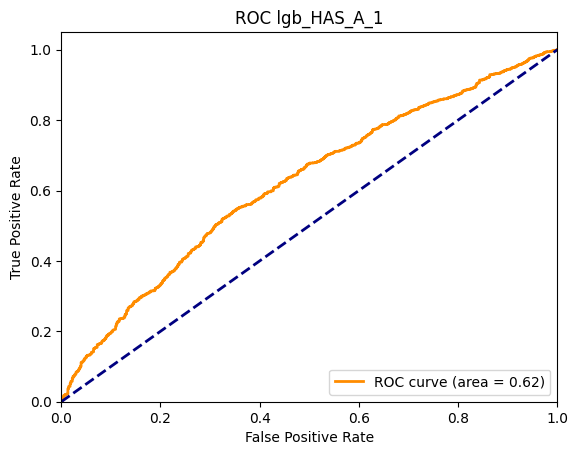

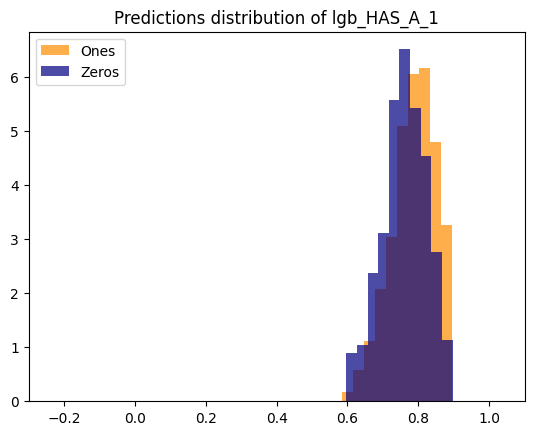

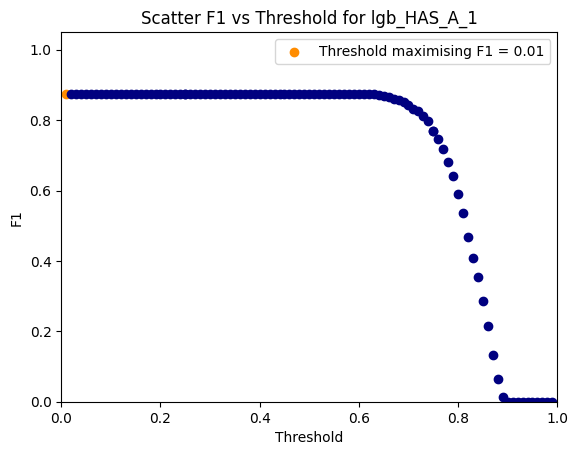

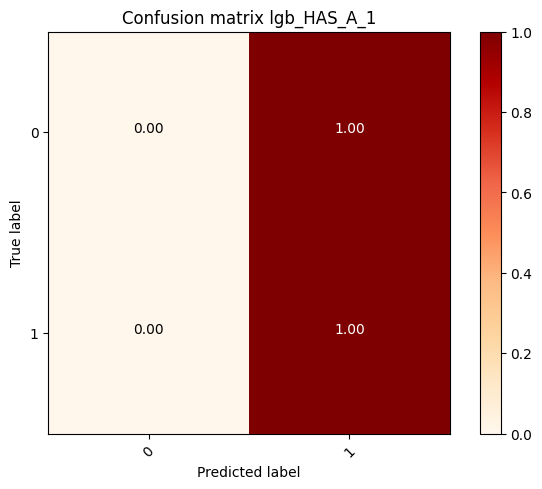

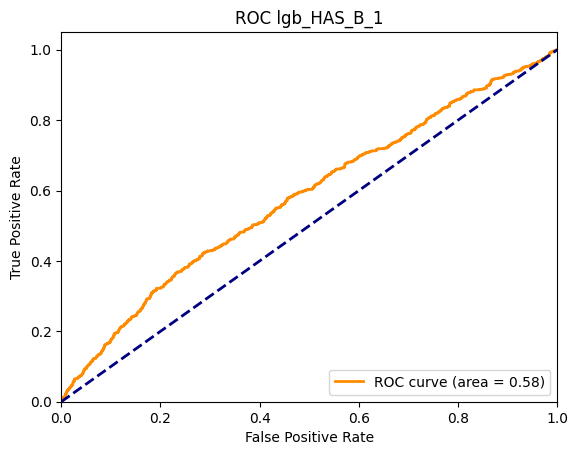

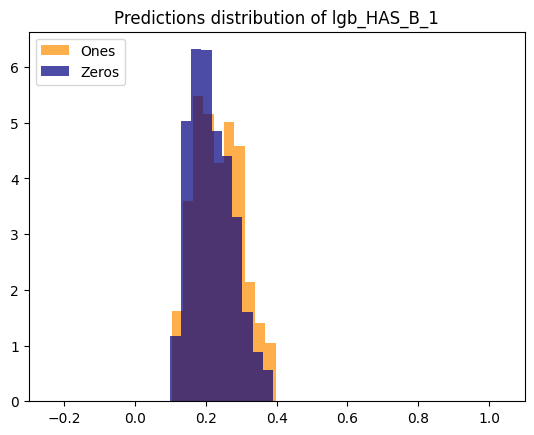

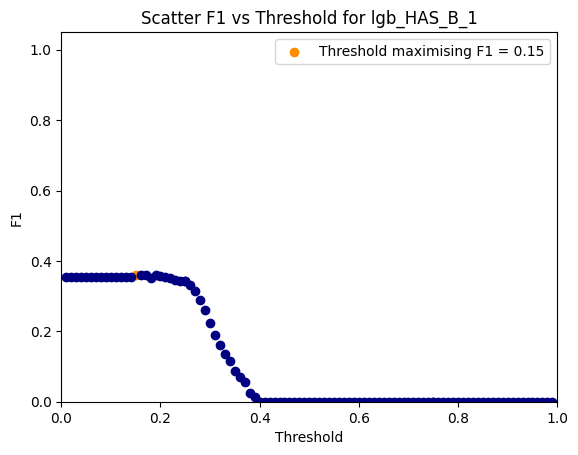

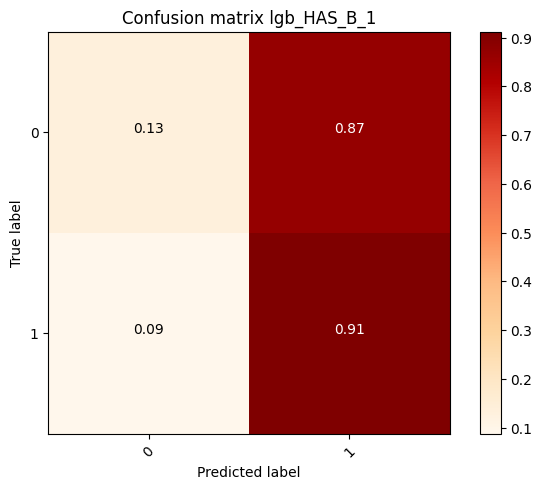

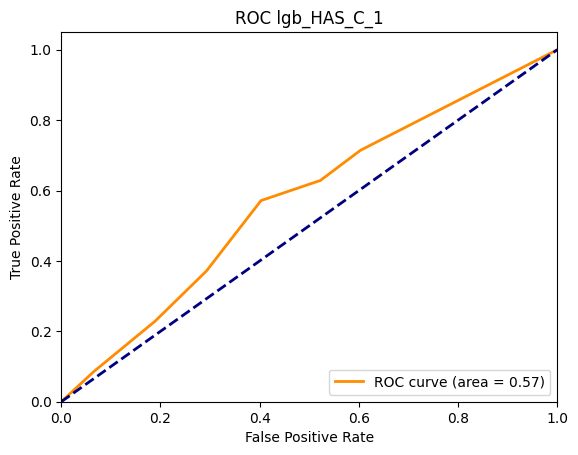

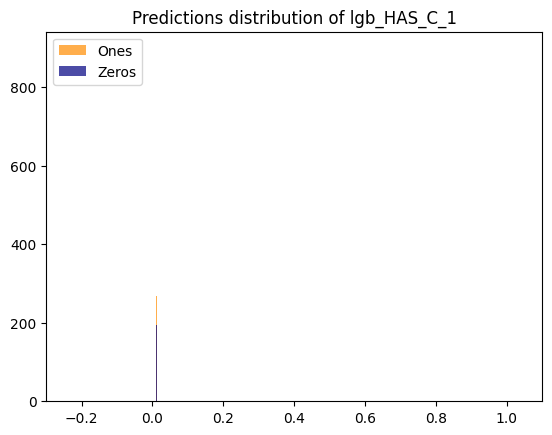

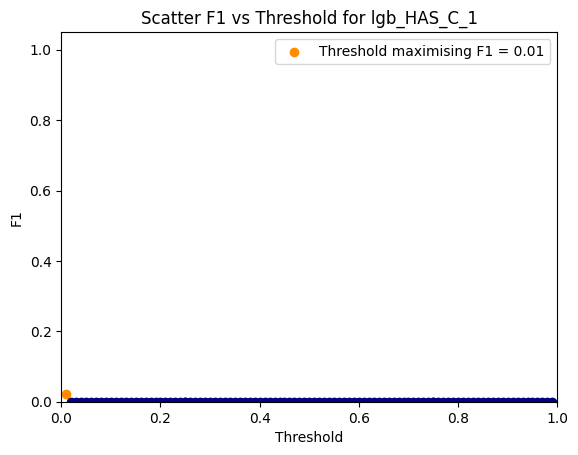

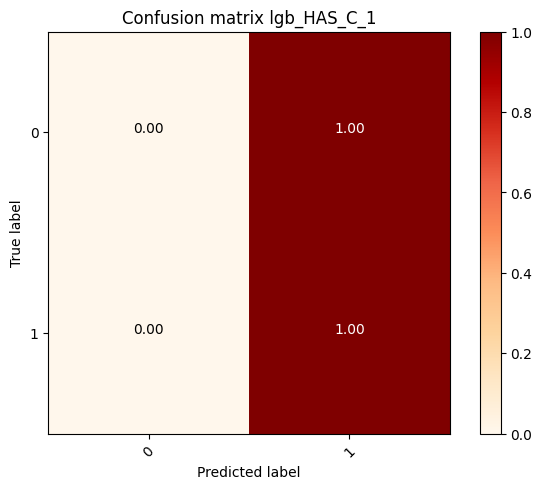

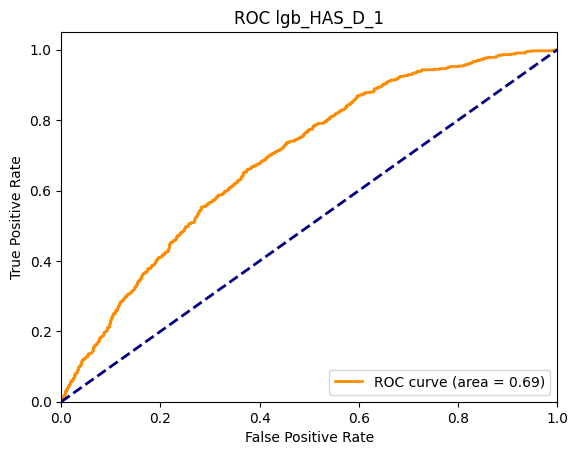

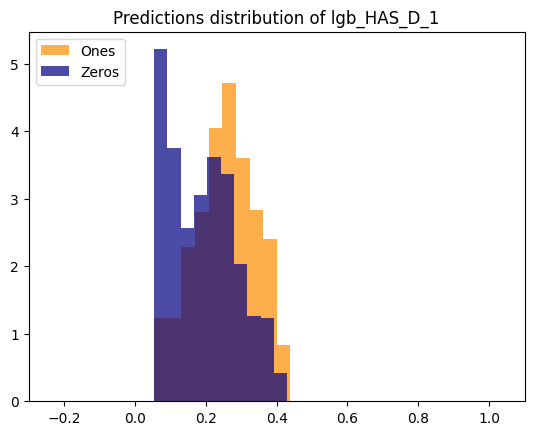

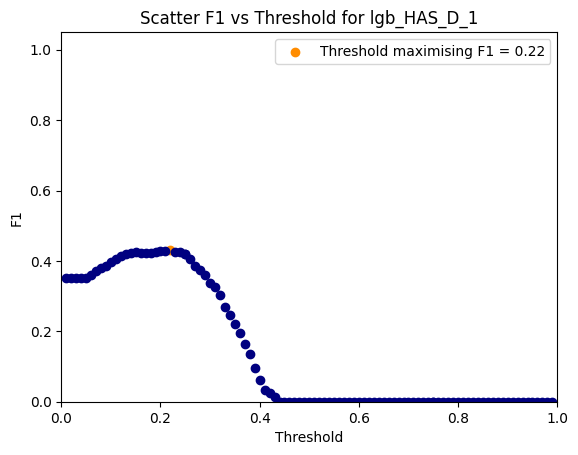

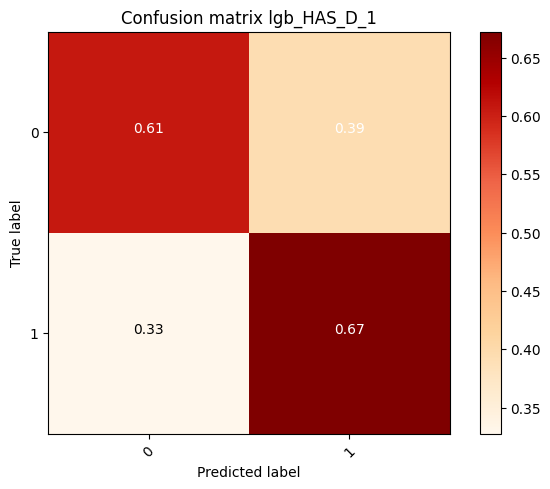

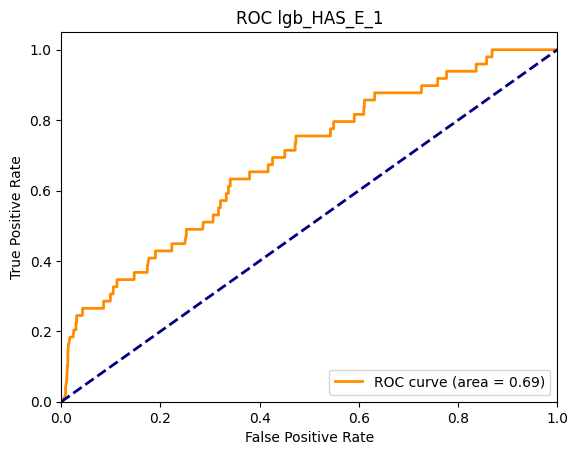

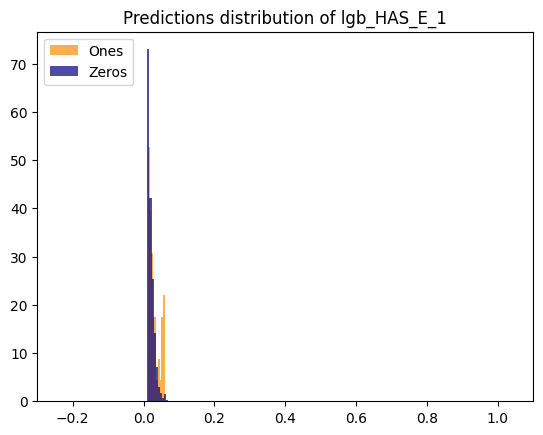

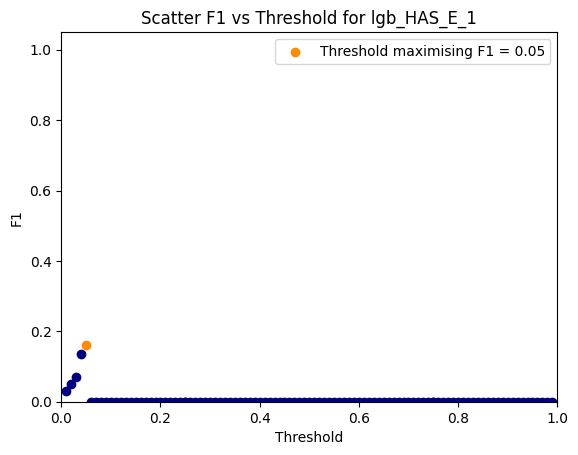

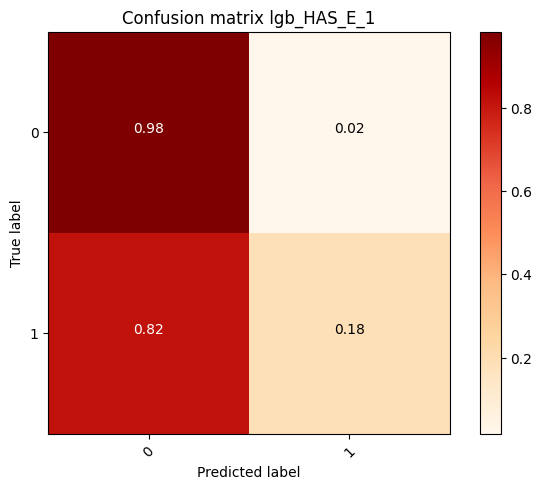

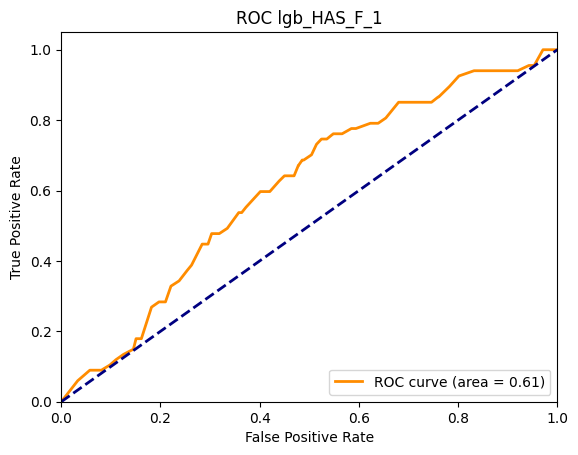

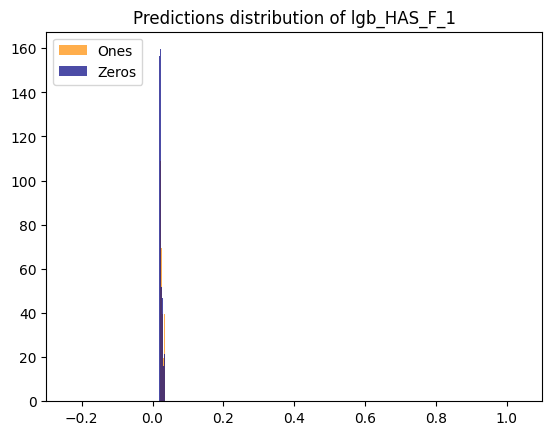

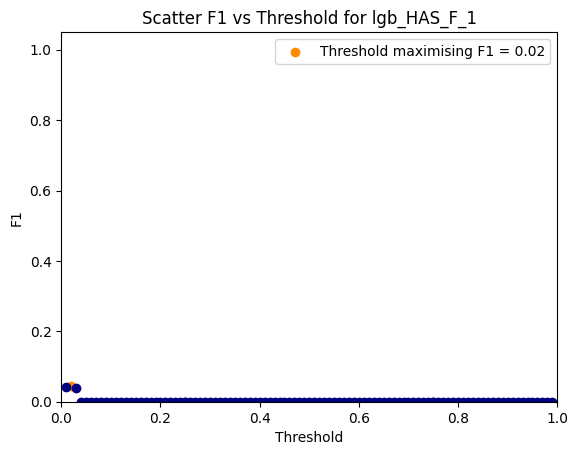

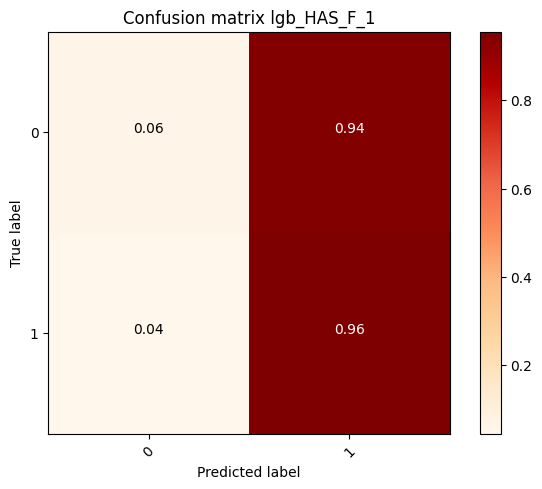

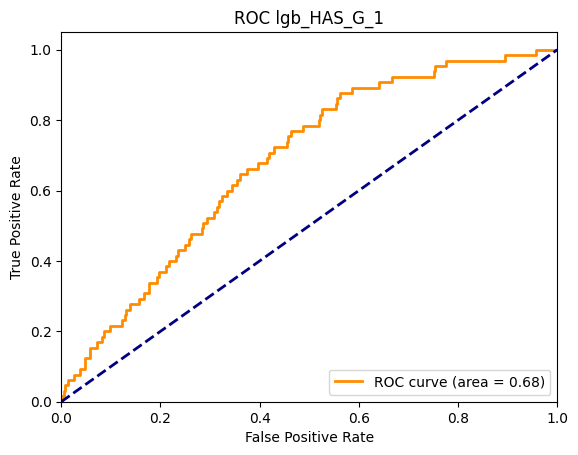

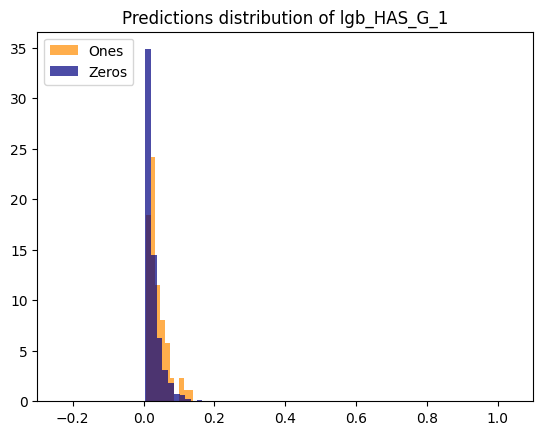

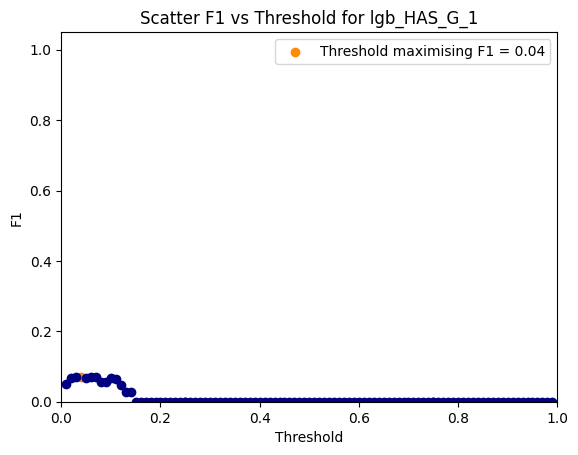

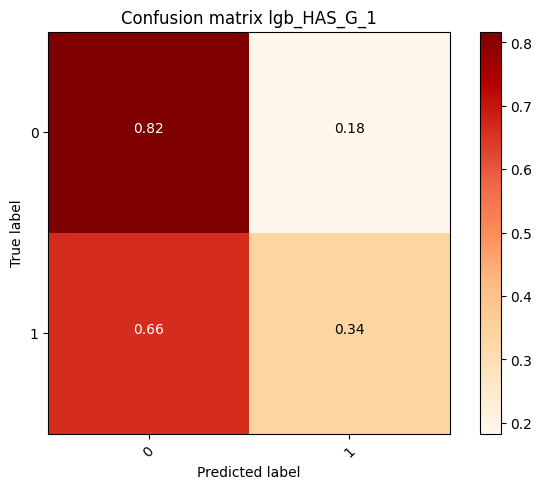

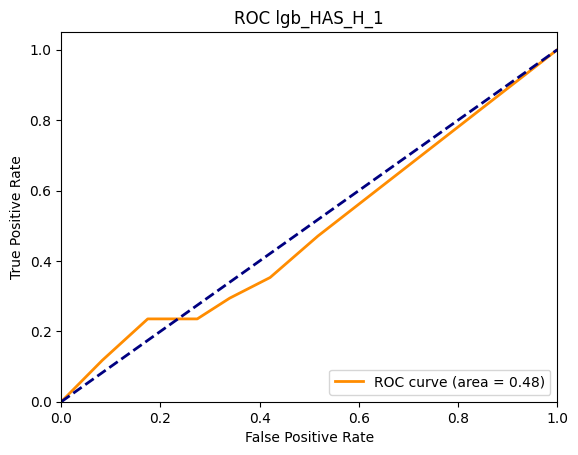

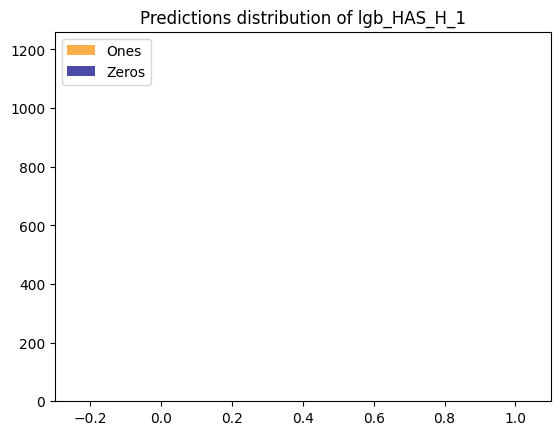

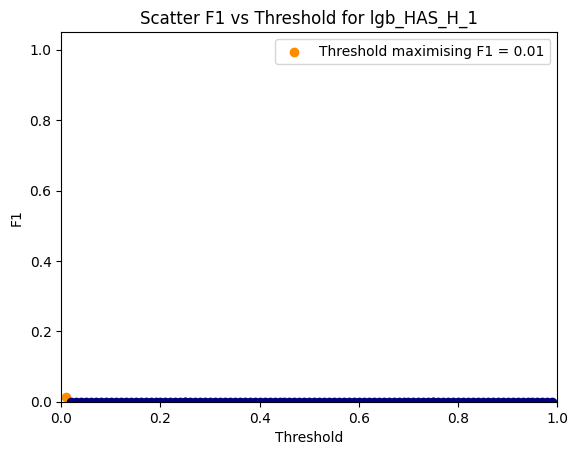

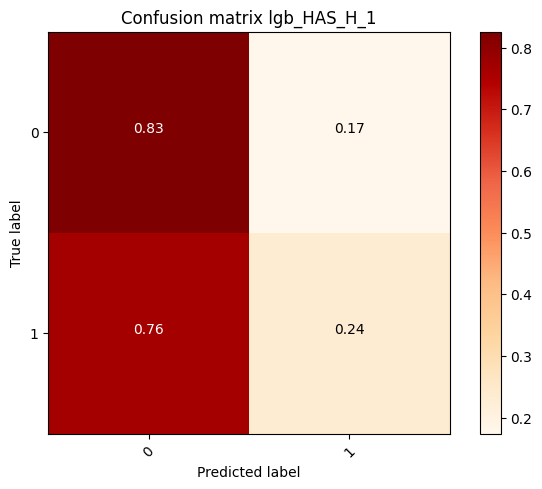

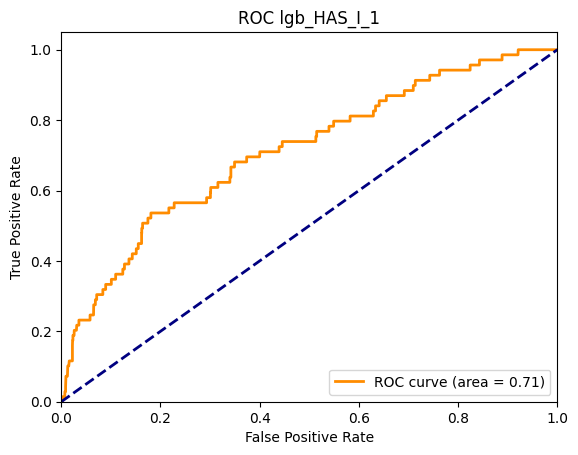

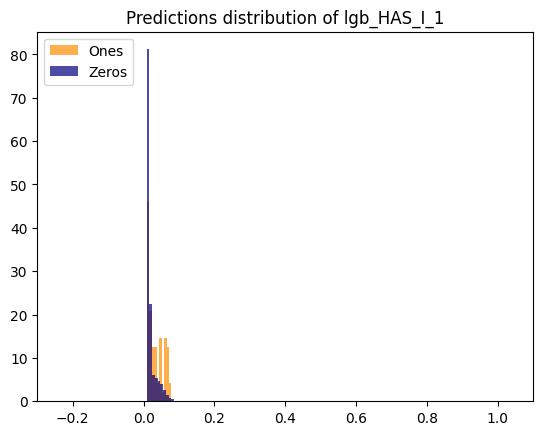

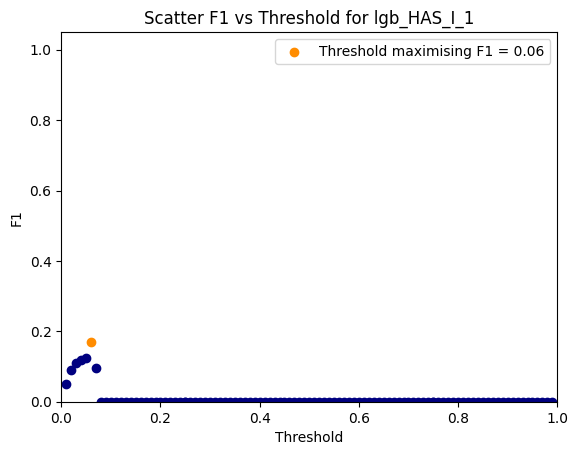

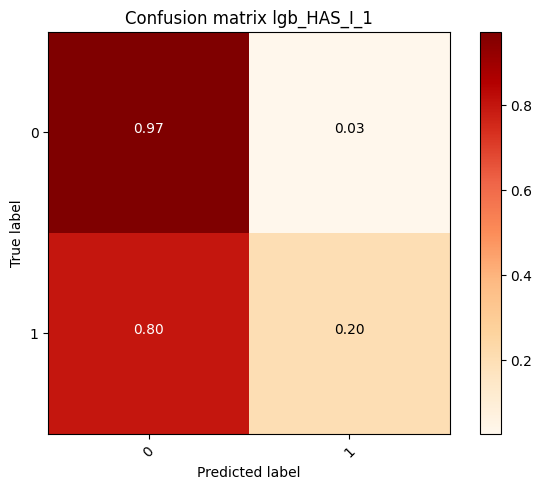

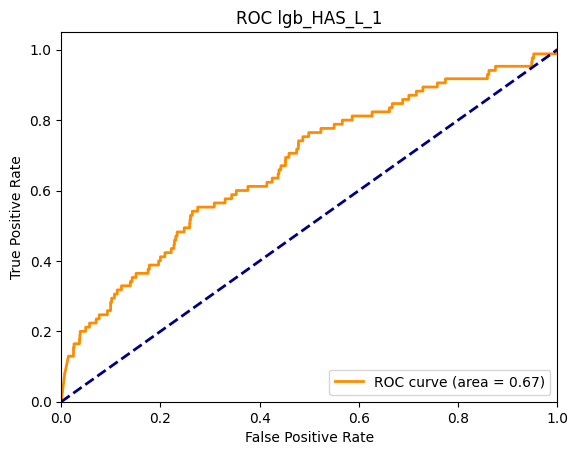

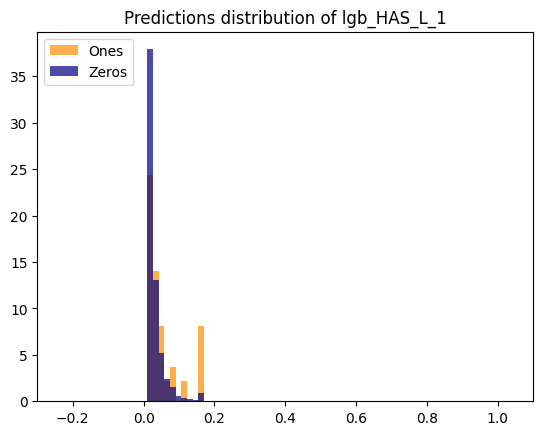

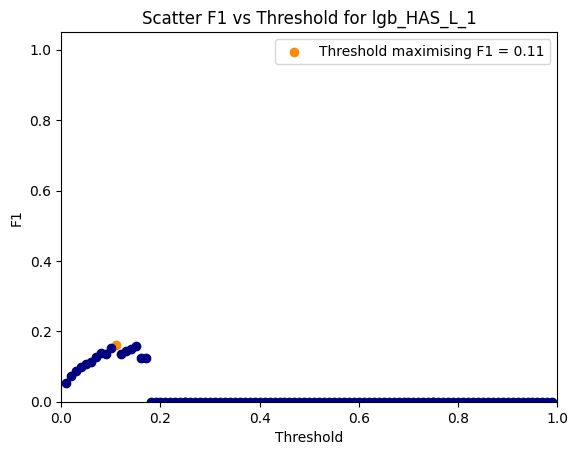

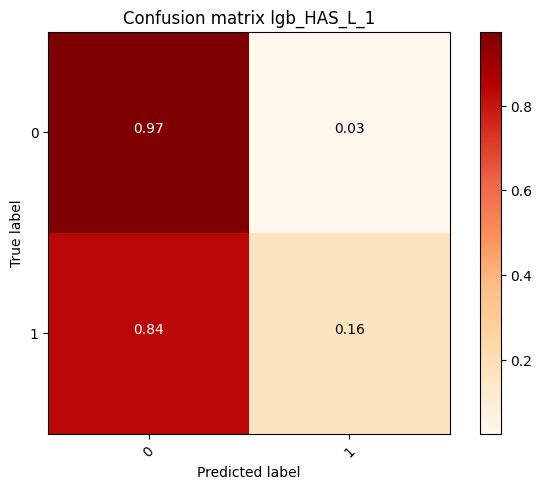

In [7]:
# Config
CONFIG_FOLDER = os.path.join("config")
CONFIG_FILE = "features.csv"
DATA_FOLDER = os.path.join("..", "sample_data")
DATA_FILE = "dataset.csv"
MODELS_FOLDER = os.path.join("models")
RESULTS_FOLDER = os.path.join("results")

MODEL_TYPE = "model"
TAG = "lgb"

PREDICTIONS_FILE = "_".join([MODEL_TYPE, TAG, "pred.csv"])

SAVE = True

# lightgbm params
# use an optimisation method to find the best params
SEED = 17
LGB_PARAMS = {
    "objective": "binary",
    "eval_metric": "logloss",
    "seed": SEED,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 22,
    "min_data_in_leaf": 500,
    "colsample_bytree": 0.75,
    "subsample": 0.75,
    "learning_rate": 0.1
}


if __name__ == "__main__":

    pmp = pm.PimpPlot(save=SAVE, folder=os.path.join(RESULTS_FOLDER, "plots"))

    # Load config
    source_config = os.path.join(CONFIG_FOLDER, CONFIG_FILE)
    features = pd.read_csv(source_config, keep_default_na=False, na_values=[""])
    #print(features.columns)
    index = features.loc[features[MODEL_TYPE] == "index", "column"].tolist()
    predictors = features.loc[features[MODEL_TYPE] == "predictor", "column"].tolist()
    labels = features.loc[features[MODEL_TYPE] == "label", "column"].tolist()
    categorical = features.loc[(features["categorical"] == 1) & (features["column"].isin(predictors)), "column"].tolist()

    # Load data
    source_file = os.path.join(DATA_FOLDER, DATA_FILE)
    data = pd.read_csv(source_file, usecols=index+labels+predictors+["SET"],
                    sep=";", decimal=".", encoding="latin1",
                    keep_default_na = False, na_values = [""])

    # Preprocessing lightgbm
    group_categoricals_tail(data, categorical)

    # Label encoder categorical variables
    label_encoding = {}
    for col in categorical:
        unique_values = data[col].unique().tolist()
        label_encoding[col] = LabelEncoder()
        label_encoding[col].fit(sorted(unique_values))
        data[col] = label_encoding[col].transform(data[col].values)

    # Split the dataset
    indexes = {"train": None, "valid": None, "test": None}
    for set_name in indexes.keys():
        indexes[set_name] = np.where(data["SET"] == set_name)[0]

    # Get only relevant features
    lgb_features = [x for x in sorted(data.columns.tolist()) if x not in labels + index + ["SET"]]

    d = {}
    for set_name, set_indexes in indexes.items():
        if set_name == "test":
            d[set_name] = data.loc[set_indexes, lgb_features].values
        else:
            d[set_name] = lgb.Dataset(data.loc[set_indexes, lgb_features], 
                                        feature_name=lgb_features, 
                                        categorical_feature=categorical, 
                                        free_raw_data=False)

    predictions = {}
    for label in labels:
        print("----------------------------", end="\n")
        print(label, end="\n")
        print("----------------------------", end="\n\n")
        
        print("Creating the Dataset...")
        for set_name, set_indexes in indexes.items():
            if set_name == "test":
                y_test = data.loc[set_indexes, label].values
            else:
                d[set_name].set_label(data.loc[set_indexes, label].values)
        print("Done!", end="\n\n")

        print("Training lightgbm...")
        bst = lgb.train(params=LGB_PARAMS, 
                        train_set=d["train"],
                        num_boost_round=3000, 
                        valid_sets=[d["valid"]],
                        callbacks=[early_stopping(stopping_rounds=5)])
        print("Done!", end="\n\n")

        print("Predictions and plots LGB...")
        pred_label = "{0}_PRED_{1}".format(label, TAG.upper())
        predictions[pred_label] = bst.predict(d["test"])
        
        print("Logloss: {}".format(log_loss(y_test, predictions[pred_label])), end="\n\n")

        print(predictions[pred_label])

        threshold_preds = (predictions[pred_label] > 0.5).astype(int)

        auc_score = roc_auc_score(y_test, predictions[pred_label])
        accuracy = accuracy_score(y_test, threshold_preds)
        precision = precision_score(y_test, threshold_preds)
        recall = recall_score(y_test, threshold_preds)
        pr_auc = average_precision_score(y_test, predictions[pred_label])
        f2_score = fbeta_score(y_test, threshold_preds, beta=2)
        
        print(f"AUC {label}: {auc_score:.4f}")
        print(f"Accuracy {label}: {accuracy:.4f}")
        print(f"Precision {label}: {precision:.4f}")
        print(f"Recall {label}: {recall:.4f}")
        print(f"PR_AUC {label}: {pr_auc:.4f}")
        print(f"F2-Score {label}: {f2_score:.4f}")
        
        if TAG:
            title = "_".join([TAG, label])
        else:
            title = label
        pmp.plot_roc(y_test, predictions[pred_label], title)
        pmp.plot_distributions(y_test, predictions[pred_label], title)
        threshold = pmp.find_threshold_max_f1(y_test, predictions[pred_label], title, N = 100)
        binary_predictions = np.where(predictions[pred_label] >= threshold, 1, 0)
        pmp.plot_confusion_matrix(y_test, binary_predictions, [0, 1], title)
        print("Done!", end="\n\n")

        if SAVE:
            print("Saving...")
            bst.save_model(os.path.join(MODELS_FOLDER, title + ".model"))
            print("Done!", end="\n\n")

    predictions = pd.DataFrame(predictions)
    predictions.to_csv(os.path.join(RESULTS_FOLDER, PREDICTIONS_FILE), sep=";", index=False)

#### XGBoost

Index(['column', 'model', 'categorical', 'binary', 'numerical'], dtype='object')
['UNIQUE_ID', 'SET']
['HAS_A_1', 'HAS_B_1', 'HAS_C_1', 'HAS_D_1', 'HAS_E_1', 'HAS_F_1', 'HAS_G_1', 'HAS_H_1', 'HAS_I_1', 'HAS_L_1']
----------------------------
HAS_A_1
----------------------------

Creating the DMatrix...
Done!

Training XGB...
[0]	val-logloss:0.52083
[1]	val-logloss:0.51786
[2]	val-logloss:0.51655
[3]	val-logloss:0.51509
[4]	val-logloss:0.51314
[5]	val-logloss:0.51229
[6]	val-logloss:0.51157
[7]	val-logloss:0.50999
[8]	val-logloss:0.50916
[9]	val-logloss:0.50847
[10]	val-logloss:0.50820
[11]	val-logloss:0.50821
[12]	val-logloss:0.50766
[13]	val-logloss:0.50656
[14]	val-logloss:0.50570
[15]	val-logloss:0.50523
[16]	val-logloss:0.50466
[17]	val-logloss:0.50526
[18]	val-logloss:0.50506
[19]	val-logloss:0.50431
[20]	val-logloss:0.50443
[21]	val-logloss:0.50411
[22]	val-logloss:0.50388
[23]	val-logloss:0.50376
[24]	val-logloss:0.50375
[25]	val-logloss:0.50373
[26]	val-logloss:0.50374
[27]	val

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:34:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.





[42]	val-logloss:0.50322
[43]	val-logloss:0.50312
[44]	val-logloss:0.50293
[45]	val-logloss:0.50292
[46]	val-logloss:0.50321
[47]	val-logloss:0.50313
[48]	val-logloss:0.50313
[49]	val-logloss:0.50304
[50]	val-logloss:0.50206
[51]	val-logloss:0.50206
[52]	val-logloss:0.50206
[53]	val-logloss:0.50249
[54]	val-logloss:0.50249
[55]	val-logloss:0.50283
[56]	val-logloss:0.50344
[57]	val-logloss:0.50344
[58]	val-logloss:0.50406
[59]	val-logloss:0.50363
[60]	val-logloss:0.50363
[61]	val-logloss:0.50363
[62]	val-logloss:0.50330
[63]	val-logloss:0.50330
[64]	val-logloss:0.50330
[65]	val-logloss:0.50385
[66]	val-logloss:0.50385
[67]	val-logloss:0.50393
[68]	val-logloss:0.50423
[69]	val-logloss:0.50423
[70]	val-logloss:0.50423
[71]	val-logloss:0.50423
[72]	val-logloss:0.50401
[73]	val-logloss:0.50401
[74]	val-logloss:0.50403
[75]	val-logloss:0.50395
[76]	val-logloss:0.50380
[77]	val-logloss:0.50380
[78]	val-logloss:0.50380
[79]	val-logloss:0.50380
[80]	val-logloss:0.50380
[81]	val-logloss:0.50380

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.





[40]	val-logloss:0.52171
[41]	val-logloss:0.52191
[42]	val-logloss:0.52191
[43]	val-logloss:0.52181
[44]	val-logloss:0.52180
[45]	val-logloss:0.52179
[46]	val-logloss:0.52178
[47]	val-logloss:0.52184
[48]	val-logloss:0.52184
[49]	val-logloss:0.52197
[50]	val-logloss:0.52197
[51]	val-logloss:0.52194
[52]	val-logloss:0.52196
[53]	val-logloss:0.52181
[54]	val-logloss:0.52181
[55]	val-logloss:0.52175
[56]	val-logloss:0.52150
[57]	val-logloss:0.52149
[58]	val-logloss:0.52147
[59]	val-logloss:0.52147
[60]	val-logloss:0.52131
[61]	val-logloss:0.52129
[62]	val-logloss:0.52013
[63]	val-logloss:0.52011
[64]	val-logloss:0.52054
[65]	val-logloss:0.52025
[66]	val-logloss:0.52000
[67]	val-logloss:0.52000
[68]	val-logloss:0.52001
[69]	val-logloss:0.52004
[70]	val-logloss:0.52044
[71]	val-logloss:0.52046
[72]	val-logloss:0.52046
[73]	val-logloss:0.52046
[74]	val-logloss:0.52076
[75]	val-logloss:0.52072
[76]	val-logloss:0.52077
[77]	val-logloss:0.52089
[78]	val-logloss:0.52109
[79]	val-logloss:0.52113

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:34:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:34:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.





[57]	val-logloss:0.04752
[58]	val-logloss:0.04750
[59]	val-logloss:0.04770
[60]	val-logloss:0.04776
[61]	val-logloss:0.04772
[62]	val-logloss:0.04769
[63]	val-logloss:0.04772
[64]	val-logloss:0.04766
[65]	val-logloss:0.04744
[66]	val-logloss:0.04737
[67]	val-logloss:0.04740
[68]	val-logloss:0.04742
[69]	val-logloss:0.04740
[70]	val-logloss:0.04743
[71]	val-logloss:0.04742
[72]	val-logloss:0.04742
[73]	val-logloss:0.04737
[74]	val-logloss:0.04734
[75]	val-logloss:0.04735
[76]	val-logloss:0.04735
[77]	val-logloss:0.04735
[78]	val-logloss:0.04737
[79]	val-logloss:0.04739
[80]	val-logloss:0.04733
[81]	val-logloss:0.04734
[82]	val-logloss:0.04734
[83]	val-logloss:0.04741
[84]	val-logloss:0.04745
[85]	val-logloss:0.04743
[86]	val-logloss:0.04740
[87]	val-logloss:0.04738
[88]	val-logloss:0.04737
[89]	val-logloss:0.04737
[90]	val-logloss:0.04740
[91]	val-logloss:0.04736
[92]	val-logloss:0.04731
[93]	val-logloss:0.04729
[94]	val-logloss:0.04729
[95]	val-logloss:0.04728
[96]	val-logloss:0.04730

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Done!

Saving...
Done!

----------------------------
HAS_D_1
----------------------------

Creating the DMatrix...
Done!

Training XGB...
[0]	val-logloss:0.50815
[1]	val-logloss:0.50251
[2]	val-logloss:0.49786
[3]	val-logloss:0.49419
[4]	val-logloss:0.49162
[5]	val-logloss:0.48915
[6]	val-logloss:0.48656
[7]	val-logloss:0.48416
[8]	val-logloss:0.48236
[9]	val-logloss:0.48062
[10]	val-logloss:0.47984
[11]	val-logloss:0.47870
[12]	val-logloss:0.47735
[13]	val-logloss:0.47634
[14]	val-logloss:0.47500
[15]	val-logloss:0.47409
[16]	val-logloss:0.47463
[17]	val-logloss:0.47427
[18]	val-logloss:0.47351
[19]	val-logloss:0.47325
[20]	val-logloss:0.47309
[21]	val-logloss:0.47200
[22]	val-logloss:0.47192
[23]	val-logloss:0.47120
[24]	val-logloss:0.47087
[25]	val-logloss:0.47106
[26]	val-logloss:0.47015
[27]	val-logloss:0.46978
[28]	val-logloss:0.46976
[29]	val-logloss:0.46978
[30]	val-logloss:0.46956
[31]	val-logloss:0.46946
[32]	val-logloss:0.46963
[33]	val-logloss:0.46954
[34]	val-logloss:0.469

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:34:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:34:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




[39]	val-logloss:0.46890
[40]	val-logloss:0.46886
[41]	val-logloss:0.46849
[42]	val-logloss:0.46851
[43]	val-logloss:0.46867
[44]	val-logloss:0.46858
[45]	val-logloss:0.46861
[46]	val-logloss:0.46862
[47]	val-logloss:0.46823
[48]	val-logloss:0.46822
[49]	val-logloss:0.46824
[50]	val-logloss:0.46823
[51]	val-logloss:0.46821
[52]	val-logloss:0.46823
[53]	val-logloss:0.46817
[54]	val-logloss:0.46821
[55]	val-logloss:0.46817
[56]	val-logloss:0.46820
[57]	val-logloss:0.46820
[58]	val-logloss:0.46822
[59]	val-logloss:0.46823
[60]	val-logloss:0.46821
[61]	val-logloss:0.46822
[62]	val-logloss:0.46820
[63]	val-logloss:0.46817
[64]	val-logloss:0.46821
[65]	val-logloss:0.46822
[66]	val-logloss:0.46824
[67]	val-logloss:0.46822
[68]	val-logloss:0.46866
[69]	val-logloss:0.46868
[70]	val-logloss:0.46871
[71]	val-logloss:0.46867
[72]	val-logloss:0.46858
[73]	val-logloss:0.46861
[74]	val-logloss:0.46857
[75]	val-logloss:0.46879
[76]	val-logloss:0.46851
[77]	val-logloss:0.46851
[78]	val-logloss:0.46840


c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.





[26]	val-logloss:0.09451
[27]	val-logloss:0.09411
[28]	val-logloss:0.09365
[29]	val-logloss:0.09392
[30]	val-logloss:0.09385
[31]	val-logloss:0.09384
[32]	val-logloss:0.09333
[33]	val-logloss:0.09342
[34]	val-logloss:0.09335
[35]	val-logloss:0.09320
[36]	val-logloss:0.09306
[37]	val-logloss:0.09313
[38]	val-logloss:0.09310
[39]	val-logloss:0.09300
[40]	val-logloss:0.09276
[41]	val-logloss:0.09274
[42]	val-logloss:0.09281
[43]	val-logloss:0.09279
[44]	val-logloss:0.09260
[45]	val-logloss:0.09260
[46]	val-logloss:0.09304
[47]	val-logloss:0.09302
[48]	val-logloss:0.09301
[49]	val-logloss:0.09294
[50]	val-logloss:0.09270
[51]	val-logloss:0.09246
[52]	val-logloss:0.09245
[53]	val-logloss:0.09234
[54]	val-logloss:0.09224
[55]	val-logloss:0.09222
[56]	val-logloss:0.09222
[57]	val-logloss:0.09214
[58]	val-logloss:0.09213
[59]	val-logloss:0.09213
[60]	val-logloss:0.09211
[61]	val-logloss:0.09211
[62]	val-logloss:0.09210
[63]	val-logloss:0.09209
[64]	val-logloss:0.09209
[65]	val-logloss:0.09210

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Done!

Saving...
Done!

----------------------------
HAS_F_1
----------------------------

Creating the DMatrix...
Done!

Training XGB...
[0]	val-logloss:0.15392
[1]	val-logloss:0.14486
[2]	val-logloss:0.13670
[3]	val-logloss:0.12936
[4]	val-logloss:0.12297
[5]	val-logloss:0.11716
[6]	val-logloss:0.11205
[7]	val-logloss:0.10740
[8]	val-logloss:0.10336
[9]	val-logloss:0.10001
[10]	val-logloss:0.09677
[11]	val-logloss:0.09398
[12]	val-logloss:0.09134
[13]	val-logloss:0.08921
[14]	val-logloss:0.08726
[15]	val-logloss:0.08502
[16]	val-logloss:0.08348
[17]	val-logloss:0.08197
[18]	val-logloss:0.08083
[19]	val-logloss:0.07961
[20]	val-logloss:0.07873
[21]	val-logloss:0.07776
[22]	val-logloss:0.07660
[23]	val-logloss:0.07578
[24]	val-logloss:0.07514
[25]	val-logloss:0.07440
[26]	val-logloss:0.07378
[27]	val-logloss:0.07334
[28]	val-logloss:0.07302
[29]	val-logloss:0.07269
[30]	val-logloss:0.07194
[31]	val-logloss:0.07152
[32]	val-logloss:0.07100
[33]	val-logloss:0.07083
[34]	val-logloss:0.070

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:35:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:35:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.





[53]	val-logloss:0.06909
[54]	val-logloss:0.06910
[55]	val-logloss:0.06893
[56]	val-logloss:0.06898
[57]	val-logloss:0.06897
[58]	val-logloss:0.06880
[59]	val-logloss:0.06868
[60]	val-logloss:0.06869
[61]	val-logloss:0.06872
[62]	val-logloss:0.06865
[63]	val-logloss:0.06879
[64]	val-logloss:0.06884
[65]	val-logloss:0.06882
[66]	val-logloss:0.06843
[67]	val-logloss:0.06841
[68]	val-logloss:0.06835
[69]	val-logloss:0.06830
[70]	val-logloss:0.06830
[71]	val-logloss:0.06826
[72]	val-logloss:0.06832
[73]	val-logloss:0.06832
[74]	val-logloss:0.06827
[75]	val-logloss:0.06780
[76]	val-logloss:0.06780
[77]	val-logloss:0.06780
[78]	val-logloss:0.06780
[79]	val-logloss:0.06781
[80]	val-logloss:0.06784
[81]	val-logloss:0.06782
[82]	val-logloss:0.06785
[83]	val-logloss:0.06786
[84]	val-logloss:0.06789
[85]	val-logloss:0.06788
[86]	val-logloss:0.06783
[87]	val-logloss:0.06787
[88]	val-logloss:0.06792
[89]	val-logloss:0.06787
[90]	val-logloss:0.06790
[91]	val-logloss:0.06793
[92]	val-logloss:0.06786

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\lwstr\OneDrive\Documents\GitHub\recsysReplication\supervised\utils\pimpmatplotlib.py:36: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



Done!

Saving...
Done!

----------------------------
HAS_G_1
----------------------------

Creating the DMatrix...
Done!

Training XGB...
[0]	val-logloss:0.16125
[1]	val-logloss:0.15239
[2]	val-logloss:0.14447
[3]	val-logloss:0.13764
[4]	val-logloss:0.13107
[5]	val-logloss:0.12556
[6]	val-logloss:0.12080
[7]	val-logloss:0.11618
[8]	val-logloss:0.11212
[9]	val-logloss:0.10844
[10]	val-logloss:0.10519
[11]	val-logloss:0.10238
[12]	val-logloss:0.09967
[13]	val-logloss:0.09752
[14]	val-logloss:0.09592
[15]	val-logloss:0.09305
[16]	val-logloss:0.09139
[17]	val-logloss:0.08966
[18]	val-logloss:0.08854
[19]	val-logloss:0.08764
[20]	val-logloss:0.08659
[21]	val-logloss:0.08553
[22]	val-logloss:0.08453
[23]	val-logloss:0.08391
[24]	val-logloss:0.08318
[25]	val-logloss:0.08255
[26]	val-logloss:0.08190
[27]	val-logloss:0.08119
[28]	val-logloss:0.08071
[29]	val-logloss:0.08018
[30]	val-logloss:0.08005
[31]	val-logloss:0.07966
[32]	val-logloss:0.07899
[33]	val-logloss:0.07847
[34]	val-logloss:0.078

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:35:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:35:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.





[50]	val-logloss:0.07582
[51]	val-logloss:0.07569
[52]	val-logloss:0.07533
[53]	val-logloss:0.07535
[54]	val-logloss:0.07483
[55]	val-logloss:0.07488
[56]	val-logloss:0.07520
[57]	val-logloss:0.07521
[58]	val-logloss:0.07536
[59]	val-logloss:0.07546
[60]	val-logloss:0.07546
[61]	val-logloss:0.07537
[62]	val-logloss:0.07542
[63]	val-logloss:0.07535
[64]	val-logloss:0.07532
[65]	val-logloss:0.07528
[66]	val-logloss:0.07538
[67]	val-logloss:0.07537
[68]	val-logloss:0.07535
[69]	val-logloss:0.07537
[70]	val-logloss:0.07541
[71]	val-logloss:0.07545
[72]	val-logloss:0.07547
[73]	val-logloss:0.07543
[74]	val-logloss:0.07541
[75]	val-logloss:0.07540
[76]	val-logloss:0.07535
[77]	val-logloss:0.07543
[78]	val-logloss:0.07541
[79]	val-logloss:0.07538
[80]	val-logloss:0.07531
[81]	val-logloss:0.07533
[82]	val-logloss:0.07539
[83]	val-logloss:0.07542
[84]	val-logloss:0.07549
[85]	val-logloss:0.07550
[86]	val-logloss:0.07553
[87]	val-logloss:0.07550
[88]	val-logloss:0.07549
[89]	val-logloss:0.07548

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Done!

Saving...
Done!

----------------------------
HAS_H_1
----------------------------

Creating the DMatrix...
Done!

Training XGB...
[0]	val-logloss:0.12725
[1]	val-logloss:0.11657
[2]	val-logloss:0.10702
[3]	val-logloss:0.09850
[4]	val-logloss:0.09096
[5]	val-logloss:0.08421
[6]	val-logloss:0.07818
[7]	val-logloss:0.07282
[8]	val-logloss:0.06795
[9]	val-logloss:0.06371
[10]	val-logloss:0.05990
[11]	val-logloss:0.05647
[12]	val-logloss:0.05344
[13]	val-logloss:0.05070
[14]	val-logloss:0.04828
[15]	val-logloss:0.04610
[16]	val-logloss:0.04410
[17]	val-logloss:0.04227
[18]	val-logloss:0.04053
[19]	val-logloss:0.03915
[20]	val-logloss:0.03799
[21]	val-logloss:0.03689
[22]	val-logloss:0.03588
[23]	val-logloss:0.03489
[24]	val-logloss:0.03396
[25]	val-logloss:0.03320
[26]	val-logloss:0.03258
[27]	val-logloss:0.03201
[28]	val-logloss:0.03148
[29]	val-logloss:0.03095
[30]	val-logloss:0.03073
[31]	val-logloss:0.03018
[32]	val-logloss:0.02995
[33]	val-logloss:0.02969
[34]	val-logloss:0.029

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:35:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:35:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.





[50]	val-logloss:0.02793
[51]	val-logloss:0.02795
[52]	val-logloss:0.02786
[53]	val-logloss:0.02781
[54]	val-logloss:0.02775
[55]	val-logloss:0.02741
[56]	val-logloss:0.02740
[57]	val-logloss:0.02740
[58]	val-logloss:0.02738
[59]	val-logloss:0.02746
[60]	val-logloss:0.02752
[61]	val-logloss:0.02747
[62]	val-logloss:0.02754
[63]	val-logloss:0.02741
[64]	val-logloss:0.02743
[65]	val-logloss:0.02736
[66]	val-logloss:0.02736
[67]	val-logloss:0.02734
[68]	val-logloss:0.02735
[69]	val-logloss:0.02735
[70]	val-logloss:0.02721
[71]	val-logloss:0.02717
[72]	val-logloss:0.02719
[73]	val-logloss:0.02760
[74]	val-logloss:0.02756
[75]	val-logloss:0.02746
[76]	val-logloss:0.02751
[77]	val-logloss:0.02745
[78]	val-logloss:0.02752
[79]	val-logloss:0.02756
[80]	val-logloss:0.02752
[81]	val-logloss:0.02738
[82]	val-logloss:0.02747
[83]	val-logloss:0.02748
[84]	val-logloss:0.02744
[85]	val-logloss:0.02745
[86]	val-logloss:0.02741
[87]	val-logloss:0.02762
[88]	val-logloss:0.02761
[89]	val-logloss:0.02762

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Done!

Saving...
Done!

----------------------------
HAS_I_1
----------------------------

Creating the DMatrix...
Done!

Training XGB...
[0]	val-logloss:0.15189
[1]	val-logloss:0.14264
[2]	val-logloss:0.13450
[3]	val-logloss:0.12714
[4]	val-logloss:0.12053
[5]	val-logloss:0.11427
[6]	val-logloss:0.10912
[7]	val-logloss:0.10467
[8]	val-logloss:0.10017
[9]	val-logloss:0.09647
[10]	val-logloss:0.09307
[11]	val-logloss:0.09018
[12]	val-logloss:0.08766
[13]	val-logloss:0.08522
[14]	val-logloss:0.08330
[15]	val-logloss:0.08128
[16]	val-logloss:0.07977
[17]	val-logloss:0.07832
[18]	val-logloss:0.07666
[19]	val-logloss:0.07533
[20]	val-logloss:0.07459
[21]	val-logloss:0.07339
[22]	val-logloss:0.07252
[23]	val-logloss:0.07143
[24]	val-logloss:0.07104
[25]	val-logloss:0.07017
[26]	val-logloss:0.06937
[27]	val-logloss:0.06841
[28]	val-logloss:0.06830
[29]	val-logloss:0.06809
[30]	val-logloss:0.06746
[31]	val-logloss:0.06733
[32]	val-logloss:0.06707
[33]	val-logloss:0.06661
[34]	val-logloss:0.066

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:35:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:35:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.





[42]	val-logloss:0.06540
[43]	val-logloss:0.06537
[44]	val-logloss:0.06541
[45]	val-logloss:0.06533
[46]	val-logloss:0.06539
[47]	val-logloss:0.06536
[48]	val-logloss:0.06530
[49]	val-logloss:0.06519
[50]	val-logloss:0.06492
[51]	val-logloss:0.06490
[52]	val-logloss:0.06487
[53]	val-logloss:0.06482
[54]	val-logloss:0.06487
[55]	val-logloss:0.06488
[56]	val-logloss:0.06473
[57]	val-logloss:0.06470
[58]	val-logloss:0.06465
[59]	val-logloss:0.06461
[60]	val-logloss:0.06464
[61]	val-logloss:0.06459
[62]	val-logloss:0.06456
[63]	val-logloss:0.06452
[64]	val-logloss:0.06450
[65]	val-logloss:0.06461
[66]	val-logloss:0.06458
[67]	val-logloss:0.06478
[68]	val-logloss:0.06479
[69]	val-logloss:0.06489
[70]	val-logloss:0.06480
[71]	val-logloss:0.06479
[72]	val-logloss:0.06479
[73]	val-logloss:0.06475
[74]	val-logloss:0.06476
[75]	val-logloss:0.06475
[76]	val-logloss:0.06480
[77]	val-logloss:0.06477
[78]	val-logloss:0.06475
[79]	val-logloss:0.06473
[80]	val-logloss:0.06476
[81]	val-logloss:0.06481

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Done!

Saving...
Done!

----------------------------
HAS_L_1
----------------------------

Creating the DMatrix...
Done!

Training XGB...
[0]	val-logloss:0.20304
[1]	val-logloss:0.19451
[2]	val-logloss:0.18786
[3]	val-logloss:0.18234
[4]	val-logloss:0.17653
[5]	val-logloss:0.17128
[6]	val-logloss:0.16657
[7]	val-logloss:0.16302
[8]	val-logloss:0.15972
[9]	val-logloss:0.15788
[10]	val-logloss:0.15545
[11]	val-logloss:0.15315
[12]	val-logloss:0.15107
[13]	val-logloss:0.15014
[14]	val-logloss:0.14886
[15]	val-logloss:0.14760
[16]	val-logloss:0.14655
[17]	val-logloss:0.14552
[18]	val-logloss:0.14480
[19]	val-logloss:0.14408
[20]	val-logloss:0.14360
[21]	val-logloss:0.14352
[22]	val-logloss:0.14318
[23]	val-logloss:0.14323
[24]	val-logloss:0.14267
[25]	val-logloss:0.14279
[26]	val-logloss:0.14288
[27]	val-logloss:0.14263
[28]	val-logloss:0.14268
[29]	val-logloss:0.14262
[30]	val-logloss:0.14256
[31]	val-logloss:0.14256
[32]	val-logloss:0.14257
[33]	val-logloss:0.14197
[34]	val-logloss:0.141

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:35:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:35:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.





[47]	val-logloss:0.14057
[48]	val-logloss:0.14117
[49]	val-logloss:0.14119
[50]	val-logloss:0.14127
[51]	val-logloss:0.14132
[52]	val-logloss:0.14133
[53]	val-logloss:0.14127
[54]	val-logloss:0.14169
[55]	val-logloss:0.14154
[56]	val-logloss:0.14184
[57]	val-logloss:0.14172
[58]	val-logloss:0.14174
[59]	val-logloss:0.14174
[60]	val-logloss:0.14150
[61]	val-logloss:0.14151
[62]	val-logloss:0.14153
[63]	val-logloss:0.14158
[64]	val-logloss:0.14158
[65]	val-logloss:0.14156
[66]	val-logloss:0.14155
[67]	val-logloss:0.14154
[68]	val-logloss:0.14166
[69]	val-logloss:0.14166
[70]	val-logloss:0.14164
[71]	val-logloss:0.14164
[72]	val-logloss:0.14165
[73]	val-logloss:0.14149
[74]	val-logloss:0.14150
[75]	val-logloss:0.14151
[76]	val-logloss:0.14161
[77]	val-logloss:0.14162
[78]	val-logloss:0.14146
[79]	val-logloss:0.14147
[80]	val-logloss:0.14146
[81]	val-logloss:0.14146
[82]	val-logloss:0.14145
[83]	val-logloss:0.14131
[84]	val-logloss:0.14136
[85]	val-logloss:0.14136
[86]	val-logloss:0.14140

c:\Users\lwstr\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:35:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.



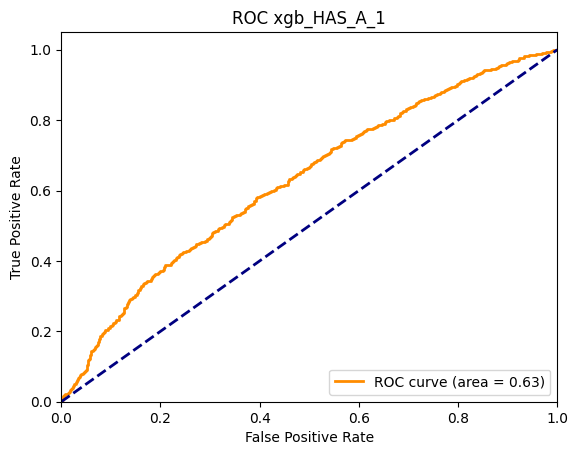

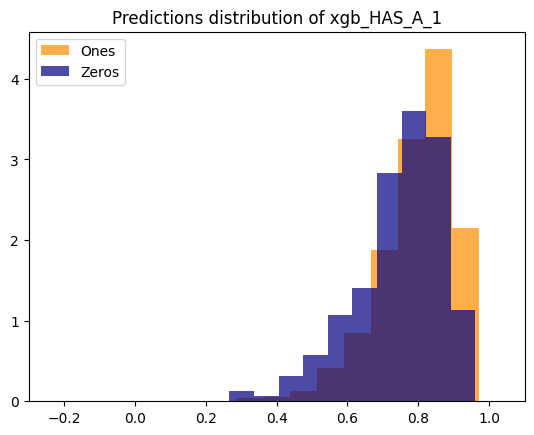

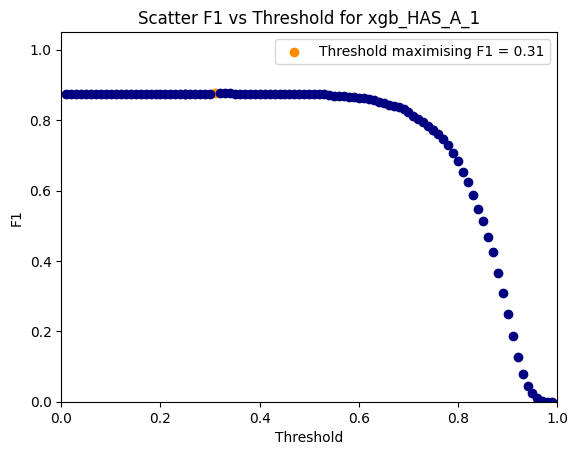

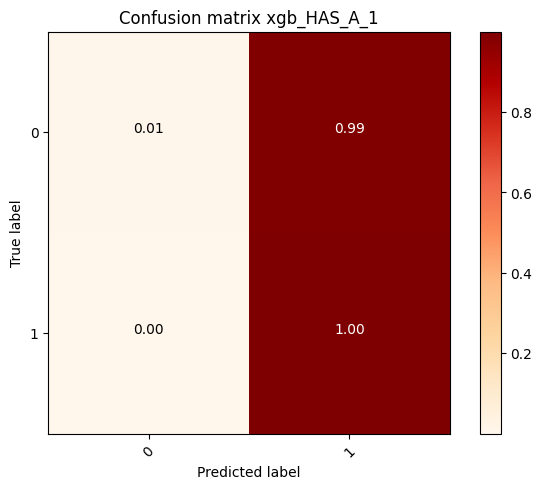

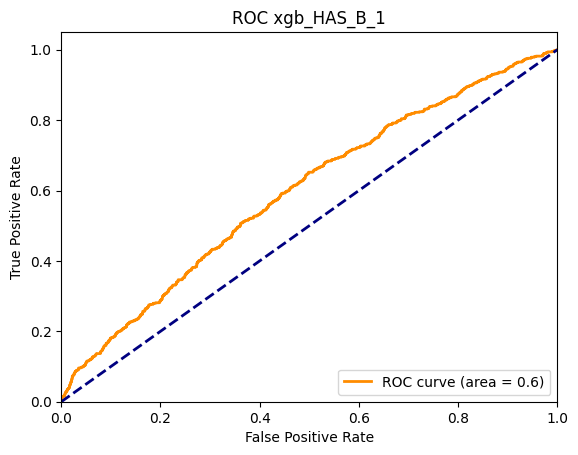

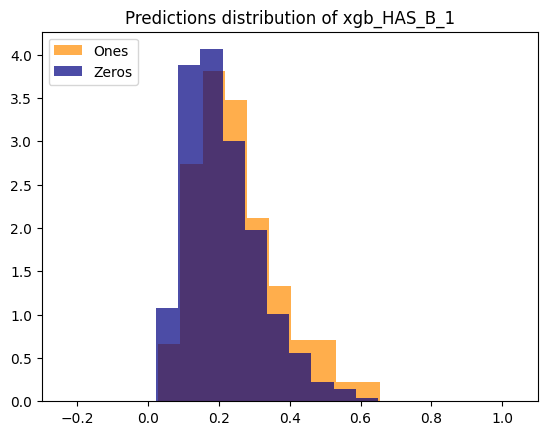

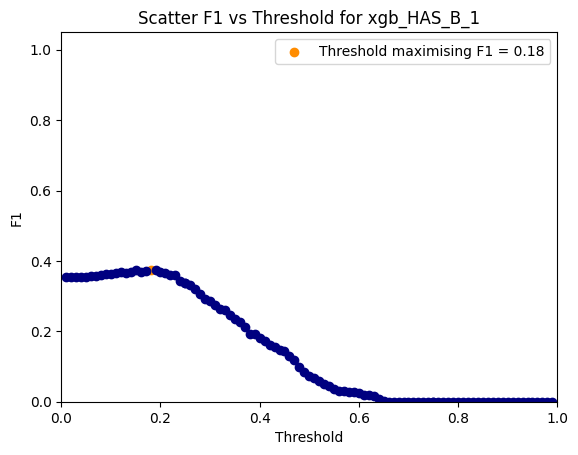

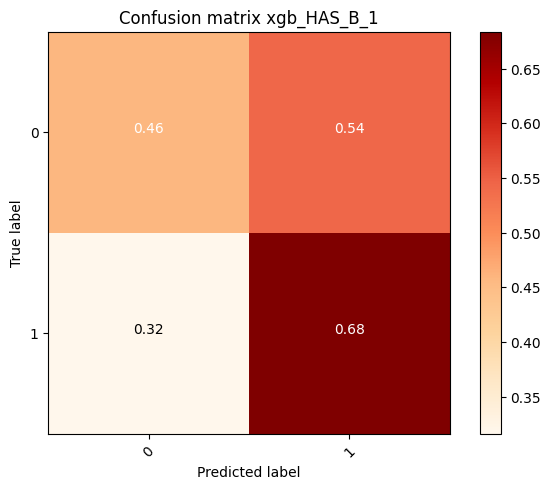

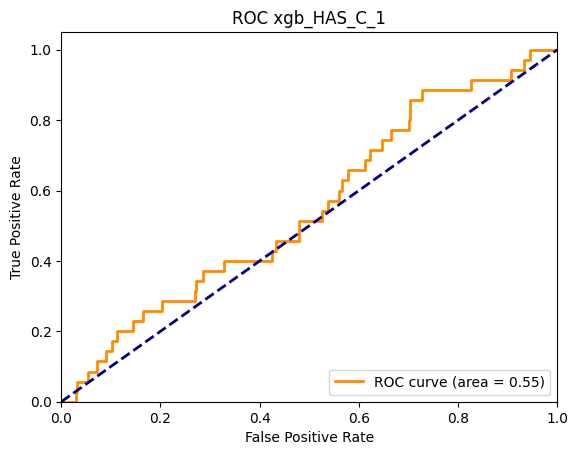

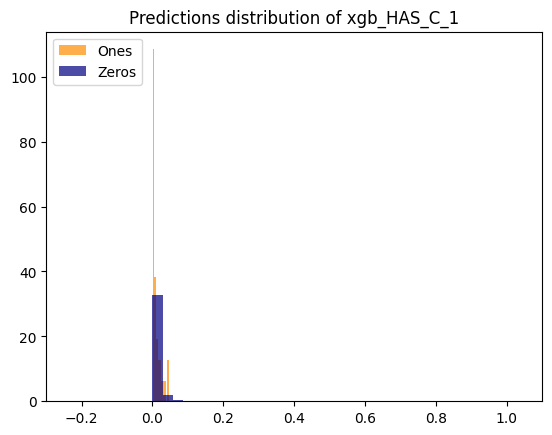

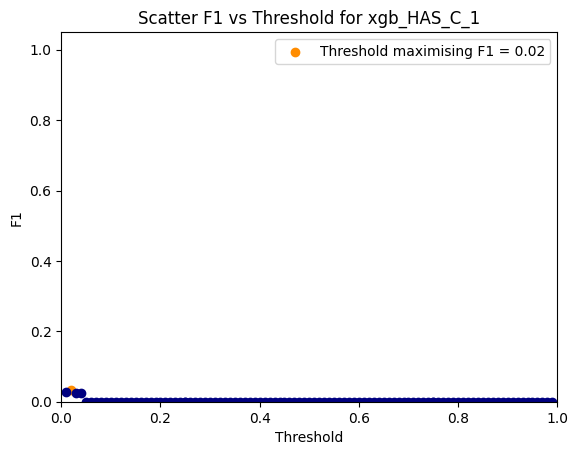

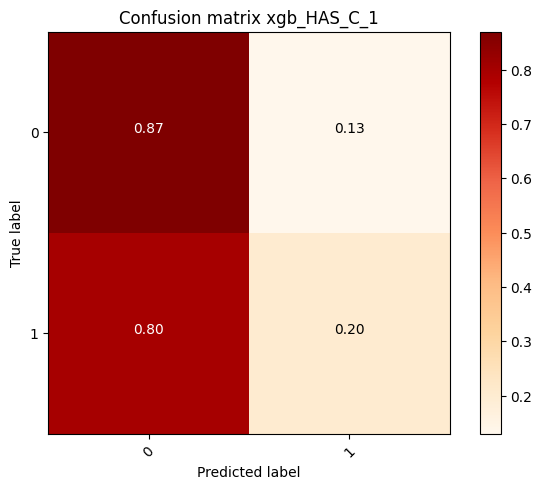

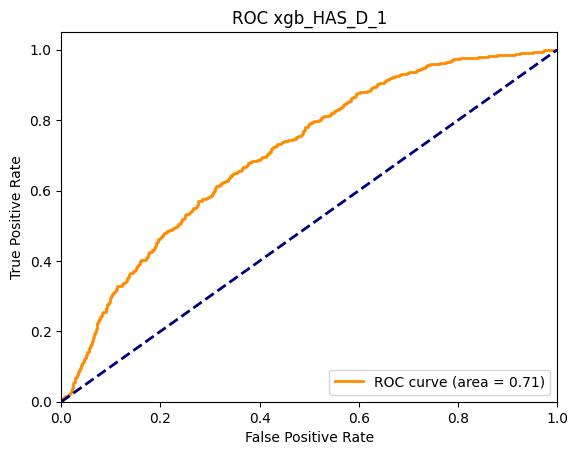

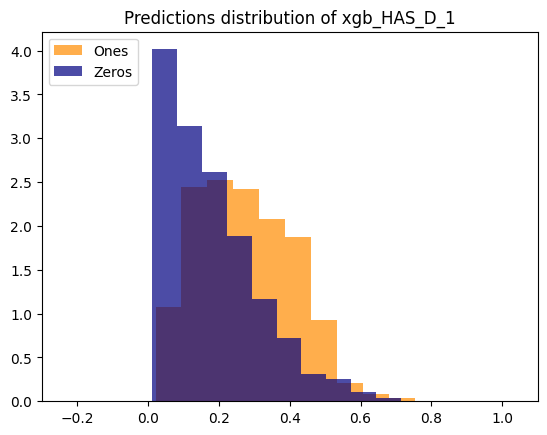

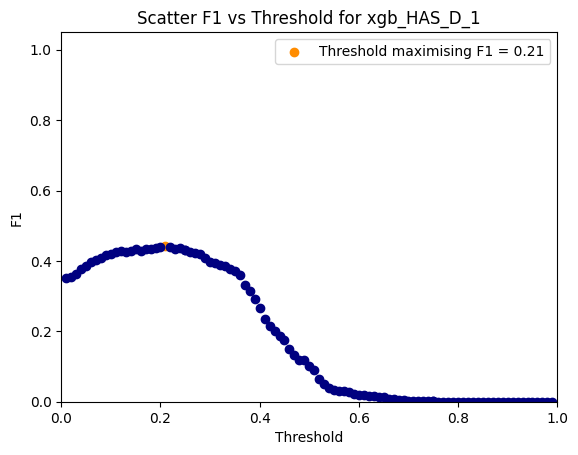

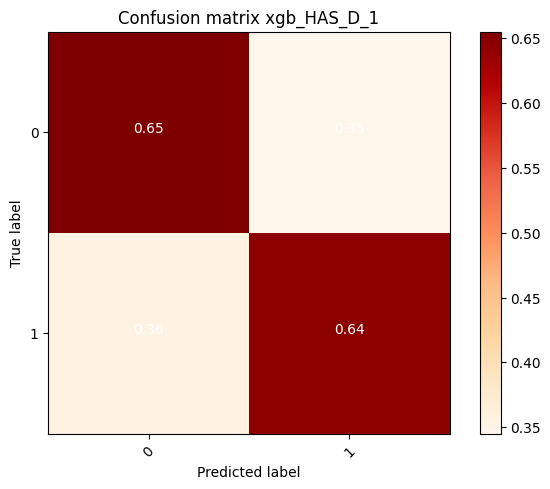

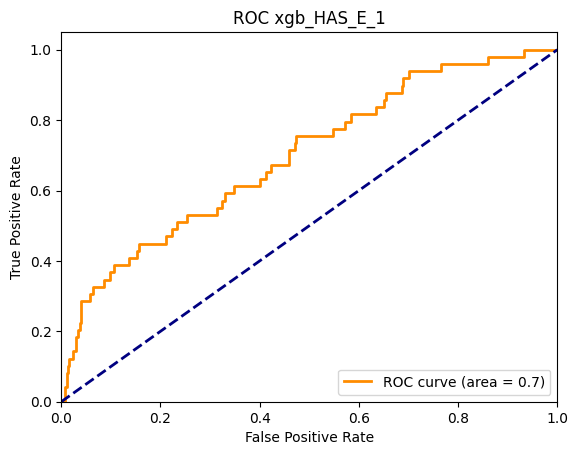

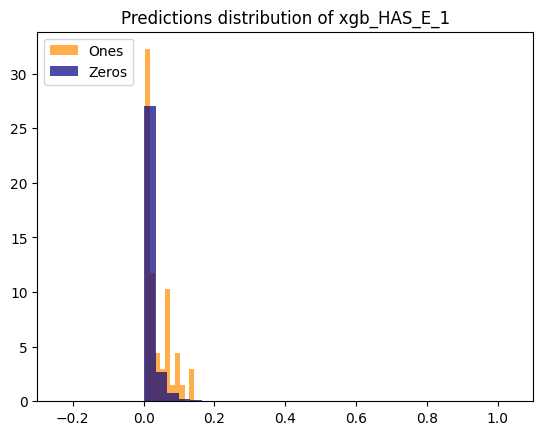

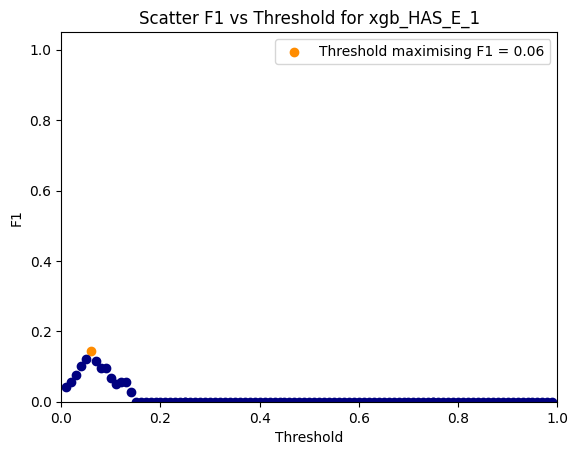

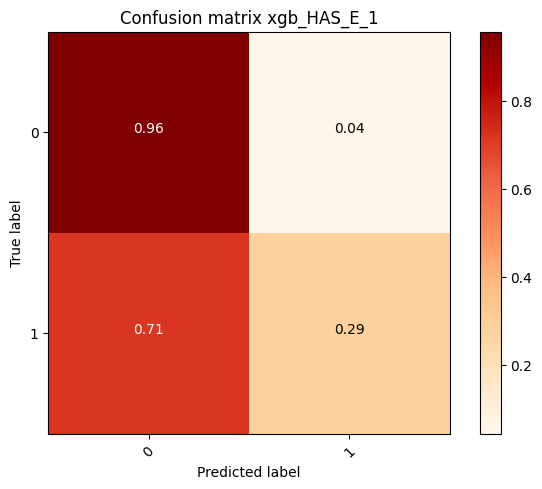

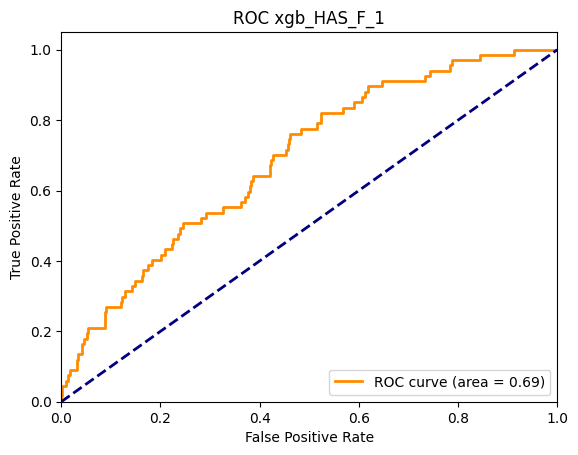

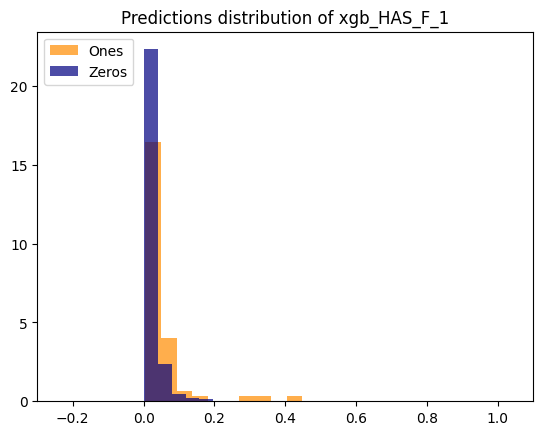

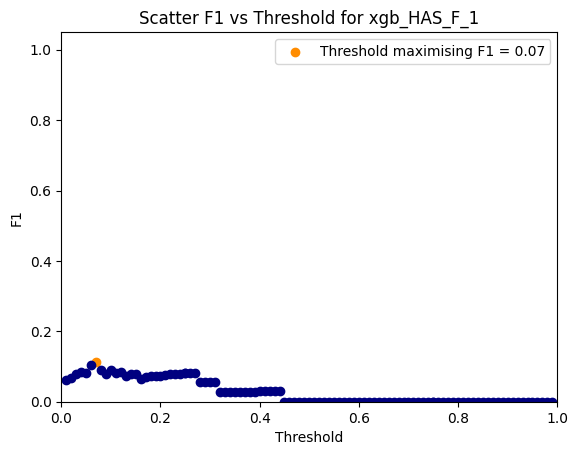

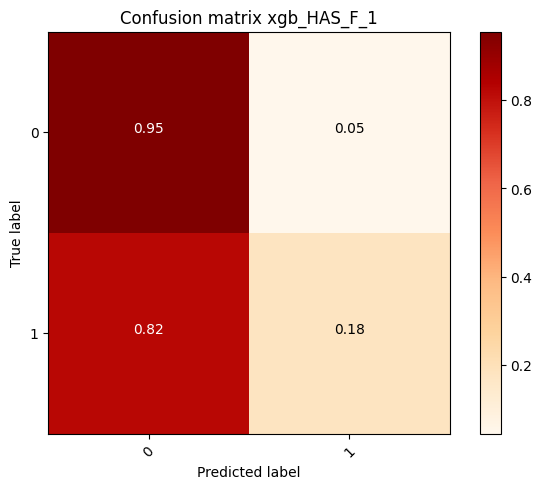

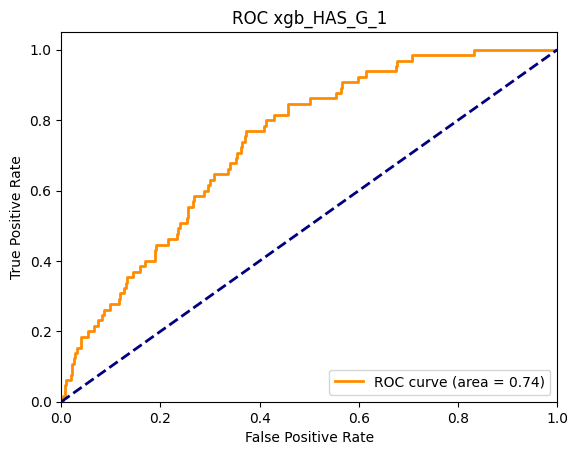

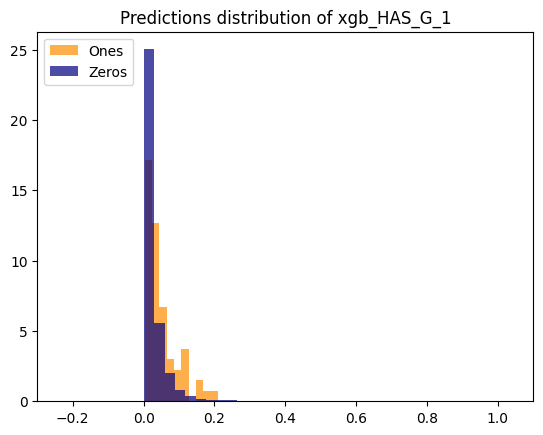

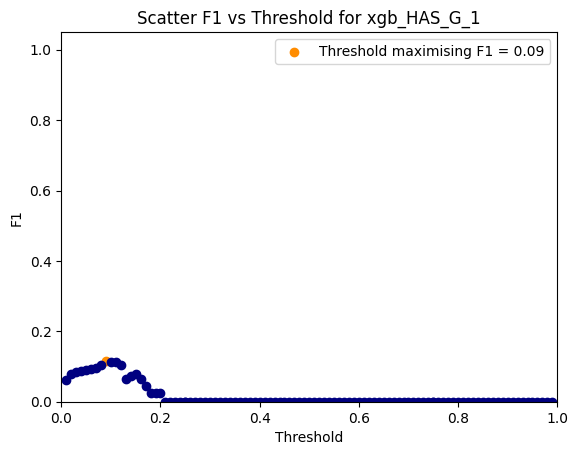

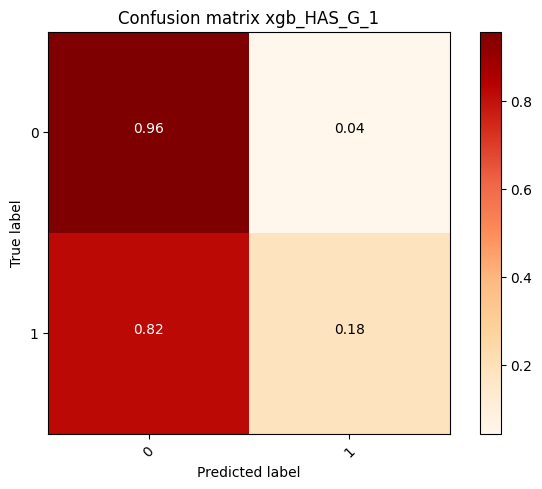

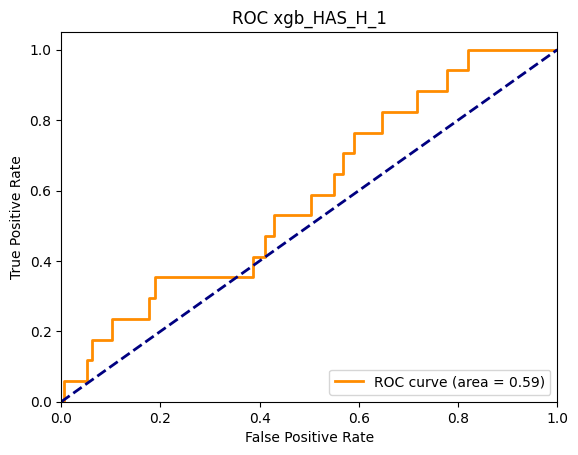

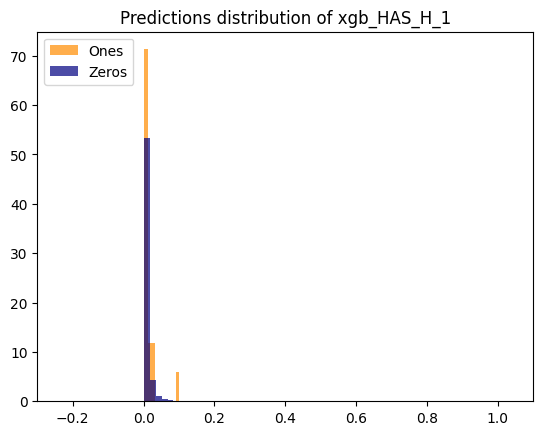

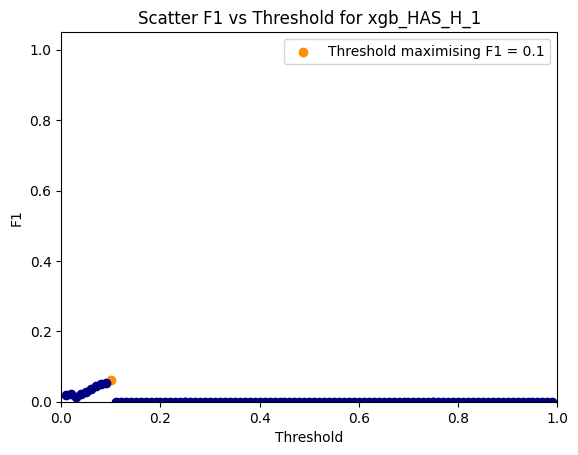

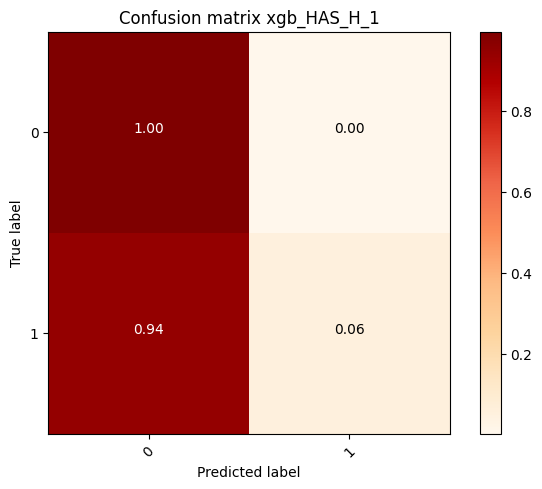

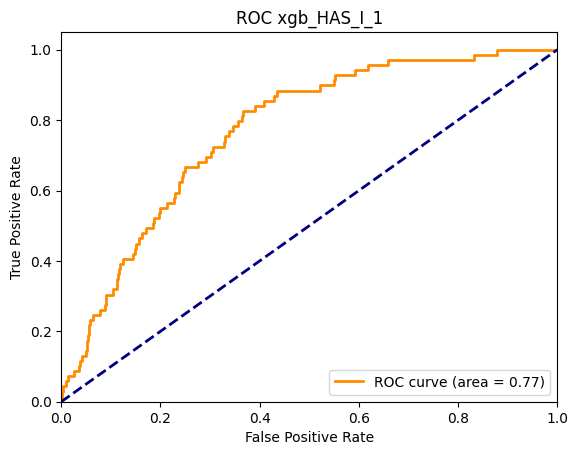

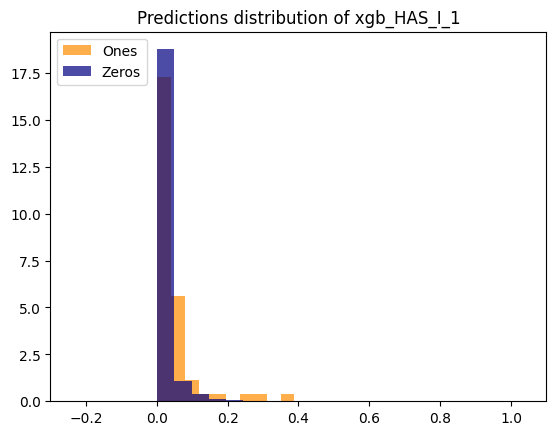

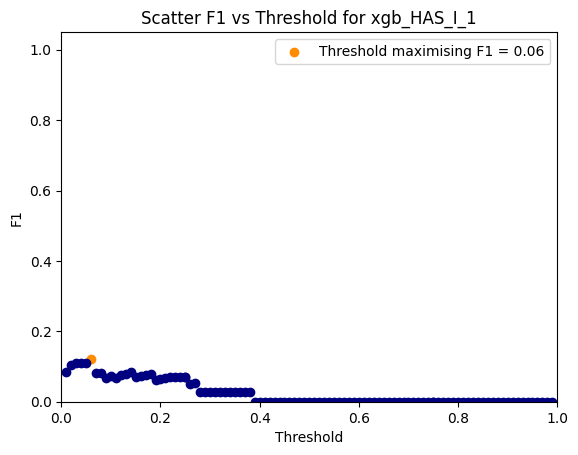

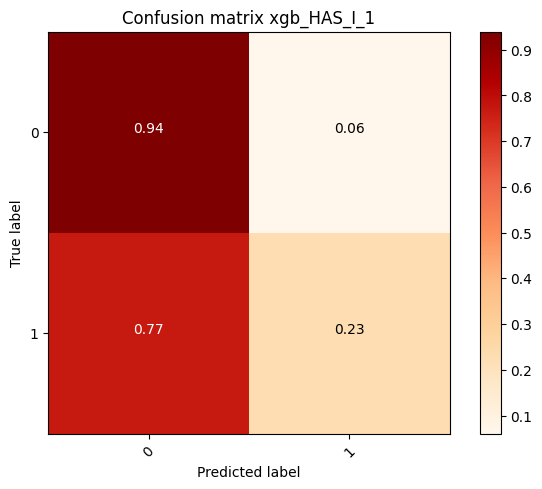

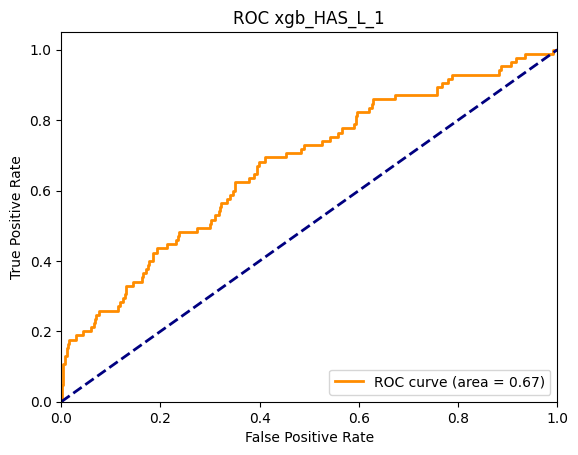

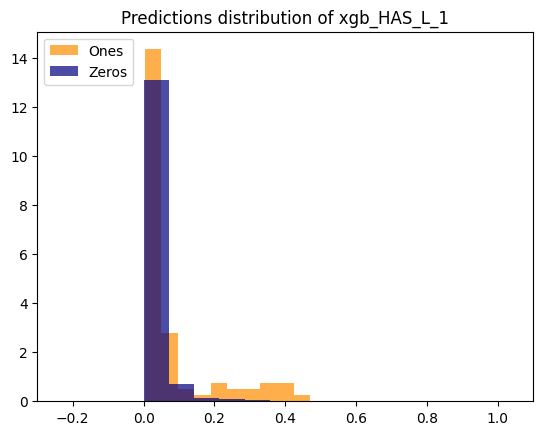

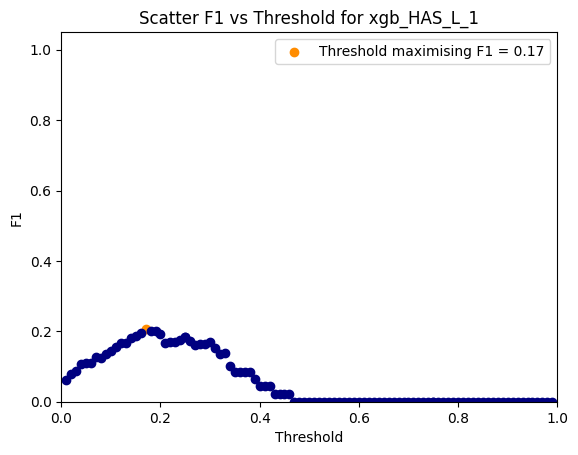

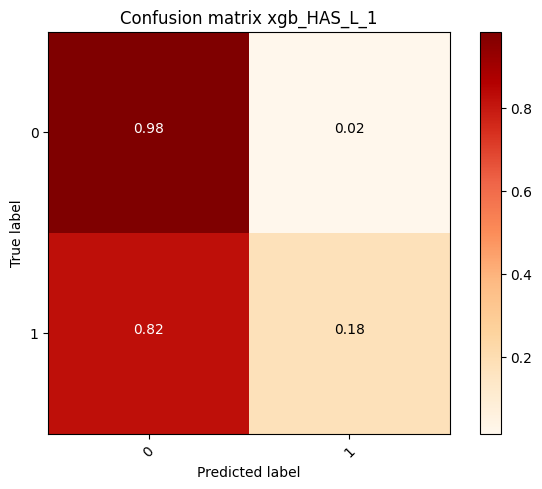

In [14]:
# Config
CONFIG_FOLDER = os.path.join("config")
CONFIG_FILE = "features.csv"
DATA_FOLDER = os.path.join("..", "sample_data")
DATA_FILE = "dataset.csv"
MODELS_FOLDER = os.path.join("models")
RESULTS_FOLDER = os.path.join("results")

MODEL_TYPE = "model"
TAG = "xgb"

PREDICTIONS_FILE = "_".join([MODEL_TYPE, TAG, "pred.csv"])

SAVE = True

# XGBoost params
# use an optimisation method to find the best params
SEED = 17
XGB_PARAMS = {
    "learning_rate": 0.1,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "seed": SEED,
    "verbose": 0,
    "max_depth": 8,
    "min_child_weight": 3,
    "colsample_bytree": 0.75,
    "subsample": 0.75,
    "gamma": 5
}


if __name__ == "__main__":
    pmp = pm.PimpPlot(save=SAVE, folder=os.path.join(RESULTS_FOLDER, "plots"))

    # Load config
    source_config = os.path.join(CONFIG_FOLDER, CONFIG_FILE)
    features = pd.read_csv(source_config, keep_default_na=False, na_values=[""])
    print(features.columns)
    index = features.loc[features[MODEL_TYPE] == "index", "column"].tolist()
    print(index)
    predictors = features.loc[features[MODEL_TYPE] == "predictor", "column"].tolist()
    labels = features.loc[features[MODEL_TYPE] == "label", "column"].tolist()
    categorical = features.loc[(features["categorical"] == 1) & (features["column"].isin(predictors)), "column"].tolist()

    # Load data
    source_file = os.path.join(DATA_FOLDER, DATA_FILE)
    data = pd.read_csv(source_file, usecols=index+labels+predictors+["SET"],
                    sep=";", decimal=".", encoding="latin1",
                    keep_default_na = False, na_values = [""])

    # Preprocessing XGBoost
    group_categoricals_tail(data, categorical)
    data = pd.get_dummies(data, columns=categorical).copy()

    # Split the dataset
    indexes = {"train": None, "valid": None, "test": None}
    for set_name in indexes.keys():
        indexes[set_name] = np.where(data["SET"] == set_name)[0]

    # Get only relevant features
    xgb_features = [x for x in sorted(data.columns.tolist()) if x not in labels + index + ["SET"]]

    d = {}
    for set_name, set_indexes in indexes.items():
        d[set_name] = xgb.DMatrix(data.loc[set_indexes, xgb_features])

    predictions = {}

    print(labels)
    for label in labels:
        print("----------------------------", end="\n")
        print(label, end="\n")
        print("----------------------------", end="\n\n")
        
        print("Creating the DMatrix...")
        for set_name, set_indexes in indexes.items():
            d[set_name].set_label(data.loc[set_indexes, label].values)
        print("Done!", end="\n\n")

        print("Training XGB...")
        bst = xgb.train(params=XGB_PARAMS, 
                        num_boost_round=3000, 
                        dtrain=d["train"], evals=[(d["valid"], "val")])
        print("Done!", end="\n\n")

        print("Predictions and plots XGB...")
        pred_label = "{0}_PRED_{1}".format(label, TAG.upper())
        predictions[pred_label] = bst.predict(d["test"])
        
        print("Logloss: {}".format(log_loss(d["test"].get_label(), predictions[pred_label])), end="\n\n")

        threshold_preds = (predictions[pred_label] > 0.5).astype(int)
        
        auc_score = roc_auc_score(d["test"].get_label(), predictions[pred_label])
        accuracy = accuracy_score(d["test"].get_label(), threshold_preds)
        precision = precision_score(d["test"].get_label(), threshold_preds)
        recall = recall_score(d["test"].get_label(), threshold_preds)
        pr_auc = average_precision_score(d["test"].get_label(), predictions[pred_label])
        f2_score = fbeta_score(d["test"].get_label(), threshold_preds, beta=2)
        
        print(f"AUC {label}: {auc_score:.4f}")
        print(f"Accuracy {label}: {accuracy:.4f}")
        print(f"Precision {label}: {precision:.4f}")
        print(f"Recall {label}: {recall:.4f}")
        print(f"PR_AUC {label}: {pr_auc:.4f}")
        print(f"F2-Score {label}: {f2_score:.4f}")
        
        if TAG:
            title = "_".join([TAG, label])
        else:
            title = label
        pmp.plot_roc(d["test"].get_label(), predictions[pred_label], title)
        pmp.plot_distributions(d["test"].get_label(), predictions[pred_label], title)
        threshold = pmp.find_threshold_max_f1(d["test"].get_label(), predictions[pred_label], title, N = 100)
        binary_predictions = np.where(predictions[pred_label] >= threshold, 1, 0)
        pmp.plot_confusion_matrix(d["test"].get_label(), binary_predictions, [0, 1], title)
        print("Done!", end="\n\n")

        if SAVE:
            print("Saving...")
            bst.save_model(os.path.join(MODELS_FOLDER, title + ".model"))
            print("Done!", end="\n\n")

    predictions = pd.DataFrame(predictions)
    predictions.to_csv(os.path.join(RESULTS_FOLDER, PREDICTIONS_FILE), sep=";", index=False)